## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


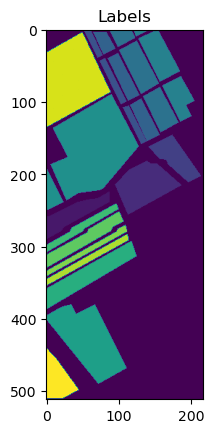

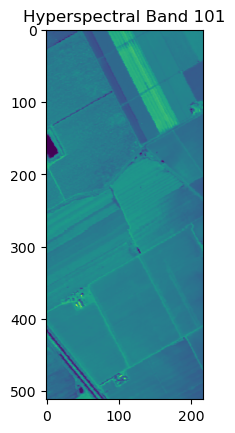

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53409 samples
	shape (53409, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(640, 5, 5, 204)
(80, 5, 5, 204)
(53409, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1540, PSNR: 7.2240


	 Training Batch [200/677], Loss: 0.0892, PSNR: 9.6776


	 Training Batch [400/677], Loss: 0.0453, PSNR: 12.4962


	 Training Batch [600/677], Loss: 0.0249, PSNR: 15.1712


Epoch [1/50] Training Loss: 0.0669, PSNR: 11.6177
	[Val]   Batch [1/170] Loss: 0.0215, PSNR: 15.7644
	[Val]   Batch [10/170] Loss: 0.0212, PSNR: 15.9202
	[Val]   Batch [20/170] Loss: 0.0213, PSNR: 15.8183
	[Val]   Batch [30/170] Loss: 0.0220, PSNR: 15.6182
	[Val]   Batch [40/170] Loss: 0.0221, PSNR: 15.6990


	[Val]   Batch [50/170] Loss: 0.0209, PSNR: 15.9084
	[Val]   Batch [60/170] Loss: 0.0219, PSNR: 15.7811
	[Val]   Batch [70/170] Loss: 0.0214, PSNR: 15.8796
	[Val]   Batch [80/170] Loss: 0.0218, PSNR: 15.6820
	[Val]   Batch [90/170] Loss: 0.0211, PSNR: 15.9316


	[Val]   Batch [100/170] Loss: 0.0212, PSNR: 15.8465
	[Val]   Batch [110/170] Loss: 0.0213, PSNR: 15.8266
	[Val]   Batch [120/170] Loss: 0.0200, PSNR: 14.1403
	[Val]   Batch [130/170] Loss: 0.0211, PSNR: 15.9312


	[Val]   Batch [140/170] Loss: 0.0207, PSNR: 15.9805
	[Val]   Batch [150/170] Loss: 0.0222, PSNR: 15.7237
	[Val]   Batch [160/170] Loss: 0.0218, PSNR: 15.7688
	[Val]   Batch [170/170] Loss: 0.0227, PSNR: 15.0344
Epoch [1/50] Validation Loss: 0.0215, PSNR: 15.7482

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0212, PSNR: 15.7962


	 Training Batch [200/677], Loss: 0.0147, PSNR: 17.5056


	 Training Batch [400/677], Loss: 0.0110, PSNR: 18.7010


	 Training Batch [600/677], Loss: 0.0095, PSNR: 19.3723


Epoch [2/50] Training Loss: 0.0130, PSNR: 18.0852
	[Val]   Batch [1/170] Loss: 0.0087, PSNR: 19.6798
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 19.9998
	[Val]   Batch [20/170] Loss: 0.0084, PSNR: 19.8720
	[Val]   Batch [30/170] Loss: 0.0090, PSNR: 19.5015
	[Val]   Batch [40/170] Loss: 0.0092, PSNR: 19.4855


	[Val]   Batch [50/170] Loss: 0.0081, PSNR: 20.0200
	[Val]   Batch [60/170] Loss: 0.0090, PSNR: 19.6375
	[Val]   Batch [70/170] Loss: 0.0088, PSNR: 19.7338
	[Val]   Batch [80/170] Loss: 0.0089, PSNR: 19.5926
	[Val]   Batch [90/170] Loss: 0.0085, PSNR: 19.8711


	[Val]   Batch [100/170] Loss: 0.0085, PSNR: 19.7912
	[Val]   Batch [110/170] Loss: 0.0084, PSNR: 19.8427
	[Val]   Batch [120/170] Loss: 0.0074, PSNR: 18.4506
	[Val]   Batch [130/170] Loss: 0.0085, PSNR: 19.8818
	[Val]   Batch [140/170] Loss: 0.0079, PSNR: 20.1425


	[Val]   Batch [150/170] Loss: 0.0092, PSNR: 19.5372
	[Val]   Batch [160/170] Loss: 0.0089, PSNR: 19.6273
	[Val]   Batch [170/170] Loss: 0.0092, PSNR: 18.9538
Epoch [2/50] Validation Loss: 0.0086, PSNR: 19.7185

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0093, PSNR: 19.4822


	 Training Batch [200/677], Loss: 0.0070, PSNR: 20.7246


	 Training Batch [400/677], Loss: 0.0058, PSNR: 21.5147


	 Training Batch [600/677], Loss: 0.0049, PSNR: 22.1744


Epoch [3/50] Training Loss: 0.0064, PSNR: 21.1066
	[Val]   Batch [1/170] Loss: 0.0046, PSNR: 22.4419
	[Val]   Batch [10/170] Loss: 0.0044, PSNR: 22.7180
	[Val]   Batch [20/170] Loss: 0.0045, PSNR: 22.6144
	[Val]   Batch [30/170] Loss: 0.0048, PSNR: 22.2060
	[Val]   Batch [40/170] Loss: 0.0049, PSNR: 22.2285


	[Val]   Batch [50/170] Loss: 0.0044, PSNR: 22.6862
	[Val]   Batch [60/170] Loss: 0.0048, PSNR: 22.3666
	[Val]   Batch [70/170] Loss: 0.0047, PSNR: 22.4964
	[Val]   Batch [80/170] Loss: 0.0047, PSNR: 22.3664
	[Val]   Batch [90/170] Loss: 0.0046, PSNR: 22.5756


	[Val]   Batch [100/170] Loss: 0.0046, PSNR: 22.4385
	[Val]   Batch [110/170] Loss: 0.0045, PSNR: 22.5545
	[Val]   Batch [120/170] Loss: 0.0040, PSNR: 21.0915
	[Val]   Batch [130/170] Loss: 0.0046, PSNR: 22.5467
	[Val]   Batch [140/170] Loss: 0.0042, PSNR: 22.8888


	[Val]   Batch [150/170] Loss: 0.0049, PSNR: 22.2739
	[Val]   Batch [160/170] Loss: 0.0047, PSNR: 22.3799
	[Val]   Batch [170/170] Loss: 0.0048, PSNR: 21.7581
Epoch [3/50] Validation Loss: 0.0046, PSNR: 22.4504

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0047, PSNR: 22.3663


	 Training Batch [200/677], Loss: 0.0036, PSNR: 23.5658


	 Training Batch [400/677], Loss: 0.0034, PSNR: 23.8286


	 Training Batch [600/677], Loss: 0.0029, PSNR: 24.5172


Epoch [4/50] Training Loss: 0.0036, PSNR: 23.5797
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.8362
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0908
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 24.9584
	[Val]   Batch [30/170] Loss: 0.0028, PSNR: 24.5056
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.7069
	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9483


	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.7395
	[Val]   Batch [70/170] Loss: 0.0026, PSNR: 24.9511
	[Val]   Batch [80/170] Loss: 0.0027, PSNR: 24.7778
	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.9290
	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6922


	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9783
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.2475
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.7707
	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.2454
	[Val]   Batch [150/170] Loss: 0.0028, PSNR: 24.6839


	[Val]   Batch [160/170] Loss: 0.0027, PSNR: 24.7914
	[Val]   Batch [170/170] Loss: 0.0028, PSNR: 24.1225
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.8025

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0028, PSNR: 24.6916


	 Training Batch [200/677], Loss: 0.0024, PSNR: 25.2120


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.7179


	 Training Batch [600/677], Loss: 0.0021, PSNR: 25.9885


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3245
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.4125
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.6547
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.4756
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 25.9735
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.3505


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.4438
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.2600
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.5943
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.3362


	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.5062
	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.1553
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.6412
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6906
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.2220


	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.8106
	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.2037
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.3636
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.6408
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.3360

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0019, PSNR: 26.4314


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.6415


	 Training Batch [400/677], Loss: 0.0016, PSNR: 27.1150


	 Training Batch [600/677], Loss: 0.0016, PSNR: 27.2331


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5493
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6505
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.8639
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.6621
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.1228
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6162


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.5662
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4501
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.8733
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.5749
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7159


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.2851
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.9443
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.7730
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3566


	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.0346
	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.3990
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.5951
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.8853
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5369

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.7024


	 Training Batch [200/677], Loss: 0.0015, PSNR: 27.2822


	 Training Batch [400/677], Loss: 0.0014, PSNR: 27.6165


	 Training Batch [600/677], Loss: 0.0013, PSNR: 27.9003


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5132
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6962
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.9229
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6876
	[Val]   Batch [30/170] Loss: 0.0012, PSNR: 28.0872
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6972
	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5651


	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4600
	[Val]   Batch [70/170] Loss: 0.0010, PSNR: 28.9758
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.6163
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7835
	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2402


	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0946
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7663
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3172
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.1326
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3756


	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6375
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.9331
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5625

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.5097


	 Training Batch [200/677], Loss: 0.0014, PSNR: 27.6239


	 Training Batch [400/677], Loss: 0.0012, PSNR: 28.3919


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.7334


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2887
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.4936
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.7315
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.4653
	[Val]   Batch [30/170] Loss: 0.0011, PSNR: 28.8193
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.5125


	[Val]   Batch [50/170] Loss: 0.0010, PSNR: 29.3002
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.2282
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.8103
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.4211
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.6017


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 28.9949
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 29.9576
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.4989
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.0723
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 29.9522


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.1271
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.4193
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.7382
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.3374

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 28.7558


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.9321


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.1918


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.0955


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0029
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.3577
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6270
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.3222
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.6675
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.4052


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.1166
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.0916
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.6950
	[Val]   Batch [80/170] Loss: 0.0008, PSNR: 30.3153
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.5218


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.8722
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.8634
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3193
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 29.9363
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8620


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 29.9922
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2655
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.6089
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2004

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.3563


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.5856


	 Training Batch [400/677], Loss: 0.0007, PSNR: 29.8680


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.6687


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.6428
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.1286
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.3478
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.0307
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.4330
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.2018


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.7207
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.8648
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.4768
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.1232
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.3281


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.6772
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.6112
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.9626
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.7579
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.5639


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7898
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 31.0043
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.4708
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.9573

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.7762


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.2653


	 Training Batch [400/677], Loss: 0.0008, PSNR: 30.3842


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.0617


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.2593
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.9244
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.1338
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.7423
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.2382
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.9915


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5155
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.6531
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.2129
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.9153
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.1650


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.4920
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.4262
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.7737
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.5712
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.3659


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.5588
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.7343
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.3525
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.7366

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.2698


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.3117


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.6523


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.6696


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7834
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.5478
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.8161
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.3536
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.9089
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.6072


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.1051
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.3295
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.8232
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.6008
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.8576


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.2003
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.0540
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.4172
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.2902
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.0137


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.2506
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.3474
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.0896
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.3899

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.2004


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.8434


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.4554


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.8577


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.2417
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.0968
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.3904
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.8997
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.5361
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.2071
	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.5829


	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.9535
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.3746
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.2248
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.4981
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.8846


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.6237
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.9106
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.9789
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.5377
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.9124


	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.8844
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.8437
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.9838

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.1814


	 Training Batch [200/677], Loss: 0.0006, PSNR: 30.6396


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.6406


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.8271


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.6252
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5968
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8833
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3753
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.0571
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6347


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.9891
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.4771
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.8364
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.7553


	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.0199
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.4833
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1055
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.4093
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.5863


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0081
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.4792
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3726
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.5237
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.4905

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.2702


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.2008


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.9886


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.6714


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9591
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.1107
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.3944
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.8439
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.6139
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.2057


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.4642
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.0459
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.3409
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.3009
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.6109


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.0134
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6036
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.8796
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.1144
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.5321


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.0377
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.8529
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.0579
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.0070

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0597


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.9709


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.7774


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.2306


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3160
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.6226
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.9663
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3608
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.1582
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7197


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.9687
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.5811
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.7939
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.8502
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 35.1599


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.5610
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.1463
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.4104
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.6580
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.0770


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.5700
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.3084
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.7806
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.5320

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.8246


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.8557


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1180


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.0197


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5587
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.9678
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.3222
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.6398
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.5853
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0191


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.2903
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.0107
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1015
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.2465
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5634


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9881
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.4605
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.7040
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0861


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.4047
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9971
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.6393
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.2265
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8873

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.2974


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5537


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.3401


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.9724


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.8361
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.2617
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.6434
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.9773
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.9170
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.3727


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5663
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.3332
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.4258
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.5890
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.9371


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.3748
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.8173
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 33.0614
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.4872
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.7389


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.3726
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9475
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.6093
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.2240

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.3969


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.3894


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.5387


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.5035


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.0652
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.6837
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.9477
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.2748
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.2975
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.7347
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.9066


	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.7328
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.7690
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.9625
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.3661
	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.7211


	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.1623
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.4324
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.8425
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.0884
	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.7215


	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.2528
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.9742
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.5736
Early stopping triggered at epoch 19. No improvement for 3 epochs.


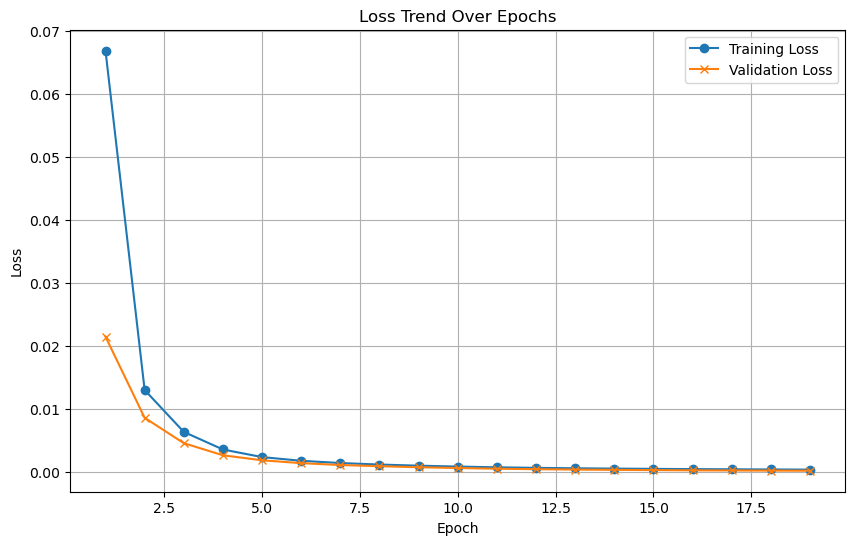

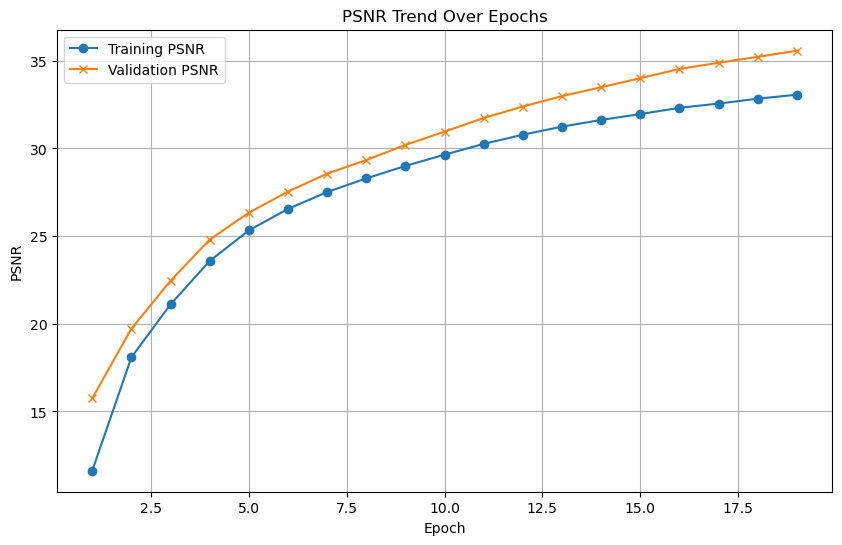

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/209 for test dataset.


    Processed batch 101/209 for test dataset.


    Processed batch 201/209 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7638
    Validation Batch [1/1], Loss: 2.7776
Validation Loss: 2.7776, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7776. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6969
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss improved from 2.7776 to 2.7775. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6613
    Validation Batch [1/1], Loss: 2.7774
Validation Loss: 2.7774, Validation Accuracy: 6.25%
Validation loss improved from 2.7775 to 2.7774. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6303
    Validation Batch [1/1], Loss: 2.7773
Validation Loss: 2.7773, Validation Accuracy: 6.25%
Validation loss improved from 2.7774 to 2.7773. Saving model...

LOG: Epoch [5/1000] - 

Epoch [9/1000] completed, Average Training Loss: 2.5182
    Validation Batch [1/1], Loss: 2.7786
Validation Loss: 2.7786, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.5087
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4797
    Validation Batch [1/1], Loss: 2.7801
Validation Loss: 2.7801, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4665
    Validation Batch [1/1], Loss: 2.7808
Validation Loss: 2.7808, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.4393
    Validation B

    Validation Batch [1/1], Loss: 2.7103
Validation Loss: 2.7103, Validation Accuracy: 12.50%
Validation loss improved from 2.7346 to 2.7103. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2596
    Validation Batch [1/1], Loss: 2.6814
Validation Loss: 2.6814, Validation Accuracy: 12.50%
Validation loss improved from 2.7103 to 2.6814. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2481
    Validation Batch [1/1], Loss: 2.6478
Validation Loss: 2.6478, Validation Accuracy: 12.50%
Validation loss improved from 2.6814 to 2.6478. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2221
    Validation Batch [1/1], Loss: 2.6051
Validation Loss: 2.6051, Validation Accuracy: 15.00%
Validation loss improved from 2.6478 to 2.6051. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2020
    Vali

Epoch [36/1000] completed, Average Training Loss: 2.0351
    Validation Batch [1/1], Loss: 2.1005
Validation Loss: 2.1005, Validation Accuracy: 57.50%
Validation loss improved from 2.1479 to 2.1005. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.0282
    Validation Batch [1/1], Loss: 2.0697
Validation Loss: 2.0697, Validation Accuracy: 55.00%
Validation loss improved from 2.1005 to 2.0697. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.9922
    Validation Batch [1/1], Loss: 2.0449
Validation Loss: 2.0449, Validation Accuracy: 60.00%
Validation loss improved from 2.0697 to 2.0449. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.0032
    Validation Batch [1/1], Loss: 2.0064
Validation Loss: 2.0064, Validation Accuracy: 58.75%
Validation loss improved from 2.0449 to 2.0064. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [4

Epoch [43/1000] completed, Average Training Loss: 1.9111
    Validation Batch [1/1], Loss: 1.9184
Validation Loss: 1.9184, Validation Accuracy: 67.50%
Validation loss improved from 1.9350 to 1.9184. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.8979
    Validation Batch [1/1], Loss: 1.8962
Validation Loss: 1.8962, Validation Accuracy: 66.25%
Validation loss improved from 1.9184 to 1.8962. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.8934
    Validation Batch [1/1], Loss: 1.8696
Validation Loss: 1.8696, Validation Accuracy: 66.25%
Validation loss improved from 1.8962 to 1.8696. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.8596
    Validation Batch [1/1], Loss: 1.8508
Validation Loss: 1.8508, Validation Accuracy: 66.25%
Validation loss improved from 1.8696 to 1.8508. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [4

Epoch [57/1000] completed, Average Training Loss: 1.7127
    Validation Batch [1/1], Loss: 1.6633
Validation Loss: 1.6633, Validation Accuracy: 70.00%
Validation loss improved from 1.6859 to 1.6633. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.6887
    Validation Batch [1/1], Loss: 1.6532
Validation Loss: 1.6532, Validation Accuracy: 70.00%
Validation loss improved from 1.6633 to 1.6532. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.6733
    Validation Batch [1/1], Loss: 1.6387
Validation Loss: 1.6387, Validation Accuracy: 70.00%
Validation loss improved from 1.6532 to 1.6387. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 1.6447
    Validation Batch [1/1], Loss: 1.5958
Validation Loss: 1.5958, Validation Accuracy: 68.75%
Validation loss improved from 1.6387 to 1.5958. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [6

Epoch [70/1000] completed, Average Training Loss: 1.5108
    Validation Batch [1/1], Loss: 1.4330
Validation Loss: 1.4330, Validation Accuracy: 71.25%
Validation loss improved from 1.4828 to 1.4330. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.4927
    Validation Batch [1/1], Loss: 1.5266
Validation Loss: 1.5266, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.4650
    Validation Batch [1/1], Loss: 1.4223
Validation Loss: 1.4223, Validation Accuracy: 75.00%
Validation loss improved from 1.4330 to 1.4223. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 1.4567
    Validation Batch [1/1], Loss: 1.3914
Validation Loss: 1.3914, Validation Accuracy: 77.50%
Validation loss improved from 1.4223 to 1.3914. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] complet

Epoch [83/1000] completed, Average Training Loss: 1.3016
    Validation Batch [1/1], Loss: 1.2989
Validation Loss: 1.2989, Validation Accuracy: 77.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.2800
    Validation Batch [1/1], Loss: 1.2614
Validation Loss: 1.2614, Validation Accuracy: 77.50%
Validation loss improved from 1.2852 to 1.2614. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.2786
    Validation Batch [1/1], Loss: 1.2755
Validation Loss: 1.2755, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.2631
    Validation Batch [1/1], Loss: 1.2069
Validation Loss: 1.2069, Validation Accuracy: 77.50%
Validation loss improved from 1.2614 to 1.2069. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Tra

Epoch [97/1000] completed, Average Training Loss: 1.0867
    Validation Batch [1/1], Loss: 1.0488
Validation Loss: 1.0488, Validation Accuracy: 86.25%
Validation loss improved from 1.0830 to 1.0488. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.0862
    Validation Batch [1/1], Loss: 1.0417
Validation Loss: 1.0417, Validation Accuracy: 86.25%
Validation loss improved from 1.0488 to 1.0417. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.0774
    Validation Batch [1/1], Loss: 1.0596
Validation Loss: 1.0596, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.0610
    Validation Batch [1/1], Loss: 1.0305
Validation Loss: 1.0305, Validation Accuracy: 86.25%
Validation loss improved from 1.0417 to 1.0305. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] com

Epoch [110/1000] completed, Average Training Loss: 0.9060
    Validation Batch [1/1], Loss: 0.8880
Validation Loss: 0.8880, Validation Accuracy: 88.75%
Validation loss improved from 0.9293 to 0.8880. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.9253
    Validation Batch [1/1], Loss: 0.8810
Validation Loss: 0.8810, Validation Accuracy: 88.75%
Validation loss improved from 0.8880 to 0.8810. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 0.8940
    Validation Batch [1/1], Loss: 0.8830
Validation Loss: 0.8830, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 0.8778
    Validation Batch [1/1], Loss: 0.8254
Validation Loss: 0.8254, Validation Accuracy: 87.50%
Validation loss improved from 0.8810 to 0.8254. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000

Epoch [124/1000] completed, Average Training Loss: 0.7360
    Validation Batch [1/1], Loss: 0.7350
Validation Loss: 0.7350, Validation Accuracy: 90.00%
Validation loss improved from 0.7438 to 0.7350. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.7446
    Validation Batch [1/1], Loss: 0.7313
Validation Loss: 0.7313, Validation Accuracy: 88.75%
Validation loss improved from 0.7350 to 0.7313. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.7406
    Validation Batch [1/1], Loss: 0.7303
Validation Loss: 0.7303, Validation Accuracy: 91.25%
Validation loss improved from 0.7313 to 0.7303. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.7076
    Validation Batch [1/1], Loss: 0.6792
Validation Loss: 0.6792, Validation Accuracy: 90.00%
Validation loss improved from 0.7303 to 0.6792. Saving model...

LOG: Epoch [128/1000] - Training


    Validation Batch [1/1], Loss: 0.6401
Validation Loss: 0.6401, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.5956
    Validation Batch [1/1], Loss: 0.6069
Validation Loss: 0.6069, Validation Accuracy: 91.25%
Validation loss improved from 0.6170 to 0.6069. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.5784
    Validation Batch [1/1], Loss: 0.5809
Validation Loss: 0.5809, Validation Accuracy: 91.25%
Validation loss improved from 0.6069 to 0.5809. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.5776
    Validation Batch [1/1], Loss: 0.5808
Validation Loss: 0.5808, Validation Accuracy: 90.00%
Validation loss improved from 0.5809 to 0.5808. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.5570
    Validation 

    Validation Batch [1/1], Loss: 0.5239
Validation Loss: 0.5239, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.4828
    Validation Batch [1/1], Loss: 0.5207
Validation Loss: 0.5207, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.4706
    Validation Batch [1/1], Loss: 0.4889
Validation Loss: 0.4889, Validation Accuracy: 92.50%
Validation loss improved from 0.5094 to 0.4889. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.4613
    Validation Batch [1/1], Loss: 0.4927
Validation Loss: 0.4927, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.4517
    Validation Batch [1/1], Loss: 0.4597
Vali

Epoch [163/1000] completed, Average Training Loss: 0.4012
    Validation Batch [1/1], Loss: 0.6313
Validation Loss: 0.6313, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.4077
    Validation Batch [1/1], Loss: 0.4736
Validation Loss: 0.4736, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 0.4114
    Validation Batch [1/1], Loss: 0.6922
Validation Loss: 0.6922, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 0.4204
    Validation Batch [1/1], Loss: 0.5812
Validation Loss: 0.5812, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.4229
  

Epoch [176/1000] completed, Average Training Loss: 0.3289
    Validation Batch [1/1], Loss: 0.3891
Validation Loss: 0.3891, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.3177
    Validation Batch [1/1], Loss: 0.3719
Validation Loss: 0.3719, Validation Accuracy: 92.50%
Validation loss improved from 0.3752 to 0.3719. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.3233
    Validation Batch [1/1], Loss: 0.3710
Validation Loss: 0.3710, Validation Accuracy: 92.50%
Validation loss improved from 0.3719 to 0.3710. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.3095
    Validation Batch [1/1], Loss: 0.3883
Validation Loss: 0.3883, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Av

Epoch [189/1000] completed, Average Training Loss: 0.2767
    Validation Batch [1/1], Loss: 0.3464
Validation Loss: 0.3464, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.2669
    Validation Batch [1/1], Loss: 0.3359
Validation Loss: 0.3359, Validation Accuracy: 91.25%
Validation loss improved from 0.3386 to 0.3359. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2485
    Validation Batch [1/1], Loss: 0.3419
Validation Loss: 0.3419, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.2653
    Validation Batch [1/1], Loss: 0.3415
Validation Loss: 0.3415, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training 

Epoch [202/1000] completed, Average Training Loss: 0.2307
    Validation Batch [1/1], Loss: 0.3441
Validation Loss: 0.3441, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.2210
    Validation Batch [1/1], Loss: 0.2901
Validation Loss: 0.2901, Validation Accuracy: 93.75%
Validation loss improved from 0.3009 to 0.2901. Saving model...

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.2004
    Validation Batch [1/1], Loss: 0.3100
Validation Loss: 0.3100, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.2085
    Validation Batch [1/1], Loss: 0.3071
Validation Loss: 0.3071, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training 

Epoch [216/1000] completed, Average Training Loss: 0.1664
    Validation Batch [1/1], Loss: 0.2827
Validation Loss: 0.2827, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.1771
    Validation Batch [1/1], Loss: 0.3213
Validation Loss: 0.3213, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.1857
    Validation Batch [1/1], Loss: 0.3109
Validation Loss: 0.3109, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.1846
    Validation Batch [1/1], Loss: 0.3185
Validation Loss: 0.3185, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.1659
  

Epoch [229/1000] completed, Average Training Loss: 0.1603
    Validation Batch [1/1], Loss: 0.3072
Validation Loss: 0.3072, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1455
    Validation Batch [1/1], Loss: 0.3171
Validation Loss: 0.3171, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1483
    Validation Batch [1/1], Loss: 0.3095
Validation Loss: 0.3095, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.1536
    Validation Batch [1/1], Loss: 0.2621
Validation Loss: 0.2621, Validation Accuracy: 93.75%
Validation loss improved from 0.2789 to 0.2621. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training 

Epoch [242/1000] completed, Average Training Loss: 0.1265
    Validation Batch [1/1], Loss: 0.2642
Validation Loss: 0.2642, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.1310
    Validation Batch [1/1], Loss: 0.2647
Validation Loss: 0.2647, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.1282
    Validation Batch [1/1], Loss: 0.2790
Validation Loss: 0.2790, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.1239
    Validation Batch [1/1], Loss: 0.3188
Validation Loss: 0.3188, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.124

Epoch [255/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 0.2637
Validation Loss: 0.2637, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.1068
    Validation Batch [1/1], Loss: 0.2696
Validation Loss: 0.2696, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.1296
    Validation Batch [1/1], Loss: 0.2739
Validation Loss: 0.2739, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.1311
    Validation Batch [1/1], Loss: 0.2550
Validation Loss: 0.2550, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.1021
  

    Validation Batch [1/1], Loss: 0.2810
Validation Loss: 0.2810, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.1120
    Validation Batch [1/1], Loss: 0.2842
Validation Loss: 0.2842, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.0905
    Validation Batch [1/1], Loss: 0.2794
Validation Loss: 0.2794, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.2630
Validation Loss: 0.2630, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0957
    Validation Batch [1/1], Loss: 0.3482
Validation Loss

Epoch [282/1000] completed, Average Training Loss: 0.0865
    Validation Batch [1/1], Loss: 0.2325
Validation Loss: 0.2325, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.3213
Validation Loss: 0.3213, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.2931
Validation Loss: 0.2931, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0839
    Validation Batch [1/1], Loss: 0.2584
Validation Loss: 0.2584, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0769
  

Epoch [295/1000] completed, Average Training Loss: 0.0900
    Validation Batch [1/1], Loss: 0.3160
Validation Loss: 0.3160, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.0738
    Validation Batch [1/1], Loss: 0.4917
Validation Loss: 0.4917, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.2833
Validation Loss: 0.2833, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.0825
    Validation Batch [1/1], Loss: 0.3529
Validation Loss: 0.3529, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.0708
  

Epoch [308/1000] completed, Average Training Loss: 0.0713
    Validation Batch [1/1], Loss: 0.3313
Validation Loss: 0.3313, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.0645
    Validation Batch [1/1], Loss: 0.3095
Validation Loss: 0.3095, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.2672
Validation Loss: 0.2672, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.2320
Validation Loss: 0.2320, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.066

Epoch [321/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.2783
Validation Loss: 0.2783, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 0.2759
Validation Loss: 0.2759, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.3160
Validation Loss: 0.3160, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.0573
    Validation Batch [1/1], Loss: 0.2779
Validation Loss: 0.2779, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.053

Epoch [334/1000] completed, Average Training Loss: 0.0836
    Validation Batch [1/1], Loss: 0.4284
Validation Loss: 0.4284, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0650
    Validation Batch [1/1], Loss: 0.3523
Validation Loss: 0.3523, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.0570
    Validation Batch [1/1], Loss: 0.3184
Validation Loss: 0.3184, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.0613
    Validation Batch [1/1], Loss: 0.2755
Validation Loss: 0.2755, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.068

    Validation Batch [1/1], Loss: 0.2854
Validation Loss: 0.2854, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.3102
Validation Loss: 0.3102, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.2293
Validation Loss: 0.2293, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.0504
    Validation Batch [1/1], Loss: 0.2935
Validation Loss: 0.2935, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.0401
    Validation Batch [1/1], Loss: 0.2954
Validation Loss

    Validation Batch [1/1], Loss: 0.2312
Validation Loss: 0.2312, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.0441
    Validation Batch [1/1], Loss: 0.2402
Validation Loss: 0.2402, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.2742
Validation Loss: 0.2742, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.3068
Validation Loss: 0.3068, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.0494
    Validation Batch [1/1], Loss: 0.2945
Validation Loss

Epoch [373/1000] completed, Average Training Loss: 0.0374
    Validation Batch [1/1], Loss: 0.2643
Validation Loss: 0.2643, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.2446
Validation Loss: 0.2446, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.2707
Validation Loss: 0.2707, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.2805
Validation Loss: 0.2805, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.042

    Validation Batch [1/1], Loss: 0.3628
Validation Loss: 0.3628, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0455
    Validation Batch [1/1], Loss: 0.3693
Validation Loss: 0.3693, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0721
    Validation Batch [1/1], Loss: 0.5159
Validation Loss: 0.5159, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0823
    Validation Batch [1/1], Loss: 0.3554
Validation Loss: 0.3554, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1140
    Validation Batch [1/1], Loss: 0.5410
Validation Loss

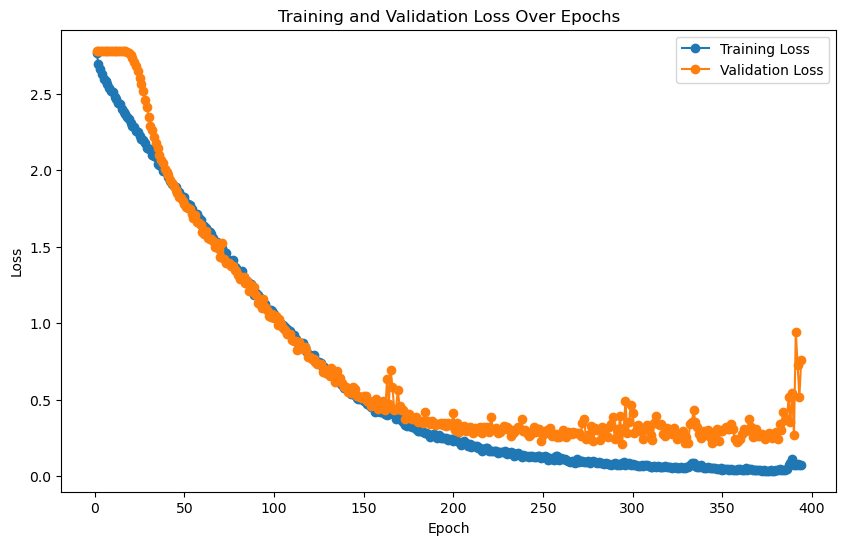

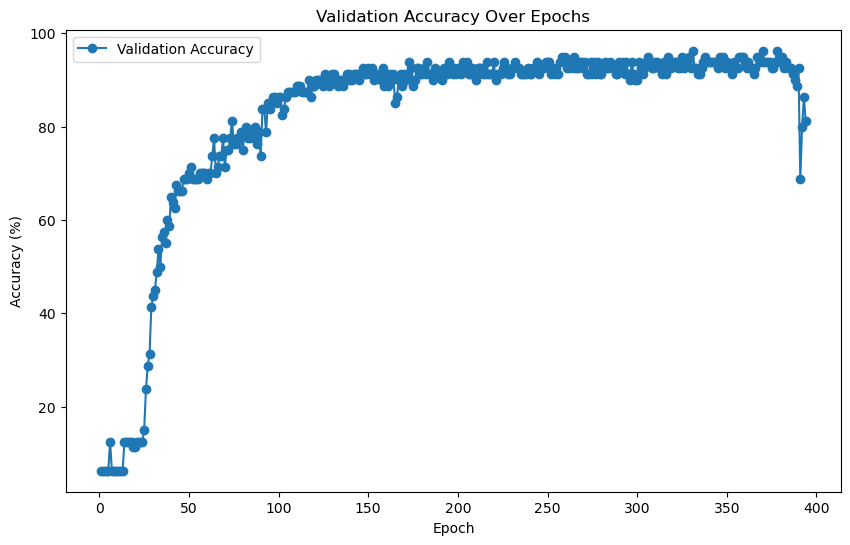


Evaluating on the test set...
    Test Batch [1/209], Loss: 1.1544



Final Test Loss: 0.9794, Test Accuracy: 76.15%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.


  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.
  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.


  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.
  Processed batch 80/209 for test dataset.
  Processed batch 90/209 for test dataset.


  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.
  Processed batch 130/209 for test dataset.


  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.
  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.


  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.
  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)

LOG: Training features shape: (640, 64), Training labels shape: (640,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53409, 64), Test labels shape: (53409,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.40      0.50         5
           8       0.83      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)
Train reps shape: (640, 64)
Train labels shape: (640,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53409, 64)
Test labels shape: (53409,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7745  |  Val Loss: 2.5736
Validation loss improved from inf to 2.5736.
[Epoch 2/1000] Train Loss: 2.4281  |  Val Loss: 2.3193
Validation loss improved from 2.5736 to 2.3193.
[Epoch 3/1000] Train Loss: 2.1828  |  Val Loss: 2.0923
Validation loss improved from 2.3193 to 2.0923.
[Epoch 4/1000] Train Loss: 1.9186  |  Val Loss: 1.8306
Validation loss improved from 2.0923 to 1.8306.
[Epoch 5/1000] Train Loss: 1.6614  |  Val Loss: 1.5779
Validation loss improved from 1.8306 to 1.5779.
[Epoch 6/1000] Train Loss: 1.4100  |  Val Loss: 1.3531
Validation loss improved from 1.5779 to 1.3531.


[Epoch 7/1000] Train Loss: 1.1916  |  Val Loss: 1.1464
Validation loss improved from 1.3531 to 1.1464.
[Epoch 8/1000] Train Loss: 1.0117  |  Val Loss: 0.9927
Validation loss improved from 1.1464 to 0.9927.
[Epoch 9/1000] Train Loss: 0.8642  |  Val Loss: 0.8664
Validation loss improved from 0.9927 to 0.8664.
[Epoch 10/1000] Train Loss: 0.7566  |  Val Loss: 0.8237
Validation loss improved from 0.8664 to 0.8237.


[Epoch 11/1000] Train Loss: 0.6744  |  Val Loss: 0.7410
Validation loss improved from 0.8237 to 0.7410.
[Epoch 12/1000] Train Loss: 0.6026  |  Val Loss: 0.6972
Validation loss improved from 0.7410 to 0.6972.
[Epoch 13/1000] Train Loss: 0.5458  |  Val Loss: 0.6838
Validation loss improved from 0.6972 to 0.6838.
[Epoch 14/1000] Train Loss: 0.5164  |  Val Loss: 0.6622
Validation loss improved from 0.6838 to 0.6622.
[Epoch 15/1000] Train Loss: 0.4684  |  Val Loss: 0.6448
Validation loss improved from 0.6622 to 0.6448.
[Epoch 16/1000] Train Loss: 0.4404  |  Val Loss: 0.6805
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 17/1000] Train Loss: 0.4228  |  Val Loss: 0.6413
Validation loss improved from 0.6448 to 0.6413.
[Epoch 18/1000] Train Loss: 0.3939  |  Val Loss: 0.6589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 19/1000] Train Loss: 0.3700  |  Val Loss: 0.6595
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 20/1000] Train Loss: 0.3443  |  Val Loss: 0.6481
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 21/1000] Train Loss: 0.3293  |  Val Loss: 0.6616
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 22/1000] Train Loss: 0.3246  |  Val Loss: 0.6926
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 23/1000] Train Loss: 0.3152  |  Val Loss: 0.6780
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 24/1000] Train Loss: 0.3018  |  Val Loss: 0.7048
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 25/1000] Train Loss: 0.2789  |  Val Loss: 0.6886
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 26/1000] Train Loss: 0.2733  |  Val Loss: 0.7218
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 27/1000] Train Loss: 0.2688  |  Val Loss: 0.7200
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 28/1000] Train Loss: 0.2521  |  Val Loss: 0.7417
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 29/1000] Train Loss: 0.2484  |  Val Loss: 0.7269
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 30/1000] Train Loss: 0.2451  |  Val Loss: 0.8348
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 31/1000] Train Loss: 0.2427  |  Val Loss: 0.7369
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 32/1000] Train Loss: 0.2390  |  Val Loss: 0.8670
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 33/1000] Train Loss: 0.2421  |  Val Loss: 0.7465
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 34/1000] Train Loss: 0.2218  |  Val Loss: 0.8297
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 35/1000] Train Loss: 0.2112  |  Val Loss: 0.8119
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 36/1000] Train Loss: 0.2076  |  Val Loss: 0.8063
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 37/1000] Train Loss: 0.2056  |  Val Loss: 0.7998
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 38/1000] Train Loss: 0.1928  |  Val Loss: 0.8574
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 39/1000] Train Loss: 0.1884  |  Val Loss: 0.8339
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 40/1000] Train Loss: 0.1831  |  Val Loss: 0.8469
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 41/1000] Train Loss: 0.1767  |  Val Loss: 0.8506
!! Validation loss did NOT improve !! Patience: 24/100


[Epoch 42/1000] Train Loss: 0.1765  |  Val Loss: 0.8652
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 43/1000] Train Loss: 0.1718  |  Val Loss: 0.8765
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 44/1000] Train Loss: 0.1796  |  Val Loss: 0.9016
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 45/1000] Train Loss: 0.1645  |  Val Loss: 0.8847
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 46/1000] Train Loss: 0.1681  |  Val Loss: 0.9062
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 47/1000] Train Loss: 0.1871  |  Val Loss: 1.0012
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 48/1000] Train Loss: 0.1938  |  Val Loss: 0.9356
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 49/1000] Train Loss: 0.1702  |  Val Loss: 0.9233
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 50/1000] Train Loss: 0.1609  |  Val Loss: 0.9616
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 51/1000] Train Loss: 0.1516  |  Val Loss: 0.9825
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 52/1000] Train Loss: 0.1492  |  Val Loss: 0.9608
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 53/1000] Train Loss: 0.1627  |  Val Loss: 0.9746
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 54/1000] Train Loss: 0.1473  |  Val Loss: 0.9712
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 55/1000] Train Loss: 0.1496  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 56/1000] Train Loss: 0.1457  |  Val Loss: 0.9957
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 57/1000] Train Loss: 0.1400  |  Val Loss: 0.9975
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 58/1000] Train Loss: 0.1526  |  Val Loss: 1.0654
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 59/1000] Train Loss: 0.1422  |  Val Loss: 1.0053
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 60/1000] Train Loss: 0.1527  |  Val Loss: 1.0448
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 61/1000] Train Loss: 0.1576  |  Val Loss: 1.0586
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 62/1000] Train Loss: 0.1488  |  Val Loss: 1.0671
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 63/1000] Train Loss: 0.1519  |  Val Loss: 1.0389
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 64/1000] Train Loss: 0.1628  |  Val Loss: 1.0031
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 65/1000] Train Loss: 0.1478  |  Val Loss: 1.0827
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 66/1000] Train Loss: 0.1212  |  Val Loss: 1.0629
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 67/1000] Train Loss: 0.1274  |  Val Loss: 1.0263
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 68/1000] Train Loss: 0.1478  |  Val Loss: 1.0917
!! Validation loss did NOT improve !! Patience: 51/100


[Epoch 69/1000] Train Loss: 0.1255  |  Val Loss: 1.0926
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 70/1000] Train Loss: 0.1167  |  Val Loss: 1.0392
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 71/1000] Train Loss: 0.1189  |  Val Loss: 1.0820
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 72/1000] Train Loss: 0.1265  |  Val Loss: 1.1047
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 73/1000] Train Loss: 0.1241  |  Val Loss: 1.0789
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 74/1000] Train Loss: 0.1202  |  Val Loss: 1.1311
!! Validation loss did NOT improve !! Patience: 57/100


[Epoch 75/1000] Train Loss: 0.1254  |  Val Loss: 1.0804
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 76/1000] Train Loss: 0.1161  |  Val Loss: 1.1386
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 77/1000] Train Loss: 0.1204  |  Val Loss: 1.0901
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 78/1000] Train Loss: 0.1082  |  Val Loss: 1.1312
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 79/1000] Train Loss: 0.1166  |  Val Loss: 1.1230
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 80/1000] Train Loss: 0.1044  |  Val Loss: 1.1660
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 81/1000] Train Loss: 0.1025  |  Val Loss: 1.1444
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 82/1000] Train Loss: 0.1254  |  Val Loss: 1.1302
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 83/1000] Train Loss: 0.1079  |  Val Loss: 1.1547
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 84/1000] Train Loss: 0.1065  |  Val Loss: 1.1573
!! Validation loss did NOT improve !! Patience: 67/100


[Epoch 85/1000] Train Loss: 0.1146  |  Val Loss: 1.1470
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 86/1000] Train Loss: 0.1048  |  Val Loss: 1.1933
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 87/1000] Train Loss: 0.1017  |  Val Loss: 1.1856
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 88/1000] Train Loss: 0.1030  |  Val Loss: 1.2254
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 89/1000] Train Loss: 0.0989  |  Val Loss: 1.1681
!! Validation loss did NOT improve !! Patience: 72/100


[Epoch 90/1000] Train Loss: 0.1038  |  Val Loss: 1.2084
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 91/1000] Train Loss: 0.1001  |  Val Loss: 1.2079
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 92/1000] Train Loss: 0.0964  |  Val Loss: 1.2315
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 93/1000] Train Loss: 0.0916  |  Val Loss: 1.2313
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 94/1000] Train Loss: 0.1031  |  Val Loss: 1.2145
!! Validation loss did NOT improve !! Patience: 77/100


[Epoch 95/1000] Train Loss: 0.0992  |  Val Loss: 1.2036
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 96/1000] Train Loss: 0.0891  |  Val Loss: 1.2876
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 97/1000] Train Loss: 0.0908  |  Val Loss: 1.2113
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 98/1000] Train Loss: 0.0908  |  Val Loss: 1.2588
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 99/1000] Train Loss: 0.0963  |  Val Loss: 1.2649
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 100/1000] Train Loss: 0.0932  |  Val Loss: 1.2438
!! Validation loss did NOT improve !! Patience: 83/100


[Epoch 101/1000] Train Loss: 0.0995  |  Val Loss: 1.2470
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 102/1000] Train Loss: 0.0873  |  Val Loss: 1.2752
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 103/1000] Train Loss: 0.0877  |  Val Loss: 1.2815
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 104/1000] Train Loss: 0.0817  |  Val Loss: 1.2931
!! Validation loss did NOT improve !! Patience: 87/100


[Epoch 105/1000] Train Loss: 0.0864  |  Val Loss: 1.3049
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 106/1000] Train Loss: 0.0948  |  Val Loss: 1.2772
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 107/1000] Train Loss: 0.0805  |  Val Loss: 1.3026
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 108/1000] Train Loss: 0.0799  |  Val Loss: 1.3243
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 109/1000] Train Loss: 0.0831  |  Val Loss: 1.2812
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 110/1000] Train Loss: 0.0820  |  Val Loss: 1.2948
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 111/1000] Train Loss: 0.0886  |  Val Loss: 1.3690
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 112/1000] Train Loss: 0.0817  |  Val Loss: 1.3223
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 113/1000] Train Loss: 0.0844  |  Val Loss: 1.3271
!! Validation loss did NOT improve !! Patience: 96/100


[Epoch 114/1000] Train Loss: 0.0784  |  Val Loss: 1.3512
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 115/1000] Train Loss: 0.0889  |  Val Loss: 1.3229
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 116/1000] Train Loss: 0.0866  |  Val Loss: 1.3421
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 117/1000] Train Loss: 0.0814  |  Val Loss: 1.3701
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 117 !!
No improvement for 100 epochs.


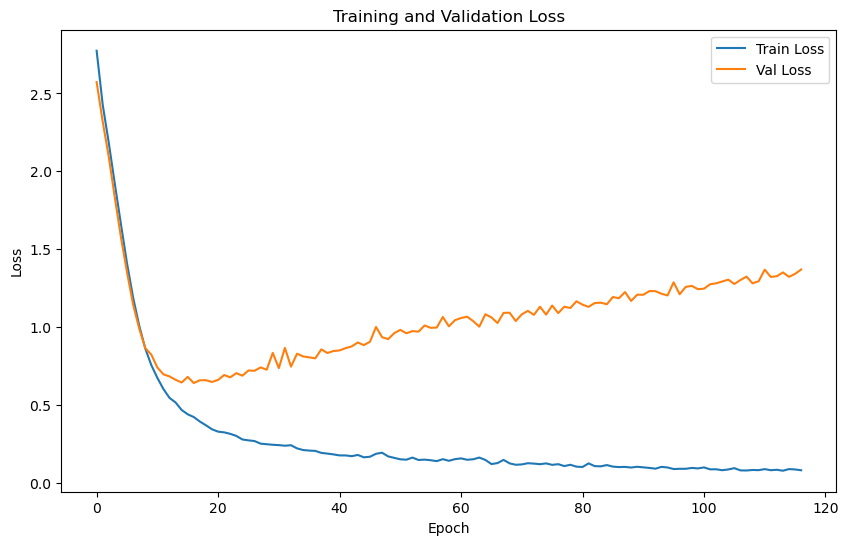

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.6028 | Test Accuracy: 85.77%


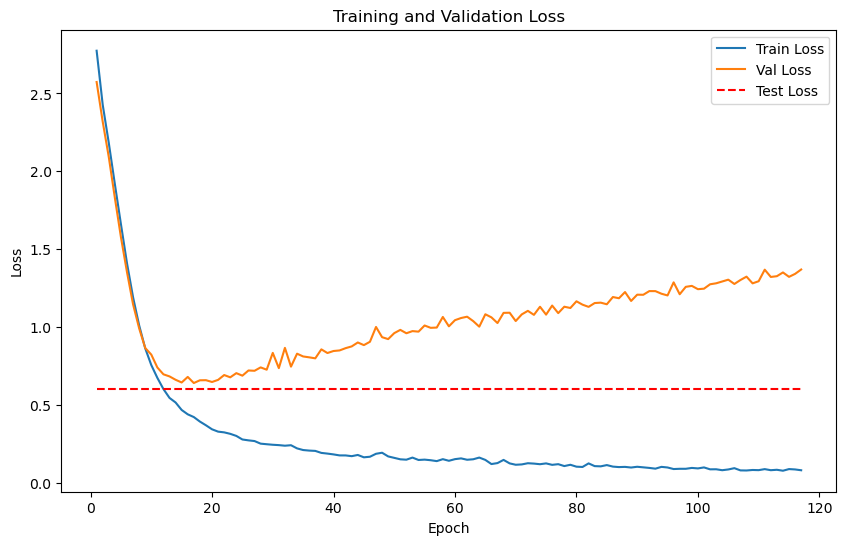

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 8.4935
    Batch [2/2], Train Loss: 8.5233
Epoch [1/2000], Avg Train Loss: 8.5084
Epoch [1/2000], Avg Val Loss: 3.4104
Validation loss improved from inf to 3.4104. Saving model...

LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 8.3092
    Batch [2/2], Train Loss: 8.2023
Epoch [2/2000], Avg Train Loss: 8.2557
Epoch [2/2000], Avg Val Loss: 3.3785
Validation loss improved from 3.4104 to 3.3785. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.0806
    Batch [2/2], Train Loss: 8.0313
Epoch [3/2000], Avg Train Loss: 8.0559
Epoch [3/2000], Avg Val Loss: 3.3483
Validation loss improved from 3.3785 to 3.3483. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.9394
    Batch [2/2], Train Loss: 7.9337
Epoch [4/2000], Avg Train Loss: 7.9366
Epoch [4/2000], Avg Val Loss: 3.3198
Validation loss improved from 3.3483 to 3.3198. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.7602
    Batch [2/2], Train Loss: 7.9261
Epoch [5/2000], Avg Train Loss: 7.8432
Epoch [5/2000], Avg Val Loss: 3.2927
Validation loss improved from 3.3198 to 3.2927. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train L

    Batch [1/2], Train Loss: 7.0739
    Batch [2/2], Train Loss: 6.9691
Epoch [11/2000], Avg Train Loss: 7.0215
Epoch [11/2000], Avg Val Loss: 3.1566
Validation loss improved from 3.1762 to 3.1566. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 7.1367
    Batch [2/2], Train Loss: 7.0073
Epoch [12/2000], Avg Train Loss: 7.0720
Epoch [12/2000], Avg Val Loss: 3.1380
Validation loss improved from 3.1566 to 3.1380. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.8013
    Batch [2/2], Train Loss: 6.8522
Epoch [13/2000], Avg Train Loss: 6.8268
Epoch [13/2000], Avg Val Loss: 3.1205
Validation loss improved from 3.1380 to 3.1205. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.7383
    Batch [2/2], Train Loss: 6.8043
Epoch [14/2000], Avg Train Loss: 6.7713
Epoch [14/2000], Avg Val Loss: 3.1040
Validation loss improved from 3.1205 to 3.1040. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 6.1570
Epoch [22/2000], Avg Train Loss: 6.1456
Epoch [22/2000], Avg Val Loss: 3.0053
Validation loss improved from 3.0152 to 3.0053. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 6.0596
    Batch [2/2], Train Loss: 6.0332
Epoch [23/2000], Avg Train Loss: 6.0464
Epoch [23/2000], Avg Val Loss: 2.9961
Validation loss improved from 3.0053 to 2.9961. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 5.9443
    Batch [2/2], Train Loss: 5.9668
Epoch [24/2000], Avg Train Loss: 5.9556
Epoch [24/2000], Avg Val Loss: 2.9875
Validation loss improved from 2.9961 to 2.9875. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 5.9284
    Batch [2/2], Train Loss: 5.9752
Epoch [25/2000], Avg Train Loss: 5.9518
Epoch [25/2000], Avg Val Loss: 2.9796
Validation loss improved from 2.9875 to 2.9796. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.9653
    Batch [2

    Batch [2/2], Train Loss: 5.5218
Epoch [32/2000], Avg Train Loss: 5.5605
Epoch [32/2000], Avg Val Loss: 2.9381
Validation loss improved from 2.9428 to 2.9381. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.5127
    Batch [2/2], Train Loss: 5.4350
Epoch [33/2000], Avg Train Loss: 5.4738
Epoch [33/2000], Avg Val Loss: 2.9337
Validation loss improved from 2.9381 to 2.9337. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.4470
    Batch [2/2], Train Loss: 5.4405
Epoch [34/2000], Avg Train Loss: 5.4438
Epoch [34/2000], Avg Val Loss: 2.9295
Validation loss improved from 2.9337 to 2.9295. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.4531
    Batch [2/2], Train Loss: 5.3828
Epoch [35/2000], Avg Train Loss: 5.4180
Epoch [35/2000], Avg Val Loss: 2.9255
Validation loss improved from 2.9295 to 2.9255. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.4963
    Batch [2

    Batch [1/2], Train Loss: 5.2568
    Batch [2/2], Train Loss: 5.1583
Epoch [43/2000], Avg Train Loss: 5.2075
Epoch [43/2000], Avg Val Loss: 2.8989
Validation loss improved from 2.9018 to 2.8989. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 5.1887
    Batch [2/2], Train Loss: 5.1340
Epoch [44/2000], Avg Train Loss: 5.1613
Epoch [44/2000], Avg Val Loss: 2.8959
Validation loss improved from 2.8989 to 2.8959. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.1622
    Batch [2/2], Train Loss: 5.0170
Epoch [45/2000], Avg Train Loss: 5.0896
Epoch [45/2000], Avg Val Loss: 2.8928
Validation loss improved from 2.8959 to 2.8928. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.1452
    Batch [2/2], Train Loss: 5.1202
Epoch [46/2000], Avg Train Loss: 5.1327
Epoch [46/2000], Avg Val Loss: 2.8898
Validation loss improved from 2.8928 to 2.8898. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.9706
Epoch [52/2000], Avg Train Loss: 4.9551
Epoch [52/2000], Avg Val Loss: 2.8714
Validation loss improved from 2.8745 to 2.8714. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 4.9973
    Batch [2/2], Train Loss: 5.0220
Epoch [53/2000], Avg Train Loss: 5.0096
Epoch [53/2000], Avg Val Loss: 2.8684
Validation loss improved from 2.8714 to 2.8684. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.9570
    Batch [2/2], Train Loss: 5.0278
Epoch [54/2000], Avg Train Loss: 4.9924
Epoch [54/2000], Avg Val Loss: 2.8655
Validation loss improved from 2.8684 to 2.8655. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.9567
    Batch [2/2], Train Loss: 4.9885
Epoch [55/2000], Avg Train Loss: 4.9726
Epoch [55/2000], Avg Val Loss: 2.8625
Validation loss improved from 2.8655 to 2.8625. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 4.9667
    Batch [2

    Batch [1/2], Train Loss: 4.8867
    Batch [2/2], Train Loss: 4.8710
Epoch [64/2000], Avg Train Loss: 4.8788
Epoch [64/2000], Avg Val Loss: 2.8322
Validation loss improved from 2.8356 to 2.8322. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.8777
    Batch [2/2], Train Loss: 4.8136
Epoch [65/2000], Avg Train Loss: 4.8457
Epoch [65/2000], Avg Val Loss: 2.8289
Validation loss improved from 2.8322 to 2.8289. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 4.8132
    Batch [2/2], Train Loss: 4.7645
Epoch [66/2000], Avg Train Loss: 4.7888
Epoch [66/2000], Avg Val Loss: 2.8254
Validation loss improved from 2.8289 to 2.8254. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 4.8073
    Batch [2/2], Train Loss: 4.7856
Epoch [67/2000], Avg Train Loss: 4.7965
Epoch [67/2000], Avg Val Loss: 2.8218
Validation loss improved from 2.8254 to 2.8218. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.7442
    Batch [2/2], Train Loss: 4.7749
Epoch [74/2000], Avg Train Loss: 4.7595
Epoch [74/2000], Avg Val Loss: 2.7963
Validation loss improved from 2.7999 to 2.7963. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 4.8204
    Batch [2/2], Train Loss: 4.7617
Epoch [75/2000], Avg Train Loss: 4.7911
Epoch [75/2000], Avg Val Loss: 2.7928
Validation loss improved from 2.7963 to 2.7928. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.7547
    Batch [2/2], Train Loss: 4.8003
Epoch [76/2000], Avg Train Loss: 4.7775
Epoch [76/2000], Avg Val Loss: 2.7893
Validation loss improved from 2.7928 to 2.7893. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.7497
    Batch [2/2], Train Loss: 4.8084
Epoch [77/2000], Avg Train Loss: 4.7791
Epoch [77/2000], Avg Val Loss: 2.7859
Validation loss improved from 2.7893 to 2.7859. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.7079
Epoch [82/2000], Avg Train Loss: 4.6775
Epoch [82/2000], Avg Val Loss: 2.7688
Validation loss improved from 2.7722 to 2.7688. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.6957
    Batch [2/2], Train Loss: 4.6634
Epoch [83/2000], Avg Train Loss: 4.6795
Epoch [83/2000], Avg Val Loss: 2.7654
Validation loss improved from 2.7688 to 2.7654. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 4.6683
    Batch [2/2], Train Loss: 4.6549
Epoch [84/2000], Avg Train Loss: 4.6616
Epoch [84/2000], Avg Val Loss: 2.7619
Validation loss improved from 2.7654 to 2.7619. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 4.6507
    Batch [2/2], Train Loss: 4.7061
Epoch [85/2000], Avg Train Loss: 4.6784
Epoch [85/2000], Avg Val Loss: 2.7585
Validation loss improved from 2.7619 to 2.7585. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 4.6181
    Batch [2

    Batch [2/2], Train Loss: 4.5755
Epoch [93/2000], Avg Train Loss: 4.5957
Epoch [93/2000], Avg Val Loss: 2.7311
Validation loss improved from 2.7346 to 2.7311. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 4.6123
    Batch [2/2], Train Loss: 4.6214
Epoch [94/2000], Avg Train Loss: 4.6168
Epoch [94/2000], Avg Val Loss: 2.7278
Validation loss improved from 2.7311 to 2.7278. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 4.6108
    Batch [2/2], Train Loss: 4.6236
Epoch [95/2000], Avg Train Loss: 4.6172
Epoch [95/2000], Avg Val Loss: 2.7245
Validation loss improved from 2.7278 to 2.7245. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 4.6138
    Batch [2/2], Train Loss: 4.5732
Epoch [96/2000], Avg Train Loss: 4.5935
Epoch [96/2000], Avg Val Loss: 2.7213
Validation loss improved from 2.7245 to 2.7213. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 4.6036
    Batch [2

Epoch [100/2000], Avg Val Loss: 2.7093
Validation loss improved from 2.7123 to 2.7093. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 4.5423
    Batch [2/2], Train Loss: 4.5964
Epoch [101/2000], Avg Train Loss: 4.5694
Epoch [101/2000], Avg Val Loss: 2.7063
Validation loss improved from 2.7093 to 2.7063. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.5283
    Batch [2/2], Train Loss: 4.5971
Epoch [102/2000], Avg Train Loss: 4.5627
Epoch [102/2000], Avg Val Loss: 2.7034
Validation loss improved from 2.7063 to 2.7034. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 4.5154
    Batch [2/2], Train Loss: 4.5681
Epoch [103/2000], Avg Train Loss: 4.5417
Epoch [103/2000], Avg Val Loss: 2.7004
Validation loss improved from 2.7034 to 2.7004. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 4.5588
    Batch [2/2], Train Loss: 4.5274
Epoch [104/2000], Avg Train Loss: 4.5431


    Batch [1/2], Train Loss: 4.5035
    Batch [2/2], Train Loss: 4.4716
Epoch [115/2000], Avg Train Loss: 4.4875
Epoch [115/2000], Avg Val Loss: 2.6680
Validation loss improved from 2.6705 to 2.6680. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.5070
    Batch [2/2], Train Loss: 4.4152
Epoch [116/2000], Avg Train Loss: 4.4611
Epoch [116/2000], Avg Val Loss: 2.6656
Validation loss improved from 2.6680 to 2.6656. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 4.4813
    Batch [2/2], Train Loss: 4.4556
Epoch [117/2000], Avg Train Loss: 4.4685
Epoch [117/2000], Avg Val Loss: 2.6631
Validation loss improved from 2.6656 to 2.6631. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 4.4482
    Batch [2/2], Train Loss: 4.5045
Epoch [118/2000], Avg Train Loss: 4.4764
Epoch [118/2000], Avg Val Loss: 2.6606
Validation loss improved from 2.6631 to 2.6606. Saving model...

LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 4.4342
    Batch [2/2], Train Loss: 4.4086
Epoch [122/2000], Avg Train Loss: 4.4214
Epoch [122/2000], Avg Val Loss: 2.6513
Validation loss improved from 2.6535 to 2.6513. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 4.4883
    Batch [2/2], Train Loss: 4.4785
Epoch [123/2000], Avg Train Loss: 4.4834
Epoch [123/2000], Avg Val Loss: 2.6490
Validation loss improved from 2.6513 to 2.6490. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 4.4094
    Batch [2/2], Train Loss: 4.4879
Epoch [124/2000], Avg Train Loss: 4.4486
Epoch [124/2000], Avg Val Loss: 2.6468
Validation loss improved from 2.6490 to 2.6468. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 4.4213
    Batch [2/2], Train Loss: 4.4493
Epoch [125/2000], Avg Train Loss: 4.4353
Epoch [125/2000], Avg Val Loss: 2.6447
Validation loss improved from 2.6468 to 2.6447. Saving model...

LOG: Epoch [126/2000] - Training


    Batch [2/2], Train Loss: 4.4021
Epoch [134/2000], Avg Train Loss: 4.3721
Epoch [134/2000], Avg Val Loss: 2.6271
Validation loss improved from 2.6290 to 2.6271. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.4494
    Batch [2/2], Train Loss: 4.4484
Epoch [135/2000], Avg Train Loss: 4.4489
Epoch [135/2000], Avg Val Loss: 2.6252
Validation loss improved from 2.6271 to 2.6252. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.3982
    Batch [2/2], Train Loss: 4.3516
Epoch [136/2000], Avg Train Loss: 4.3749
Epoch [136/2000], Avg Val Loss: 2.6233
Validation loss improved from 2.6252 to 2.6233. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.3504
    Batch [2/2], Train Loss: 4.3884
Epoch [137/2000], Avg Train Loss: 4.3694
Epoch [137/2000], Avg Val Loss: 2.6215
Validation loss improved from 2.6233 to 2.6215. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 4.3499


    Batch [1/2], Train Loss: 4.3559
    Batch [2/2], Train Loss: 4.3797
Epoch [141/2000], Avg Train Loss: 4.3678
Epoch [141/2000], Avg Val Loss: 2.6149
Validation loss improved from 2.6165 to 2.6149. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 4.3344
    Batch [2/2], Train Loss: 4.3452
Epoch [142/2000], Avg Train Loss: 4.3398
Epoch [142/2000], Avg Val Loss: 2.6133
Validation loss improved from 2.6149 to 2.6133. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.4330
    Batch [2/2], Train Loss: 4.3683
Epoch [143/2000], Avg Train Loss: 4.4006
Epoch [143/2000], Avg Val Loss: 2.6118
Validation loss improved from 2.6133 to 2.6118. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.4046
    Batch [2/2], Train Loss: 4.2987
Epoch [144/2000], Avg Train Loss: 4.3516
Epoch [144/2000], Avg Val Loss: 2.6103
Validation loss improved from 2.6118 to 2.6103. Saving model...

LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 4.3338
    Batch [2/2], Train Loss: 4.2911
Epoch [154/2000], Avg Train Loss: 4.3124
Epoch [154/2000], Avg Val Loss: 2.5962
Validation loss improved from 2.5976 to 2.5962. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 4.3011
    Batch [2/2], Train Loss: 4.2943
Epoch [155/2000], Avg Train Loss: 4.2977
Epoch [155/2000], Avg Val Loss: 2.5948
Validation loss improved from 2.5962 to 2.5948. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 4.3661
    Batch [2/2], Train Loss: 4.3708
Epoch [156/2000], Avg Train Loss: 4.3685
Epoch [156/2000], Avg Val Loss: 2.5935
Validation loss improved from 2.5948 to 2.5935. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.2870
    Batch [2/2], Train Loss: 4.2966
Epoch [157/2000], Avg Train Loss: 4.2918
Epoch [157/2000], Avg Val Loss: 2.5923
Validation loss improved from 2.5935 to 2.5923. Saving model...

LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 4.3084
    Batch [2/2], Train Loss: 4.3113
Epoch [160/2000], Avg Train Loss: 4.3099
Epoch [160/2000], Avg Val Loss: 2.5887
Validation loss improved from 2.5900 to 2.5887. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 4.2973
    Batch [2/2], Train Loss: 4.2608
Epoch [161/2000], Avg Train Loss: 4.2790
Epoch [161/2000], Avg Val Loss: 2.5876
Validation loss improved from 2.5887 to 2.5876. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 4.2953
    Batch [2/2], Train Loss: 4.3077
Epoch [162/2000], Avg Train Loss: 4.3015
Epoch [162/2000], Avg Val Loss: 2.5865
Validation loss improved from 2.5876 to 2.5865. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 4.3073
    Batch [2/2], Train Loss: 4.2769
Epoch [163/2000], Avg Train Loss: 4.2921
Epoch [163/2000], Avg Val Loss: 2.5853
Validation loss improved from 2.5865 to 2.5853. Saving model...

LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 4.2487
    Batch [2/2], Train Loss: 4.2666
Epoch [174/2000], Avg Train Loss: 4.2577
Epoch [174/2000], Avg Val Loss: 2.5731
Validation loss improved from 2.5742 to 2.5731. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 4.2286
    Batch [2/2], Train Loss: 4.2958
Epoch [175/2000], Avg Train Loss: 4.2622
Epoch [175/2000], Avg Val Loss: 2.5721
Validation loss improved from 2.5731 to 2.5721. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.2119
    Batch [2/2], Train Loss: 4.1999
Epoch [176/2000], Avg Train Loss: 4.2059
Epoch [176/2000], Avg Val Loss: 2.5711
Validation loss improved from 2.5721 to 2.5711. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.2296
    Batch [2/2], Train Loss: 4.2737
Epoch [177/2000], Avg Train Loss: 4.2516
Epoch [177/2000], Avg Val Loss: 2.5701
Validation loss improved from 2.5711 to 2.5701. Saving model...

LOG: Epoch [178/2000] - Training


    Batch [2/2], Train Loss: 4.2085
Epoch [180/2000], Avg Train Loss: 4.2111
Epoch [180/2000], Avg Val Loss: 2.5674
Validation loss improved from 2.5683 to 2.5674. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 4.1985
    Batch [2/2], Train Loss: 4.1807
Epoch [181/2000], Avg Train Loss: 4.1896
Epoch [181/2000], Avg Val Loss: 2.5664
Validation loss improved from 2.5674 to 2.5664. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 4.1537
    Batch [2/2], Train Loss: 4.1877
Epoch [182/2000], Avg Train Loss: 4.1707
Epoch [182/2000], Avg Val Loss: 2.5653
Validation loss improved from 2.5664 to 2.5653. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 4.2284
    Batch [2/2], Train Loss: 4.2514
Epoch [183/2000], Avg Train Loss: 4.2399
Epoch [183/2000], Avg Val Loss: 2.5642
Validation loss improved from 2.5653 to 2.5642. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 4.2614


Epoch [195/2000], Avg Train Loss: 4.1814
Epoch [195/2000], Avg Val Loss: 2.5515
Validation loss improved from 2.5523 to 2.5515. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 4.1548
    Batch [2/2], Train Loss: 4.2352
Epoch [196/2000], Avg Train Loss: 4.1950
Epoch [196/2000], Avg Val Loss: 2.5508
Validation loss improved from 2.5515 to 2.5508. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 4.1330
    Batch [2/2], Train Loss: 4.1894
Epoch [197/2000], Avg Train Loss: 4.1612
Epoch [197/2000], Avg Val Loss: 2.5502
Validation loss improved from 2.5508 to 2.5502. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 4.1892
    Batch [2/2], Train Loss: 4.2312
Epoch [198/2000], Avg Train Loss: 4.2102
Epoch [198/2000], Avg Val Loss: 2.5495
Validation loss improved from 2.5502 to 2.5495. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.1731
    Batch [2/2], Train Loss: 4.1781


    Batch [1/2], Train Loss: 4.1564
    Batch [2/2], Train Loss: 4.1649
Epoch [203/2000], Avg Train Loss: 4.1607
Epoch [203/2000], Avg Val Loss: 2.5469
Validation loss improved from 2.5475 to 2.5469. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 4.1645
    Batch [2/2], Train Loss: 4.1090
Epoch [204/2000], Avg Train Loss: 4.1367
Epoch [204/2000], Avg Val Loss: 2.5462
Validation loss improved from 2.5469 to 2.5462. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 4.2105
    Batch [2/2], Train Loss: 4.1522
Epoch [205/2000], Avg Train Loss: 4.1814
Epoch [205/2000], Avg Val Loss: 2.5456
Validation loss improved from 2.5462 to 2.5456. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 4.1887
    Batch [2/2], Train Loss: 4.1450
Epoch [206/2000], Avg Train Loss: 4.1669
Epoch [206/2000], Avg Val Loss: 2.5451
Validation loss improved from 2.5456 to 2.5451. Saving model...

LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 4.1097
    Batch [2/2], Train Loss: 4.1103
Epoch [215/2000], Avg Train Loss: 4.1100
Epoch [215/2000], Avg Val Loss: 2.5380
Validation loss improved from 2.5386 to 2.5380. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 4.1562
    Batch [2/2], Train Loss: 4.1061
Epoch [216/2000], Avg Train Loss: 4.1312
Epoch [216/2000], Avg Val Loss: 2.5374
Validation loss improved from 2.5380 to 2.5374. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 4.1440
    Batch [2/2], Train Loss: 4.1233
Epoch [217/2000], Avg Train Loss: 4.1336
Epoch [217/2000], Avg Val Loss: 2.5368
Validation loss improved from 2.5374 to 2.5368. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.1696
    Batch [2/2], Train Loss: 4.1159
Epoch [218/2000], Avg Train Loss: 4.1427
Epoch [218/2000], Avg Val Loss: 2.5362
Validation loss improved from 2.5368 to 2.5362. Saving model...

LOG: Epoch [219/2000] - Training


Epoch [224/2000], Avg Val Loss: 2.5327
Validation loss improved from 2.5332 to 2.5327. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 4.1349
    Batch [2/2], Train Loss: 4.0999
Epoch [225/2000], Avg Train Loss: 4.1174
Epoch [225/2000], Avg Val Loss: 2.5323
Validation loss improved from 2.5327 to 2.5323. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 4.1100
    Batch [2/2], Train Loss: 4.0971
Epoch [226/2000], Avg Train Loss: 4.1036
Epoch [226/2000], Avg Val Loss: 2.5318
Validation loss improved from 2.5323 to 2.5318. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 4.1444
    Batch [2/2], Train Loss: 4.1134
Epoch [227/2000], Avg Train Loss: 4.1289
Epoch [227/2000], Avg Val Loss: 2.5313
Validation loss improved from 2.5318 to 2.5313. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 4.1021
    Batch [2/2], Train Loss: 4.0707
Epoch [228/2000], Avg Train Loss: 4.0864


Epoch [235/2000], Avg Val Loss: 2.5262
Validation loss improved from 2.5270 to 2.5262. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 4.0757
    Batch [2/2], Train Loss: 4.0941
Epoch [236/2000], Avg Train Loss: 4.0849
Epoch [236/2000], Avg Val Loss: 2.5257
Validation loss improved from 2.5262 to 2.5257. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 4.0872
    Batch [2/2], Train Loss: 4.1096
Epoch [237/2000], Avg Train Loss: 4.0984
Epoch [237/2000], Avg Val Loss: 2.5251
Validation loss improved from 2.5257 to 2.5251. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 4.0586
    Batch [2/2], Train Loss: 4.0444
Epoch [238/2000], Avg Train Loss: 4.0515
Epoch [238/2000], Avg Val Loss: 2.5246
Validation loss improved from 2.5251 to 2.5246. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 4.0558
    Batch [2/2], Train Loss: 4.0999
Epoch [239/2000], Avg Train Loss: 4.0778


    Batch [1/2], Train Loss: 4.1071
    Batch [2/2], Train Loss: 4.0782
Epoch [246/2000], Avg Train Loss: 4.0927
Epoch [246/2000], Avg Val Loss: 2.5203
Validation loss improved from 2.5209 to 2.5203. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 4.1127
    Batch [2/2], Train Loss: 4.0985
Epoch [247/2000], Avg Train Loss: 4.1056
Epoch [247/2000], Avg Val Loss: 2.5196
Validation loss improved from 2.5203 to 2.5196. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 4.0488
    Batch [2/2], Train Loss: 4.0486
Epoch [248/2000], Avg Train Loss: 4.0487
Epoch [248/2000], Avg Val Loss: 2.5189
Validation loss improved from 2.5196 to 2.5189. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 4.0684
    Batch [2/2], Train Loss: 4.0619
Epoch [249/2000], Avg Train Loss: 4.0651
Epoch [249/2000], Avg Val Loss: 2.5183
Validation loss improved from 2.5189 to 2.5183. Saving model...

LOG: Epoch [250/2000] - Training


    Batch [2/2], Train Loss: 4.0103
Epoch [256/2000], Avg Train Loss: 4.0341
Epoch [256/2000], Avg Val Loss: 2.5133
Validation loss improved from 2.5140 to 2.5133. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 4.0530
    Batch [2/2], Train Loss: 4.0569
Epoch [257/2000], Avg Train Loss: 4.0549
Epoch [257/2000], Avg Val Loss: 2.5126
Validation loss improved from 2.5133 to 2.5126. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 4.0056
    Batch [2/2], Train Loss: 4.0248
Epoch [258/2000], Avg Train Loss: 4.0152
Epoch [258/2000], Avg Val Loss: 2.5119
Validation loss improved from 2.5126 to 2.5119. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 4.0523
    Batch [2/2], Train Loss: 4.0866
Epoch [259/2000], Avg Train Loss: 4.0694
Epoch [259/2000], Avg Val Loss: 2.5114
Validation loss improved from 2.5119 to 2.5114. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 4.0590


Epoch [267/2000], Avg Val Loss: 2.5073
Validation loss improved from 2.5077 to 2.5073. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.0764
    Batch [2/2], Train Loss: 4.0131
Epoch [268/2000], Avg Train Loss: 4.0447
Epoch [268/2000], Avg Val Loss: 2.5070
Validation loss improved from 2.5073 to 2.5070. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 4.0220
    Batch [2/2], Train Loss: 4.0282
Epoch [269/2000], Avg Train Loss: 4.0251
Epoch [269/2000], Avg Val Loss: 2.5067
Validation loss improved from 2.5070 to 2.5067. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 4.0197
    Batch [2/2], Train Loss: 3.9801
Epoch [270/2000], Avg Train Loss: 3.9999
Epoch [270/2000], Avg Val Loss: 2.5065
Validation loss improved from 2.5067 to 2.5065. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 4.0231
    Batch [2/2], Train Loss: 3.9907
Epoch [271/2000], Avg Train Loss: 4.0069


    Batch [2/2], Train Loss: 4.0091
Epoch [279/2000], Avg Train Loss: 3.9837
Epoch [279/2000], Avg Val Loss: 2.5043
Validation loss improved from 2.5045 to 2.5043. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 3.9737
    Batch [2/2], Train Loss: 4.0289
Epoch [280/2000], Avg Train Loss: 4.0013
Epoch [280/2000], Avg Val Loss: 2.5042
Validation loss improved from 2.5043 to 2.5042. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 4.0230
    Batch [2/2], Train Loss: 4.0290
Epoch [281/2000], Avg Train Loss: 4.0260
Epoch [281/2000], Avg Val Loss: 2.5040
Validation loss improved from 2.5042 to 2.5040. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 3.9992
    Batch [2/2], Train Loss: 3.9579
Epoch [282/2000], Avg Train Loss: 3.9785
Epoch [282/2000], Avg Val Loss: 2.5038
Validation loss improved from 2.5040 to 2.5038. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 4.0412


    Batch [1/2], Train Loss: 4.0149
    Batch [2/2], Train Loss: 3.9564
Epoch [291/2000], Avg Train Loss: 3.9857
Epoch [291/2000], Avg Val Loss: 2.5003
Validation loss improved from 2.5009 to 2.5003. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 3.9286
    Batch [2/2], Train Loss: 3.9747
Epoch [292/2000], Avg Train Loss: 3.9516
Epoch [292/2000], Avg Val Loss: 2.5000
Validation loss improved from 2.5003 to 2.5000. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 3.9660
    Batch [2/2], Train Loss: 4.0046
Epoch [293/2000], Avg Train Loss: 3.9853
Epoch [293/2000], Avg Val Loss: 2.4995
Validation loss improved from 2.5000 to 2.4995. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 4.0147
    Batch [2/2], Train Loss: 3.9405
Epoch [294/2000], Avg Train Loss: 3.9776
Epoch [294/2000], Avg Val Loss: 2.4990
Validation loss improved from 2.4995 to 2.4990. Saving model...

LOG: Epoch [295/2000] - Training


    Batch [2/2], Train Loss: 3.9299
Epoch [301/2000], Avg Train Loss: 3.9336
Epoch [301/2000], Avg Val Loss: 2.4961
Validation loss improved from 2.4964 to 2.4961. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 3.9895
    Batch [2/2], Train Loss: 3.9931
Epoch [302/2000], Avg Train Loss: 3.9913
Epoch [302/2000], Avg Val Loss: 2.4956
Validation loss improved from 2.4961 to 2.4956. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 3.9446
    Batch [2/2], Train Loss: 3.9172
Epoch [303/2000], Avg Train Loss: 3.9309
Epoch [303/2000], Avg Val Loss: 2.4951
Validation loss improved from 2.4956 to 2.4951. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 3.9211
    Batch [2/2], Train Loss: 3.9545
Epoch [304/2000], Avg Train Loss: 3.9378
Epoch [304/2000], Avg Val Loss: 2.4947
Validation loss improved from 2.4951 to 2.4947. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 3.9487


    Batch [1/2], Train Loss: 3.9422
    Batch [2/2], Train Loss: 3.9514
Epoch [312/2000], Avg Train Loss: 3.9468
Epoch [312/2000], Avg Val Loss: 2.4925
Validation loss improved from 2.4930 to 2.4925. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 3.9186
    Batch [2/2], Train Loss: 3.9298
Epoch [313/2000], Avg Train Loss: 3.9242
Epoch [313/2000], Avg Val Loss: 2.4922
Validation loss improved from 2.4925 to 2.4922. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 3.9024
    Batch [2/2], Train Loss: 3.9676
Epoch [314/2000], Avg Train Loss: 3.9350
Epoch [314/2000], Avg Val Loss: 2.4920
Validation loss improved from 2.4922 to 2.4920. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 3.9196
    Batch [2/2], Train Loss: 3.9290
Epoch [315/2000], Avg Train Loss: 3.9243
Epoch [315/2000], Avg Val Loss: 2.4919
Validation loss improved from 2.4920 to 2.4919. Saving model...

LOG: Epoch [316/2000] - Training


Epoch [323/2000], Avg Val Loss: 2.4921
Validation loss did not improve. Patience: 8/100

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 3.9924
    Batch [2/2], Train Loss: 3.9101
Epoch [324/2000], Avg Train Loss: 3.9513
Epoch [324/2000], Avg Val Loss: 2.4921
Validation loss did not improve. Patience: 9/100

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 3.9287
    Batch [2/2], Train Loss: 3.9004
Epoch [325/2000], Avg Train Loss: 3.9146
Epoch [325/2000], Avg Val Loss: 2.4920
Validation loss did not improve. Patience: 10/100

LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 3.9583
    Batch [2/2], Train Loss: 3.9521
Epoch [326/2000], Avg Train Loss: 3.9552
Epoch [326/2000], Avg Val Loss: 2.4916
Validation loss improved from 2.4919 to 2.4916. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 3.9597
    Batch [2/2], Train Loss: 3.9146
Epoch [327/2000], Avg Train Loss: 3.9371
Epoch [327/2000], Avg Val Loss: 2.4911
Valid

    Batch [1/2], Train Loss: 3.9134
    Batch [2/2], Train Loss: 3.9458
Epoch [332/2000], Avg Train Loss: 3.9296
Epoch [332/2000], Avg Val Loss: 2.4870
Validation loss improved from 2.4877 to 2.4870. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 3.9474
    Batch [2/2], Train Loss: 3.9433
Epoch [333/2000], Avg Train Loss: 3.9454
Epoch [333/2000], Avg Val Loss: 2.4863
Validation loss improved from 2.4870 to 2.4863. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 3.9176
    Batch [2/2], Train Loss: 3.9377
Epoch [334/2000], Avg Train Loss: 3.9276
Epoch [334/2000], Avg Val Loss: 2.4858
Validation loss improved from 2.4863 to 2.4858. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 3.8864
    Batch [2/2], Train Loss: 3.9150
Epoch [335/2000], Avg Train Loss: 3.9007
Epoch [335/2000], Avg Val Loss: 2.4854
Validation loss improved from 2.4858 to 2.4854. Saving model...

LOG: Epoch [336/2000] - Training


    Batch [2/2], Train Loss: 3.8536
Epoch [345/2000], Avg Train Loss: 3.8974
Epoch [345/2000], Avg Val Loss: 2.4820
Validation loss improved from 2.4825 to 2.4820. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 3.8872
    Batch [2/2], Train Loss: 3.8872
Epoch [346/2000], Avg Train Loss: 3.8872
Epoch [346/2000], Avg Val Loss: 2.4815
Validation loss improved from 2.4820 to 2.4815. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 3.9061
    Batch [2/2], Train Loss: 3.8856
Epoch [347/2000], Avg Train Loss: 3.8959
Epoch [347/2000], Avg Val Loss: 2.4811
Validation loss improved from 2.4815 to 2.4811. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 3.8650
    Batch [2/2], Train Loss: 3.8902
Epoch [348/2000], Avg Train Loss: 3.8776
Epoch [348/2000], Avg Val Loss: 2.4806
Validation loss improved from 2.4811 to 2.4806. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 3.9938


    Batch [1/2], Train Loss: 3.9016
    Batch [2/2], Train Loss: 3.8525
Epoch [353/2000], Avg Train Loss: 3.8770
Epoch [353/2000], Avg Val Loss: 2.4775
Validation loss improved from 2.4784 to 2.4775. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 3.8676
    Batch [2/2], Train Loss: 3.8712
Epoch [354/2000], Avg Train Loss: 3.8694
Epoch [354/2000], Avg Val Loss: 2.4769
Validation loss improved from 2.4775 to 2.4769. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 3.8439
    Batch [2/2], Train Loss: 3.8889
Epoch [355/2000], Avg Train Loss: 3.8664
Epoch [355/2000], Avg Val Loss: 2.4765
Validation loss improved from 2.4769 to 2.4765. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 3.8951
    Batch [2/2], Train Loss: 3.9039
Epoch [356/2000], Avg Train Loss: 3.8995
Epoch [356/2000], Avg Val Loss: 2.4762
Validation loss improved from 2.4765 to 2.4762. Saving model...

LOG: Epoch [357/2000] - Training


    Batch [2/2], Train Loss: 3.8440
Epoch [367/2000], Avg Train Loss: 3.8577
Epoch [367/2000], Avg Val Loss: 2.4749
Validation loss did not improve. Patience: 3/100

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.8373
    Batch [2/2], Train Loss: 3.8902
Epoch [368/2000], Avg Train Loss: 3.8637
Epoch [368/2000], Avg Val Loss: 2.4748
Validation loss did not improve. Patience: 4/100

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.8583
    Batch [2/2], Train Loss: 3.8586
Epoch [369/2000], Avg Train Loss: 3.8584
Epoch [369/2000], Avg Val Loss: 2.4744
Validation loss improved from 2.4746 to 2.4744. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.8807
    Batch [2/2], Train Loss: 3.8739
Epoch [370/2000], Avg Train Loss: 3.8773
Epoch [370/2000], Avg Val Loss: 2.4738
Validation loss improved from 2.4744 to 2.4738. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.9068
    Batch [2/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.8752
    Batch [2/2], Train Loss: 3.8918
Epoch [374/2000], Avg Train Loss: 3.8835
Epoch [374/2000], Avg Val Loss: 2.4709
Validation loss improved from 2.4716 to 2.4709. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 3.8783
    Batch [2/2], Train Loss: 3.7906
Epoch [375/2000], Avg Train Loss: 3.8345
Epoch [375/2000], Avg Val Loss: 2.4702
Validation loss improved from 2.4709 to 2.4702. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 3.8781
    Batch [2/2], Train Loss: 3.8640
Epoch [376/2000], Avg Train Loss: 3.8710
Epoch [376/2000], Avg Val Loss: 2.4697
Validation loss improved from 2.4702 to 2.4697. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 3.8387
    Batch [2/2], Train Loss: 3.8868
Epoch [377/2000], Avg Train Loss: 3.8628
Epoch [377/2000], Avg Val Loss: 2.4695
Validation loss improved from 2.4697 to 2.4695. Saving model...

LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 3.8747
    Batch [2/2], Train Loss: 3.8468
Epoch [390/2000], Avg Train Loss: 3.8608
Epoch [390/2000], Avg Val Loss: 2.4671
Validation loss improved from 2.4673 to 2.4671. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 3.8217
    Batch [2/2], Train Loss: 3.8288
Epoch [391/2000], Avg Train Loss: 3.8252
Epoch [391/2000], Avg Val Loss: 2.4670
Validation loss improved from 2.4671 to 2.4670. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 3.8850
    Batch [2/2], Train Loss: 3.8003
Epoch [392/2000], Avg Train Loss: 3.8427
Epoch [392/2000], Avg Val Loss: 2.4669
Validation loss improved from 2.4670 to 2.4669. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 3.8207
    Batch [2/2], Train Loss: 3.8386
Epoch [393/2000], Avg Train Loss: 3.8296
Epoch [393/2000], Avg Val Loss: 2.4668
Validation loss improved from 2.4669 to 2.4668. Saving model...

LOG: Epoch [394/2000] - Training


    Batch [2/2], Train Loss: 3.8055
Epoch [395/2000], Avg Train Loss: 3.8208
Epoch [395/2000], Avg Val Loss: 2.4654
Validation loss improved from 2.4663 to 2.4654. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 3.8085
    Batch [2/2], Train Loss: 3.7758
Epoch [396/2000], Avg Train Loss: 3.7922
Epoch [396/2000], Avg Val Loss: 2.4645
Validation loss improved from 2.4654 to 2.4645. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 3.8507
    Batch [2/2], Train Loss: 3.8724
Epoch [397/2000], Avg Train Loss: 3.8615
Epoch [397/2000], Avg Val Loss: 2.4637
Validation loss improved from 2.4645 to 2.4637. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 3.8204
    Batch [2/2], Train Loss: 3.8236
Epoch [398/2000], Avg Train Loss: 3.8220
Epoch [398/2000], Avg Val Loss: 2.4630
Validation loss improved from 2.4637 to 2.4630. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 3.8757


Epoch [409/2000], Avg Val Loss: 2.4601
Validation loss did not improve. Patience: 3/100

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 3.7937
    Batch [2/2], Train Loss: 3.8245
Epoch [410/2000], Avg Train Loss: 3.8091
Epoch [410/2000], Avg Val Loss: 2.4605
Validation loss did not improve. Patience: 4/100

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 3.8329
    Batch [2/2], Train Loss: 3.8030
Epoch [411/2000], Avg Train Loss: 3.8180
Epoch [411/2000], Avg Val Loss: 2.4607
Validation loss did not improve. Patience: 5/100

LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 3.8172
    Batch [2/2], Train Loss: 3.8034
Epoch [412/2000], Avg Train Loss: 3.8103
Epoch [412/2000], Avg Val Loss: 2.4606
Validation loss did not improve. Patience: 6/100

LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 3.8507
    Batch [2/2], Train Loss: 3.7919
Epoch [413/2000], Avg Train Loss: 3.8213
Epoch [413/2000], Avg Val Loss: 2.4605
Validation loss did n

    Batch [1/2], Train Loss: 3.7961
    Batch [2/2], Train Loss: 3.7773
Epoch [417/2000], Avg Train Loss: 3.7867
Epoch [417/2000], Avg Val Loss: 2.4588
Validation loss improved from 2.4592 to 2.4588. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 3.7818
    Batch [2/2], Train Loss: 3.8223
Epoch [418/2000], Avg Train Loss: 3.8021
Epoch [418/2000], Avg Val Loss: 2.4584
Validation loss improved from 2.4588 to 2.4584. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 3.8699
    Batch [2/2], Train Loss: 3.8360
Epoch [419/2000], Avg Train Loss: 3.8530
Epoch [419/2000], Avg Val Loss: 2.4580
Validation loss improved from 2.4584 to 2.4580. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 3.8308
    Batch [2/2], Train Loss: 3.8196
Epoch [420/2000], Avg Train Loss: 3.8252
Epoch [420/2000], Avg Val Loss: 2.4575
Validation loss improved from 2.4580 to 2.4575. Saving model...

LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 3.7787
    Batch [2/2], Train Loss: 3.8250
Epoch [430/2000], Avg Train Loss: 3.8019
Epoch [430/2000], Avg Val Loss: 2.4542
Validation loss improved from 2.4547 to 2.4542. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 3.7897
    Batch [2/2], Train Loss: 3.7847
Epoch [431/2000], Avg Train Loss: 3.7872
Epoch [431/2000], Avg Val Loss: 2.4539
Validation loss improved from 2.4542 to 2.4539. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 3.7816
    Batch [2/2], Train Loss: 3.7907
Epoch [432/2000], Avg Train Loss: 3.7862
Epoch [432/2000], Avg Val Loss: 2.4537
Validation loss improved from 2.4539 to 2.4537. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 3.8177
    Batch [2/2], Train Loss: 3.7568
Epoch [433/2000], Avg Train Loss: 3.7873
Epoch [433/2000], Avg Val Loss: 2.4537
Validation loss improved from 2.4537 to 2.4537. Saving model...

LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 3.7858
    Batch [2/2], Train Loss: 3.7836
Epoch [438/2000], Avg Train Loss: 3.7847
Epoch [438/2000], Avg Val Loss: 2.4548
Validation loss did not improve. Patience: 5/100

LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 3.7936
    Batch [2/2], Train Loss: 3.7596
Epoch [439/2000], Avg Train Loss: 3.7766
Epoch [439/2000], Avg Val Loss: 2.4550
Validation loss did not improve. Patience: 6/100

LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 3.7631
    Batch [2/2], Train Loss: 3.8250
Epoch [440/2000], Avg Train Loss: 3.7940
Epoch [440/2000], Avg Val Loss: 2.4549
Validation loss did not improve. Patience: 7/100

LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 3.8527
    Batch [2/2], Train Loss: 3.7892
Epoch [441/2000], Avg Train Loss: 3.8209
Epoch [441/2000], Avg Val Loss: 2.4544
Validation loss did not improve. Patience: 8/100

LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 3.7775
    Batch [2/2], Train L

Epoch [451/2000], Avg Val Loss: 2.4489
Validation loss did not improve. Patience: 1/100

LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 3.7206
    Batch [2/2], Train Loss: 3.7587
Epoch [452/2000], Avg Train Loss: 3.7396
Epoch [452/2000], Avg Val Loss: 2.4490
Validation loss did not improve. Patience: 2/100

LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 3.7737
    Batch [2/2], Train Loss: 3.7581
Epoch [453/2000], Avg Train Loss: 3.7659
Epoch [453/2000], Avg Val Loss: 2.4493
Validation loss did not improve. Patience: 3/100

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 3.7689
    Batch [2/2], Train Loss: 3.7780
Epoch [454/2000], Avg Train Loss: 3.7735
Epoch [454/2000], Avg Val Loss: 2.4498
Validation loss did not improve. Patience: 4/100

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 3.7598
    Batch [2/2], Train Loss: 3.7726
Epoch [455/2000], Avg Train Loss: 3.7662
Epoch [455/2000], Avg Val Loss: 2.4507
Validation loss did n

Epoch [458/2000], Avg Val Loss: 2.4522
Validation loss did not improve. Patience: 8/100

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 3.7786
    Batch [2/2], Train Loss: 3.7396
Epoch [459/2000], Avg Train Loss: 3.7591
Epoch [459/2000], Avg Val Loss: 2.4523
Validation loss did not improve. Patience: 9/100

LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 3.7558
    Batch [2/2], Train Loss: 3.8033
Epoch [460/2000], Avg Train Loss: 3.7795
Epoch [460/2000], Avg Val Loss: 2.4522
Validation loss did not improve. Patience: 10/100

LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 3.7801
    Batch [2/2], Train Loss: 3.7512
Epoch [461/2000], Avg Train Loss: 3.7657
Epoch [461/2000], Avg Val Loss: 2.4516
Validation loss did not improve. Patience: 11/100

LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 3.7490
    Batch [2/2], Train Loss: 3.7696
Epoch [462/2000], Avg Train Loss: 3.7593
Epoch [462/2000], Avg Val Loss: 2.4508
Validation loss did

    Batch [1/2], Train Loss: 3.7441
    Batch [2/2], Train Loss: 3.7133
Epoch [473/2000], Avg Train Loss: 3.7287
Epoch [473/2000], Avg Val Loss: 2.4436
Validation loss improved from 2.4442 to 2.4436. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.7120
    Batch [2/2], Train Loss: 3.7929
Epoch [474/2000], Avg Train Loss: 3.7525
Epoch [474/2000], Avg Val Loss: 2.4434
Validation loss improved from 2.4436 to 2.4434. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 3.7473
    Batch [2/2], Train Loss: 3.7542
Epoch [475/2000], Avg Train Loss: 3.7508
Epoch [475/2000], Avg Val Loss: 2.4433
Validation loss improved from 2.4434 to 2.4433. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 3.7637
    Batch [2/2], Train Loss: 3.7702
Epoch [476/2000], Avg Train Loss: 3.7670
Epoch [476/2000], Avg Val Loss: 2.4433
Validation loss improved from 2.4433 to 2.4433. Saving model...

LOG: Epoch [477/2000] - Training


Epoch [479/2000], Avg Val Loss: 2.4434
Validation loss did not improve. Patience: 1/100

LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 3.7563
    Batch [2/2], Train Loss: 3.7270
Epoch [480/2000], Avg Train Loss: 3.7417
Epoch [480/2000], Avg Val Loss: 2.4435
Validation loss did not improve. Patience: 2/100

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 3.7491
    Batch [2/2], Train Loss: 3.7070
Epoch [481/2000], Avg Train Loss: 3.7280
Epoch [481/2000], Avg Val Loss: 2.4431
Validation loss improved from 2.4431 to 2.4431. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 3.7826
    Batch [2/2], Train Loss: 3.7558
Epoch [482/2000], Avg Train Loss: 3.7692
Epoch [482/2000], Avg Val Loss: 2.4428
Validation loss improved from 2.4431 to 2.4428. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 3.7590
    Batch [2/2], Train Loss: 3.7782
Epoch [483/2000], Avg Train Loss: 3.7686
Epoch [483/2000], Avg Val Loss

    Batch [2/2], Train Loss: 3.7083
Epoch [492/2000], Avg Train Loss: 3.7043
Epoch [492/2000], Avg Val Loss: 2.4407
Validation loss improved from 2.4411 to 2.4407. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 3.7432
    Batch [2/2], Train Loss: 3.7219
Epoch [493/2000], Avg Train Loss: 3.7325
Epoch [493/2000], Avg Val Loss: 2.4401
Validation loss improved from 2.4407 to 2.4401. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 3.7400
    Batch [2/2], Train Loss: 3.7348
Epoch [494/2000], Avg Train Loss: 3.7374
Epoch [494/2000], Avg Val Loss: 2.4397
Validation loss improved from 2.4401 to 2.4397. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 3.7205
    Batch [2/2], Train Loss: 3.7961
Epoch [495/2000], Avg Train Loss: 3.7583
Epoch [495/2000], Avg Val Loss: 2.4390
Validation loss improved from 2.4397 to 2.4390. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 3.7678


    Batch [2/2], Train Loss: 3.6964
Epoch [498/2000], Avg Train Loss: 3.7055
Epoch [498/2000], Avg Val Loss: 2.4373
Validation loss improved from 2.4379 to 2.4373. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 3.7283
    Batch [2/2], Train Loss: 3.7457
Epoch [499/2000], Avg Train Loss: 3.7370
Epoch [499/2000], Avg Val Loss: 2.4369
Validation loss improved from 2.4373 to 2.4369. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 3.7072
    Batch [2/2], Train Loss: 3.6984
Epoch [500/2000], Avg Train Loss: 3.7028
Epoch [500/2000], Avg Val Loss: 2.4365
Validation loss improved from 2.4369 to 2.4365. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 3.7271
    Batch [2/2], Train Loss: 3.7458
Epoch [501/2000], Avg Train Loss: 3.7365
Epoch [501/2000], Avg Val Loss: 2.4362
Validation loss improved from 2.4365 to 2.4362. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 3.7134


    Batch [1/2], Train Loss: 3.6967
    Batch [2/2], Train Loss: 3.7134
Epoch [513/2000], Avg Train Loss: 3.7051
Epoch [513/2000], Avg Val Loss: 2.4357
Validation loss did not improve. Patience: 1/100

LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 3.6816
    Batch [2/2], Train Loss: 3.7010
Epoch [514/2000], Avg Train Loss: 3.6913
Epoch [514/2000], Avg Val Loss: 2.4357
Validation loss did not improve. Patience: 2/100

LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 3.7150
    Batch [2/2], Train Loss: 3.7323
Epoch [515/2000], Avg Train Loss: 3.7237
Epoch [515/2000], Avg Val Loss: 2.4356
Validation loss did not improve. Patience: 3/100

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.6888
    Batch [2/2], Train Loss: 3.7186
Epoch [516/2000], Avg Train Loss: 3.7037
Epoch [516/2000], Avg Val Loss: 2.4355
Validation loss improved from 2.4356 to 2.4355. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 3.7140
    Batch

    Batch [1/2], Train Loss: 3.7315
    Batch [2/2], Train Loss: 3.7157
Epoch [520/2000], Avg Train Loss: 3.7236
Epoch [520/2000], Avg Val Loss: 2.4353
Validation loss did not improve. Patience: 1/100

LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 3.7227
    Batch [2/2], Train Loss: 3.7110
Epoch [521/2000], Avg Train Loss: 3.7168
Epoch [521/2000], Avg Val Loss: 2.4351
Validation loss improved from 2.4353 to 2.4351. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 3.6746
    Batch [2/2], Train Loss: 3.7109
Epoch [522/2000], Avg Train Loss: 3.6927
Epoch [522/2000], Avg Val Loss: 2.4350
Validation loss improved from 2.4351 to 2.4350. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 3.6836
    Batch [2/2], Train Loss: 3.7051
Epoch [523/2000], Avg Train Loss: 3.6943
Epoch [523/2000], Avg Val Loss: 2.4348
Validation loss improved from 2.4350 to 2.4348. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 3.7059
Epoch [533/2000], Avg Train Loss: 3.7136
Epoch [533/2000], Avg Val Loss: 2.4318
Validation loss did not improve. Patience: 1/100

LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 3.7467
    Batch [2/2], Train Loss: 3.6655
Epoch [534/2000], Avg Train Loss: 3.7061
Epoch [534/2000], Avg Val Loss: 2.4315
Validation loss improved from 2.4318 to 2.4315. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 3.7333
    Batch [2/2], Train Loss: 3.7541
Epoch [535/2000], Avg Train Loss: 3.7437
Epoch [535/2000], Avg Val Loss: 2.4310
Validation loss improved from 2.4315 to 2.4310. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 3.6715
    Batch [2/2], Train Loss: 3.6678
Epoch [536/2000], Avg Train Loss: 3.6697
Epoch [536/2000], Avg Val Loss: 2.4307
Validation loss improved from 2.4310 to 2.4307. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 3.6640
    Batch [2/2]

    Batch [2/2], Train Loss: 3.6695
Epoch [542/2000], Avg Train Loss: 3.6705
Epoch [542/2000], Avg Val Loss: 2.4303
Validation loss improved from 2.4307 to 2.4303. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.7532
    Batch [2/2], Train Loss: 3.6962
Epoch [543/2000], Avg Train Loss: 3.7247
Epoch [543/2000], Avg Val Loss: 2.4293
Validation loss improved from 2.4303 to 2.4293. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 3.6758
    Batch [2/2], Train Loss: 3.7050
Epoch [544/2000], Avg Train Loss: 3.6904
Epoch [544/2000], Avg Val Loss: 2.4286
Validation loss improved from 2.4293 to 2.4286. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 3.6435
    Batch [2/2], Train Loss: 3.6806
Epoch [545/2000], Avg Train Loss: 3.6621
Epoch [545/2000], Avg Val Loss: 2.4281
Validation loss improved from 2.4286 to 2.4281. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 3.6961


    Batch [2/2], Train Loss: 3.6445
Epoch [555/2000], Avg Train Loss: 3.6577
Epoch [555/2000], Avg Val Loss: 2.4248
Validation loss improved from 2.4249 to 2.4248. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 3.6435
    Batch [2/2], Train Loss: 3.6735
Epoch [556/2000], Avg Train Loss: 3.6585
Epoch [556/2000], Avg Val Loss: 2.4246
Validation loss improved from 2.4248 to 2.4246. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 3.7239
    Batch [2/2], Train Loss: 3.6776
Epoch [557/2000], Avg Train Loss: 3.7008
Epoch [557/2000], Avg Val Loss: 2.4241
Validation loss improved from 2.4246 to 2.4241. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 3.6617
    Batch [2/2], Train Loss: 3.6600
Epoch [558/2000], Avg Train Loss: 3.6609
Epoch [558/2000], Avg Val Loss: 2.4239
Validation loss improved from 2.4241 to 2.4239. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 3.6478


    Batch [1/2], Train Loss: 3.6827
    Batch [2/2], Train Loss: 3.6398
Epoch [564/2000], Avg Train Loss: 3.6612
Epoch [564/2000], Avg Val Loss: 2.4232
Validation loss improved from 2.4233 to 2.4232. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 3.6914
    Batch [2/2], Train Loss: 3.6990
Epoch [565/2000], Avg Train Loss: 3.6952
Epoch [565/2000], Avg Val Loss: 2.4227
Validation loss improved from 2.4232 to 2.4227. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 3.6516
    Batch [2/2], Train Loss: 3.6469
Epoch [566/2000], Avg Train Loss: 3.6492
Epoch [566/2000], Avg Val Loss: 2.4220
Validation loss improved from 2.4227 to 2.4220. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 3.6245
    Batch [2/2], Train Loss: 3.6596
Epoch [567/2000], Avg Train Loss: 3.6421
Epoch [567/2000], Avg Val Loss: 2.4214
Validation loss improved from 2.4220 to 2.4214. Saving model...

LOG: Epoch [568/2000] - Training


Epoch [576/2000], Avg Val Loss: 2.4161
Validation loss improved from 2.4164 to 2.4161. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.6108
    Batch [2/2], Train Loss: 3.6608
Epoch [577/2000], Avg Train Loss: 3.6358
Epoch [577/2000], Avg Val Loss: 2.4159
Validation loss improved from 2.4161 to 2.4159. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 3.6203
    Batch [2/2], Train Loss: 3.6633
Epoch [578/2000], Avg Train Loss: 3.6418
Epoch [578/2000], Avg Val Loss: 2.4160
Validation loss did not improve. Patience: 1/100

LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 3.6107
    Batch [2/2], Train Loss: 3.6788
Epoch [579/2000], Avg Train Loss: 3.6448
Epoch [579/2000], Avg Val Loss: 2.4161
Validation loss did not improve. Patience: 2/100

LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 3.6786
    Batch [2/2], Train Loss: 3.6207
Epoch [580/2000], Avg Train Loss: 3.6497
Epoch [580/2000], Avg Val Loss

    Batch [1/2], Train Loss: 3.6840
    Batch [2/2], Train Loss: 3.6495
Epoch [584/2000], Avg Train Loss: 3.6667
Epoch [584/2000], Avg Val Loss: 2.4184
Validation loss did not improve. Patience: 7/100

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 3.6108
    Batch [2/2], Train Loss: 3.6401
Epoch [585/2000], Avg Train Loss: 3.6255
Epoch [585/2000], Avg Val Loss: 2.4186
Validation loss did not improve. Patience: 8/100

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 3.6135
    Batch [2/2], Train Loss: 3.6633
Epoch [586/2000], Avg Train Loss: 3.6384
Epoch [586/2000], Avg Val Loss: 2.4184
Validation loss did not improve. Patience: 9/100

LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 3.6039
    Batch [2/2], Train Loss: 3.6344
Epoch [587/2000], Avg Train Loss: 3.6192
Epoch [587/2000], Avg Val Loss: 2.4182
Validation loss did not improve. Patience: 10/100

LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 3.6327
    Batch [2/2], Train 

    Batch [2/2], Train Loss: 3.6205
Epoch [596/2000], Avg Train Loss: 3.6576
Epoch [596/2000], Avg Val Loss: 2.4129
Validation loss improved from 2.4131 to 2.4129. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 3.6149
    Batch [2/2], Train Loss: 3.6079
Epoch [597/2000], Avg Train Loss: 3.6114
Epoch [597/2000], Avg Val Loss: 2.4125
Validation loss improved from 2.4129 to 2.4125. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 3.6162
    Batch [2/2], Train Loss: 3.6268
Epoch [598/2000], Avg Train Loss: 3.6215
Epoch [598/2000], Avg Val Loss: 2.4124
Validation loss improved from 2.4125 to 2.4124. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 3.6784
    Batch [2/2], Train Loss: 3.6309
Epoch [599/2000], Avg Train Loss: 3.6547
Epoch [599/2000], Avg Val Loss: 2.4123
Validation loss improved from 2.4124 to 2.4123. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 3.6204


    Batch [1/2], Train Loss: 3.6198
    Batch [2/2], Train Loss: 3.6797
Epoch [604/2000], Avg Train Loss: 3.6497
Epoch [604/2000], Avg Val Loss: 2.4118
Validation loss improved from 2.4121 to 2.4118. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 3.6642
    Batch [2/2], Train Loss: 3.5502
Epoch [605/2000], Avg Train Loss: 3.6072
Epoch [605/2000], Avg Val Loss: 2.4114
Validation loss improved from 2.4118 to 2.4114. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 3.6423
    Batch [2/2], Train Loss: 3.6418
Epoch [606/2000], Avg Train Loss: 3.6420
Epoch [606/2000], Avg Val Loss: 2.4111
Validation loss improved from 2.4114 to 2.4111. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 3.6024
    Batch [2/2], Train Loss: 3.6358
Epoch [607/2000], Avg Train Loss: 3.6191
Epoch [607/2000], Avg Val Loss: 2.4110
Validation loss improved from 2.4111 to 2.4110. Saving model...

LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 3.6069
    Batch [2/2], Train Loss: 3.6395
Epoch [618/2000], Avg Train Loss: 3.6232
Epoch [618/2000], Avg Val Loss: 2.4104
Validation loss did not improve. Patience: 4/100

LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 3.6458
    Batch [2/2], Train Loss: 3.5967
Epoch [619/2000], Avg Train Loss: 3.6212
Epoch [619/2000], Avg Val Loss: 2.4101
Validation loss did not improve. Patience: 5/100

LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 3.6367
    Batch [2/2], Train Loss: 3.6390
Epoch [620/2000], Avg Train Loss: 3.6378
Epoch [620/2000], Avg Val Loss: 2.4103
Validation loss did not improve. Patience: 6/100

LOG: Epoch [621/2000] - Training
    Batch [1/2], Train Loss: 3.6367
    Batch [2/2], Train Loss: 3.5887
Epoch [621/2000], Avg Train Loss: 3.6127
Epoch [621/2000], Avg Val Loss: 2.4105
Validation loss did not improve. Patience: 7/100

LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 3.6212
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.6126
    Batch [2/2], Train Loss: 3.6110
Epoch [626/2000], Avg Train Loss: 3.6118
Epoch [626/2000], Avg Val Loss: 2.4084
Validation loss improved from 2.4090 to 2.4084. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 3.6243
    Batch [2/2], Train Loss: 3.5955
Epoch [627/2000], Avg Train Loss: 3.6099
Epoch [627/2000], Avg Val Loss: 2.4080
Validation loss improved from 2.4084 to 2.4080. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 3.6138
    Batch [2/2], Train Loss: 3.6088
Epoch [628/2000], Avg Train Loss: 3.6113
Epoch [628/2000], Avg Val Loss: 2.4075
Validation loss improved from 2.4080 to 2.4075. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 3.5639
    Batch [2/2], Train Loss: 3.5918
Epoch [629/2000], Avg Train Loss: 3.5779
Epoch [629/2000], Avg Val Loss: 2.4070
Validation loss improved from 2.4075 to 2.4070. Saving model...

LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 3.6276
    Batch [2/2], Train Loss: 3.6204
Epoch [635/2000], Avg Train Loss: 3.6240
Epoch [635/2000], Avg Val Loss: 2.4029
Validation loss improved from 2.4031 to 2.4029. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 3.6763
    Batch [2/2], Train Loss: 3.6036
Epoch [636/2000], Avg Train Loss: 3.6399
Epoch [636/2000], Avg Val Loss: 2.4026
Validation loss improved from 2.4029 to 2.4026. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/2], Train Loss: 3.5694
    Batch [2/2], Train Loss: 3.5935
Epoch [637/2000], Avg Train Loss: 3.5815
Epoch [637/2000], Avg Val Loss: 2.4022
Validation loss improved from 2.4026 to 2.4022. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 3.6039
    Batch [2/2], Train Loss: 3.6502
Epoch [638/2000], Avg Train Loss: 3.6270
Epoch [638/2000], Avg Val Loss: 2.4019
Validation loss improved from 2.4022 to 2.4019. Saving model...

LOG: Epoch [639/2000] - Training


Epoch [657/2000], Avg Val Loss: 2.3960
Validation loss improved from 2.3962 to 2.3960. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 3.6424
    Batch [2/2], Train Loss: 3.5537
Epoch [658/2000], Avg Train Loss: 3.5980
Epoch [658/2000], Avg Val Loss: 2.3961
Validation loss did not improve. Patience: 1/100

LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 3.5434
    Batch [2/2], Train Loss: 3.6266
Epoch [659/2000], Avg Train Loss: 3.5850
Epoch [659/2000], Avg Val Loss: 2.3956
Validation loss improved from 2.3960 to 2.3956. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 3.5885
    Batch [2/2], Train Loss: 3.5893
Epoch [660/2000], Avg Train Loss: 3.5889
Epoch [660/2000], Avg Val Loss: 2.3949
Validation loss improved from 2.3956 to 2.3949. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/2], Train Loss: 3.5580
    Batch [2/2], Train Loss: 3.6097
Epoch [661/2000], Avg Train Loss: 3.5839
Epoch [661/2000

    Batch [1/2], Train Loss: 3.5793
    Batch [2/2], Train Loss: 3.6144
Epoch [678/2000], Avg Train Loss: 3.5969
Epoch [678/2000], Avg Val Loss: 2.3955
Validation loss did not improve. Patience: 9/100

LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 3.5611
    Batch [2/2], Train Loss: 3.5577
Epoch [679/2000], Avg Train Loss: 3.5594
Epoch [679/2000], Avg Val Loss: 2.3948
Validation loss did not improve. Patience: 10/100

LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 3.5348
    Batch [2/2], Train Loss: 3.5562
Epoch [680/2000], Avg Train Loss: 3.5455
Epoch [680/2000], Avg Val Loss: 2.3937
Validation loss did not improve. Patience: 11/100

LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 3.5531
    Batch [2/2], Train Loss: 3.5699
Epoch [681/2000], Avg Train Loss: 3.5615
Epoch [681/2000], Avg Val Loss: 2.3924
Validation loss did not improve. Patience: 12/100

LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 3.5103
    Batch [2/2], Trai

    Batch [1/2], Train Loss: 3.6077
    Batch [2/2], Train Loss: 3.5347
Epoch [699/2000], Avg Train Loss: 3.5712
Epoch [699/2000], Avg Val Loss: 2.3831
Validation loss improved from 2.3834 to 2.3831. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/2], Train Loss: 3.5867
    Batch [2/2], Train Loss: 3.5802
Epoch [700/2000], Avg Train Loss: 3.5835
Epoch [700/2000], Avg Val Loss: 2.3830
Validation loss improved from 2.3831 to 2.3830. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 3.5617
    Batch [2/2], Train Loss: 3.5974
Epoch [701/2000], Avg Train Loss: 3.5795
Epoch [701/2000], Avg Val Loss: 2.3831
Validation loss did not improve. Patience: 1/100

LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 3.5663
    Batch [2/2], Train Loss: 3.5787
Epoch [702/2000], Avg Train Loss: 3.5725
Epoch [702/2000], Avg Val Loss: 2.3831
Validation loss did not improve. Patience: 2/100

LOG: Epoch [703/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.6029
Epoch [719/2000], Avg Train Loss: 3.5765
Epoch [719/2000], Avg Val Loss: 2.3772
Validation loss improved from 2.3779 to 2.3772. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/2], Train Loss: 3.5028
    Batch [2/2], Train Loss: 3.5857
Epoch [720/2000], Avg Train Loss: 3.5443
Epoch [720/2000], Avg Val Loss: 2.3768
Validation loss improved from 2.3772 to 2.3768. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/2], Train Loss: 3.5793
    Batch [2/2], Train Loss: 3.5798
Epoch [721/2000], Avg Train Loss: 3.5796
Epoch [721/2000], Avg Val Loss: 2.3769
Validation loss did not improve. Patience: 1/100

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 3.5654
    Batch [2/2], Train Loss: 3.5595
Epoch [722/2000], Avg Train Loss: 3.5625
Epoch [722/2000], Avg Val Loss: 2.3770
Validation loss did not improve. Patience: 2/100

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 3.5460
    Batch [2/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.4975
    Batch [2/2], Train Loss: 3.5464
Epoch [739/2000], Avg Train Loss: 3.5219
Epoch [739/2000], Avg Val Loss: 2.3792
Validation loss did not improve. Patience: 9/100

LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 3.5399
    Batch [2/2], Train Loss: 3.5477
Epoch [740/2000], Avg Train Loss: 3.5438
Epoch [740/2000], Avg Val Loss: 2.3794
Validation loss did not improve. Patience: 10/100

LOG: Epoch [741/2000] - Training
    Batch [1/2], Train Loss: 3.5179
    Batch [2/2], Train Loss: 3.5872
Epoch [741/2000], Avg Train Loss: 3.5526
Epoch [741/2000], Avg Val Loss: 2.3791
Validation loss did not improve. Patience: 11/100

LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 3.5294
    Batch [2/2], Train Loss: 3.5322
Epoch [742/2000], Avg Train Loss: 3.5308
Epoch [742/2000], Avg Val Loss: 2.3786
Validation loss did not improve. Patience: 12/100

LOG: Epoch [743/2000] - Training
    Batch [1/2], Train Loss: 3.5453
    Batch [2/2], Trai

    Batch [1/2], Train Loss: 3.5566
    Batch [2/2], Train Loss: 3.5627
Epoch [760/2000], Avg Train Loss: 3.5596
Epoch [760/2000], Avg Val Loss: 2.3713
Validation loss did not improve. Patience: 3/100

LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 3.5189
    Batch [2/2], Train Loss: 3.5339
Epoch [761/2000], Avg Train Loss: 3.5264
Epoch [761/2000], Avg Val Loss: 2.3716
Validation loss did not improve. Patience: 4/100

LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 3.5153
    Batch [2/2], Train Loss: 3.5257
Epoch [762/2000], Avg Train Loss: 3.5205
Epoch [762/2000], Avg Val Loss: 2.3721
Validation loss did not improve. Patience: 5/100

LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 3.5366
    Batch [2/2], Train Loss: 3.5338
Epoch [763/2000], Avg Train Loss: 3.5352
Epoch [763/2000], Avg Val Loss: 2.3723
Validation loss did not improve. Patience: 6/100

LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 3.4891
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.4867
Epoch [779/2000], Avg Train Loss: 3.4955
Epoch [779/2000], Avg Val Loss: 2.3720
Validation loss did not improve. Patience: 7/100

LOG: Epoch [780/2000] - Training
    Batch [1/2], Train Loss: 3.5141
    Batch [2/2], Train Loss: 3.5560
Epoch [780/2000], Avg Train Loss: 3.5350
Epoch [780/2000], Avg Val Loss: 2.3721
Validation loss did not improve. Patience: 8/100

LOG: Epoch [781/2000] - Training
    Batch [1/2], Train Loss: 3.5205
    Batch [2/2], Train Loss: 3.4686
Epoch [781/2000], Avg Train Loss: 3.4945
Epoch [781/2000], Avg Val Loss: 2.3723
Validation loss did not improve. Patience: 9/100

LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 3.5165
    Batch [2/2], Train Loss: 3.4724
Epoch [782/2000], Avg Train Loss: 3.4944
Epoch [782/2000], Avg Val Loss: 2.3727
Validation loss did not improve. Patience: 10/100

LOG: Epoch [783/2000] - Training
    Batch [1/2], Train Loss: 3.5118
    Batch [2/2], Train Loss: 3.5238
Epoch [783/2000], Avg T

Epoch [800/2000], Avg Val Loss: 2.3688
Validation loss did not improve. Patience: 28/100

LOG: Epoch [801/2000] - Training
    Batch [1/2], Train Loss: 3.4527
    Batch [2/2], Train Loss: 3.5146
Epoch [801/2000], Avg Train Loss: 3.4836
Epoch [801/2000], Avg Val Loss: 2.3689
Validation loss did not improve. Patience: 29/100

LOG: Epoch [802/2000] - Training
    Batch [1/2], Train Loss: 3.4440
    Batch [2/2], Train Loss: 3.4959
Epoch [802/2000], Avg Train Loss: 3.4699
Epoch [802/2000], Avg Val Loss: 2.3693
Validation loss did not improve. Patience: 30/100

LOG: Epoch [803/2000] - Training
    Batch [1/2], Train Loss: 3.4974
    Batch [2/2], Train Loss: 3.5089
Epoch [803/2000], Avg Train Loss: 3.5031
Epoch [803/2000], Avg Val Loss: 2.3696
Validation loss did not improve. Patience: 31/100

LOG: Epoch [804/2000] - Training
    Batch [1/2], Train Loss: 3.5046
    Batch [2/2], Train Loss: 3.5166
Epoch [804/2000], Avg Train Loss: 3.5106
Epoch [804/2000], Avg Val Loss: 2.3705
Validation loss d

    Batch [1/2], Train Loss: 3.5200
    Batch [2/2], Train Loss: 3.4835
Epoch [822/2000], Avg Train Loss: 3.5018
Epoch [822/2000], Avg Val Loss: 2.3685
Validation loss did not improve. Patience: 2/100

LOG: Epoch [823/2000] - Training
    Batch [1/2], Train Loss: 3.4649
    Batch [2/2], Train Loss: 3.4562
Epoch [823/2000], Avg Train Loss: 3.4605
Epoch [823/2000], Avg Val Loss: 2.3692
Validation loss did not improve. Patience: 3/100

LOG: Epoch [824/2000] - Training
    Batch [1/2], Train Loss: 3.4624
    Batch [2/2], Train Loss: 3.5598
Epoch [824/2000], Avg Train Loss: 3.5111
Epoch [824/2000], Avg Val Loss: 2.3699
Validation loss did not improve. Patience: 4/100

LOG: Epoch [825/2000] - Training
    Batch [1/2], Train Loss: 3.4885
    Batch [2/2], Train Loss: 3.5038
Epoch [825/2000], Avg Train Loss: 3.4962
Epoch [825/2000], Avg Val Loss: 2.3706
Validation loss did not improve. Patience: 5/100

LOG: Epoch [826/2000] - Training
    Batch [1/2], Train Loss: 3.4915
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.5059
    Batch [2/2], Train Loss: 3.5379
Epoch [844/2000], Avg Train Loss: 3.5219
Epoch [844/2000], Avg Val Loss: 2.3718
Validation loss did not improve. Patience: 24/100

LOG: Epoch [845/2000] - Training
    Batch [1/2], Train Loss: 3.5211
    Batch [2/2], Train Loss: 3.4848
Epoch [845/2000], Avg Train Loss: 3.5030
Epoch [845/2000], Avg Val Loss: 2.3716
Validation loss did not improve. Patience: 25/100

LOG: Epoch [846/2000] - Training
    Batch [1/2], Train Loss: 3.4702
    Batch [2/2], Train Loss: 3.4700
Epoch [846/2000], Avg Train Loss: 3.4701
Epoch [846/2000], Avg Val Loss: 2.3718
Validation loss did not improve. Patience: 26/100

LOG: Epoch [847/2000] - Training
    Batch [1/2], Train Loss: 3.4837
    Batch [2/2], Train Loss: 3.4816
Epoch [847/2000], Avg Train Loss: 3.4827
Epoch [847/2000], Avg Val Loss: 2.3716
Validation loss did not improve. Patience: 27/100

LOG: Epoch [848/2000] - Training
    Batch [1/2], Train Loss: 3.4658
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4804
    Batch [2/2], Train Loss: 3.4484
Epoch [864/2000], Avg Train Loss: 3.4644
Epoch [864/2000], Avg Val Loss: 2.3749
Validation loss did not improve. Patience: 44/100

LOG: Epoch [865/2000] - Training
    Batch [1/2], Train Loss: 3.4821
    Batch [2/2], Train Loss: 3.5255
Epoch [865/2000], Avg Train Loss: 3.5038
Epoch [865/2000], Avg Val Loss: 2.3742
Validation loss did not improve. Patience: 45/100

LOG: Epoch [866/2000] - Training
    Batch [1/2], Train Loss: 3.4919
    Batch [2/2], Train Loss: 3.5002
Epoch [866/2000], Avg Train Loss: 3.4961
Epoch [866/2000], Avg Val Loss: 2.3733
Validation loss did not improve. Patience: 46/100

LOG: Epoch [867/2000] - Training
    Batch [1/2], Train Loss: 3.4634
    Batch [2/2], Train Loss: 3.4664
Epoch [867/2000], Avg Train Loss: 3.4649
Epoch [867/2000], Avg Val Loss: 2.3725
Validation loss did not improve. Patience: 47/100

LOG: Epoch [868/2000] - Training
    Batch [1/2], Train Loss: 3.4701
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.4583
Epoch [883/2000], Avg Train Loss: 3.4754
Epoch [883/2000], Avg Val Loss: 2.3739
Validation loss did not improve. Patience: 63/100

LOG: Epoch [884/2000] - Training
    Batch [1/2], Train Loss: 3.4944
    Batch [2/2], Train Loss: 3.4515
Epoch [884/2000], Avg Train Loss: 3.4730
Epoch [884/2000], Avg Val Loss: 2.3738
Validation loss did not improve. Patience: 64/100

LOG: Epoch [885/2000] - Training
    Batch [1/2], Train Loss: 3.4394
    Batch [2/2], Train Loss: 3.4825
Epoch [885/2000], Avg Train Loss: 3.4610
Epoch [885/2000], Avg Val Loss: 2.3737
Validation loss did not improve. Patience: 65/100

LOG: Epoch [886/2000] - Training
    Batch [1/2], Train Loss: 3.4891
    Batch [2/2], Train Loss: 3.4557
Epoch [886/2000], Avg Train Loss: 3.4724
Epoch [886/2000], Avg Val Loss: 2.3730
Validation loss did not improve. Patience: 66/100

LOG: Epoch [887/2000] - Training
    Batch [1/2], Train Loss: 3.4435
    Batch [2/2], Train Loss: 3.4339
Epoch [887/2000], Av

    Batch [2/2], Train Loss: 3.4432
Epoch [906/2000], Avg Train Loss: 3.4449
Epoch [906/2000], Avg Val Loss: 2.3681
Validation loss did not improve. Patience: 86/100

LOG: Epoch [907/2000] - Training
    Batch [1/2], Train Loss: 3.5128
    Batch [2/2], Train Loss: 3.4472
Epoch [907/2000], Avg Train Loss: 3.4800
Epoch [907/2000], Avg Val Loss: 2.3672
Validation loss improved from 2.3675 to 2.3672. Saving model...

LOG: Epoch [908/2000] - Training
    Batch [1/2], Train Loss: 3.4625
    Batch [2/2], Train Loss: 3.4690
Epoch [908/2000], Avg Train Loss: 3.4658
Epoch [908/2000], Avg Val Loss: 2.3667
Validation loss improved from 2.3672 to 2.3667. Saving model...

LOG: Epoch [909/2000] - Training
    Batch [1/2], Train Loss: 3.4659
    Batch [2/2], Train Loss: 3.4306
Epoch [909/2000], Avg Train Loss: 3.4482
Epoch [909/2000], Avg Val Loss: 2.3660
Validation loss improved from 2.3667 to 2.3660. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/2], Train Loss: 3.4436
    Batch [2/2

    Batch [1/2], Train Loss: 3.4502
    Batch [2/2], Train Loss: 3.4866
Epoch [928/2000], Avg Train Loss: 3.4684
Epoch [928/2000], Avg Val Loss: 2.3692
Validation loss did not improve. Patience: 15/100

LOG: Epoch [929/2000] - Training
    Batch [1/2], Train Loss: 3.4321
    Batch [2/2], Train Loss: 3.4170
Epoch [929/2000], Avg Train Loss: 3.4246
Epoch [929/2000], Avg Val Loss: 2.3686
Validation loss did not improve. Patience: 16/100

LOG: Epoch [930/2000] - Training
    Batch [1/2], Train Loss: 3.4744
    Batch [2/2], Train Loss: 3.4645
Epoch [930/2000], Avg Train Loss: 3.4694
Epoch [930/2000], Avg Val Loss: 2.3684
Validation loss did not improve. Patience: 17/100

LOG: Epoch [931/2000] - Training
    Batch [1/2], Train Loss: 3.4629
    Batch [2/2], Train Loss: 3.4467
Epoch [931/2000], Avg Train Loss: 3.4548
Epoch [931/2000], Avg Val Loss: 2.3680
Validation loss did not improve. Patience: 18/100

LOG: Epoch [932/2000] - Training
    Batch [1/2], Train Loss: 3.4836
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4050
    Batch [2/2], Train Loss: 3.4367
Epoch [949/2000], Avg Train Loss: 3.4208
Epoch [949/2000], Avg Val Loss: 2.3719
Validation loss did not improve. Patience: 36/100

LOG: Epoch [950/2000] - Training
    Batch [1/2], Train Loss: 3.4575
    Batch [2/2], Train Loss: 3.3963
Epoch [950/2000], Avg Train Loss: 3.4269
Epoch [950/2000], Avg Val Loss: 2.3719
Validation loss did not improve. Patience: 37/100

LOG: Epoch [951/2000] - Training
    Batch [1/2], Train Loss: 3.4635
    Batch [2/2], Train Loss: 3.4326
Epoch [951/2000], Avg Train Loss: 3.4481
Epoch [951/2000], Avg Val Loss: 2.3712
Validation loss did not improve. Patience: 38/100

LOG: Epoch [952/2000] - Training
    Batch [1/2], Train Loss: 3.4751
    Batch [2/2], Train Loss: 3.4812
Epoch [952/2000], Avg Train Loss: 3.4782
Epoch [952/2000], Avg Val Loss: 2.3700
Validation loss did not improve. Patience: 39/100

LOG: Epoch [953/2000] - Training
    Batch [1/2], Train Loss: 3.4333
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.4632
Epoch [969/2000], Avg Train Loss: 3.4475
Epoch [969/2000], Avg Val Loss: 2.3715
Validation loss did not improve. Patience: 56/100

LOG: Epoch [970/2000] - Training
    Batch [1/2], Train Loss: 3.4532
    Batch [2/2], Train Loss: 3.4403
Epoch [970/2000], Avg Train Loss: 3.4467
Epoch [970/2000], Avg Val Loss: 2.3721
Validation loss did not improve. Patience: 57/100

LOG: Epoch [971/2000] - Training
    Batch [1/2], Train Loss: 3.4411
    Batch [2/2], Train Loss: 3.4596
Epoch [971/2000], Avg Train Loss: 3.4503
Epoch [971/2000], Avg Val Loss: 2.3718
Validation loss did not improve. Patience: 58/100

LOG: Epoch [972/2000] - Training
    Batch [1/2], Train Loss: 3.4148
    Batch [2/2], Train Loss: 3.4789
Epoch [972/2000], Avg Train Loss: 3.4468
Epoch [972/2000], Avg Val Loss: 2.3712
Validation loss did not improve. Patience: 59/100

LOG: Epoch [973/2000] - Training
    Batch [1/2], Train Loss: 3.4560
    Batch [2/2], Train Loss: 3.4649
Epoch [973/2000], Av

    Batch [2/2], Train Loss: 3.4337
Epoch [990/2000], Avg Train Loss: 3.4385
Epoch [990/2000], Avg Val Loss: 2.3680
Validation loss did not improve. Patience: 77/100

LOG: Epoch [991/2000] - Training
    Batch [1/2], Train Loss: 3.4280
    Batch [2/2], Train Loss: 3.4210
Epoch [991/2000], Avg Train Loss: 3.4245
Epoch [991/2000], Avg Val Loss: 2.3682
Validation loss did not improve. Patience: 78/100

LOG: Epoch [992/2000] - Training
    Batch [1/2], Train Loss: 3.4167
    Batch [2/2], Train Loss: 3.4556
Epoch [992/2000], Avg Train Loss: 3.4361
Epoch [992/2000], Avg Val Loss: 2.3683
Validation loss did not improve. Patience: 79/100

LOG: Epoch [993/2000] - Training
    Batch [1/2], Train Loss: 3.4120
    Batch [2/2], Train Loss: 3.3815
Epoch [993/2000], Avg Train Loss: 3.3968
Epoch [993/2000], Avg Val Loss: 2.3690
Validation loss did not improve. Patience: 80/100

LOG: Epoch [994/2000] - Training
    Batch [1/2], Train Loss: 3.4209
    Batch [2/2], Train Loss: 3.4866
Epoch [994/2000], Av

    Batch [2/2], Train Loss: 3.4090
Epoch [1011/2000], Avg Train Loss: 3.4317
Epoch [1011/2000], Avg Val Loss: 2.3669
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1012/2000] - Training
    Batch [1/2], Train Loss: 3.4584
    Batch [2/2], Train Loss: 3.4197
Epoch [1012/2000], Avg Train Loss: 3.4391
Epoch [1012/2000], Avg Val Loss: 2.3662
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1013/2000] - Training
    Batch [1/2], Train Loss: 3.4307
    Batch [2/2], Train Loss: 3.4328
Epoch [1013/2000], Avg Train Loss: 3.4318
Epoch [1013/2000], Avg Val Loss: 2.3654
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1013. No improvement for 100 epochs.


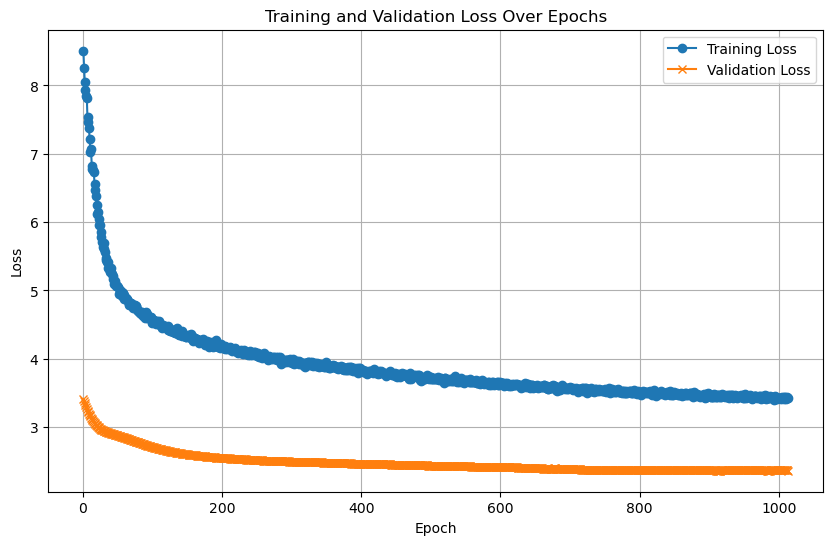

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/209], Loss: 5.3121
Test Batch [20/209], Loss: 4.9490
Test Batch [30/209], Loss: 4.9808
Test Batch [40/209], Loss: 4.4231
Test Batch [50/209], Loss: 4.9867
Test Batch [60/209], Loss: 5.0261


Test Batch [70/209], Loss: 4.6727
Test Batch [80/209], Loss: 5.2229
Test Batch [90/209], Loss: 4.9646
Test Batch [100/209], Loss: 4.9601
Test Batch [110/209], Loss: 5.2390
Test Batch [120/209], Loss: 5.8302
Test Batch [130/209], Loss: 5.2500
Test Batch [140/209], Loss: 5.1581
Test Batch [150/209], Loss: 5.3659


Test Batch [160/209], Loss: 5.2794
Test Batch [170/209], Loss: 5.2122
Test Batch [180/209], Loss: 5.4326
Test Batch [190/209], Loss: 5.3668
Test Batch [200/209], Loss: 5.5262

Test Loss: 5.1297


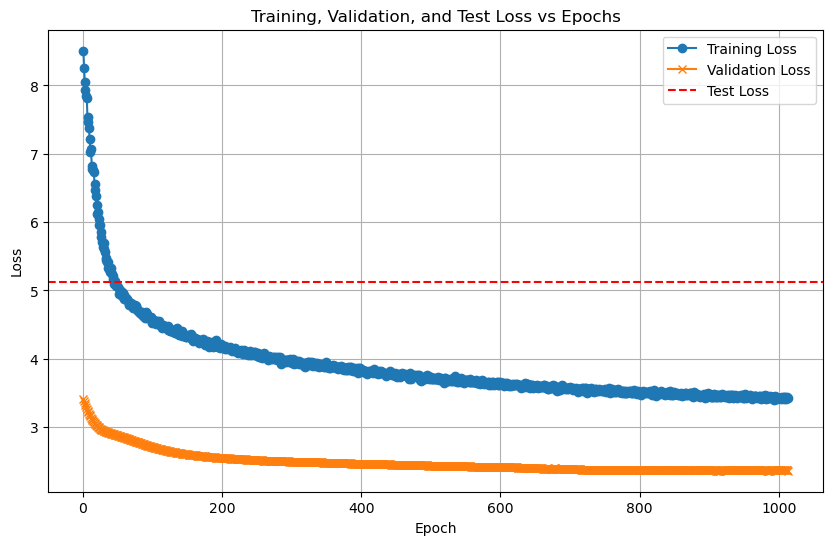

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/209 for test dataset.


  Processed batch 20/209 for test dataset.
  Processed batch 30/209 for test dataset.
  Processed batch 40/209 for test dataset.
  Processed batch 50/209 for test dataset.


  Processed batch 60/209 for test dataset.
  Processed batch 70/209 for test dataset.


  Processed batch 80/209 for test dataset.
  Processed batch 90/209 for test dataset.
  Processed batch 100/209 for test dataset.
  Processed batch 110/209 for test dataset.
  Processed batch 120/209 for test dataset.


  Processed batch 130/209 for test dataset.


  Processed batch 140/209 for test dataset.
  Processed batch 150/209 for test dataset.
  Processed batch 160/209 for test dataset.
  Processed batch 170/209 for test dataset.
  Processed batch 180/209 for test dataset.
  Processed batch 190/209 for test dataset.


  Processed batch 200/209 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.40      0.50         5
           8       0.83      1.00      0.91         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape:

 (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7105  |  Val Loss: 2.6990
Validation loss improved from inf to 2.6990.
[Epoch 2/1000] Train Loss: 2.6584  |  Val Loss: 2.6530
Validation loss improved from 2.6990 to 2.6530.
[Epoch 3/1000] Train Loss: 2.6141  |  Val Loss: 2.6115
Validation loss improved from 2.6530 to 2.6115.
[Epoch 4/1000] Train Loss: 2.5720  |  Val Loss: 2.5724
Validation loss improved from 2.6115 to 2.5724.
[Epoch 5/1000] Train Loss: 2.5311  |  Val Loss: 2.5342
Validation loss improved from 2.5724 to 2.5342.
[Epoch 6/1000] Train Loss: 2.4901  |  Val Loss: 2.4960
Validation loss improved from 2.5342 to 2.4960.
[Epoch 7/1000] Train Loss: 2.4509  |  Val Loss: 2.4561
Validation loss improved from 2.4960 to 2.4561.
[Epoch 8/1000] Train Loss: 2.4097  |  Val Loss: 2.4163
Validation loss improved from 2.4561 to 2.4163.
[Epoch 9/1000] Train Loss: 2.3683  |  Val Loss: 2.3762
Validation loss improved from 2.4163 to 2.3762.


[Epoch 10/1000] Train Loss: 2.3273  |  Val Loss: 2.3361
Validation loss improved from 2.3762 to 2.3361.
[Epoch 11/1000] Train Loss: 2.2848  |  Val Loss: 2.2963
Validation loss improved from 2.3361 to 2.2963.


[Epoch 12/1000] Train Loss: 2.2418  |  Val Loss: 2.2556
Validation loss improved from 2.2963 to 2.2556.
[Epoch 13/1000] Train Loss: 2.1972  |  Val Loss: 2.2118
Validation loss improved from 2.2556 to 2.2118.
[Epoch 14/1000] Train Loss: 2.1495  |  Val Loss: 2.1648
Validation loss improved from 2.2118 to 2.1648.
[Epoch 15/1000] Train Loss: 2.0993  |  Val Loss: 2.1175
Validation loss improved from 2.1648 to 2.1175.
[Epoch 16/1000] Train Loss: 2.0482  |  Val Loss: 2.0698
Validation loss improved from 2.1175 to 2.0698.
[Epoch 17/1000] Train Loss: 1.9954  |  Val Loss: 2.0220
Validation loss improved from 2.0698 to 2.0220.
[Epoch 18/1000] Train Loss: 1.9425  |  Val Loss: 1.9731
Validation loss improved from 2.0220 to 1.9731.
[Epoch 19/1000] Train Loss: 1.8884  |  Val Loss: 1.9250
Validation loss improved from 1.9731 to 1.9250.


[Epoch 20/1000] Train Loss: 1.8351  |  Val Loss: 1.8773
Validation loss improved from 1.9250 to 1.8773.
[Epoch 21/1000] Train Loss: 1.7838  |  Val Loss: 1.8284
Validation loss improved from 1.8773 to 1.8284.
[Epoch 22/1000] Train Loss: 1.7322  |  Val Loss: 1.7806
Validation loss improved from 1.8284 to 1.7806.


[Epoch 23/1000] Train Loss: 1.6823  |  Val Loss: 1.7345
Validation loss improved from 1.7806 to 1.7345.
[Epoch 24/1000] Train Loss: 1.6330  |  Val Loss: 1.6870
Validation loss improved from 1.7345 to 1.6870.
[Epoch 25/1000] Train Loss: 1.5856  |  Val Loss: 1.6414
Validation loss improved from 1.6870 to 1.6414.
[Epoch 26/1000] Train Loss: 1.5398  |  Val Loss: 1.6013
Validation loss improved from 1.6414 to 1.6013.
[Epoch 27/1000] Train Loss: 1.4965  |  Val Loss: 1.5589
Validation loss improved from 1.6013 to 1.5589.
[Epoch 28/1000] Train Loss: 1.4535  |  Val Loss: 1.5201
Validation loss improved from 1.5589 to 1.5201.
[Epoch 29/1000] Train Loss: 1.4119  |  Val Loss: 1.4820
Validation loss improved from 1.5201 to 1.4820.


[Epoch 30/1000] Train Loss: 1.3711  |  Val Loss: 1.4448
Validation loss improved from 1.4820 to 1.4448.
[Epoch 31/1000] Train Loss: 1.3312  |  Val Loss: 1.4111
Validation loss improved from 1.4448 to 1.4111.
[Epoch 32/1000] Train Loss: 1.2934  |  Val Loss: 1.3771
Validation loss improved from 1.4111 to 1.3771.


[Epoch 33/1000] Train Loss: 1.2566  |  Val Loss: 1.3494
Validation loss improved from 1.3771 to 1.3494.
[Epoch 34/1000] Train Loss: 1.2196  |  Val Loss: 1.3160
Validation loss improved from 1.3494 to 1.3160.
[Epoch 35/1000] Train Loss: 1.1852  |  Val Loss: 1.2829
Validation loss improved from 1.3160 to 1.2829.
[Epoch 36/1000] Train Loss: 1.1511  |  Val Loss: 1.2536
Validation loss improved from 1.2829 to 1.2536.
[Epoch 37/1000] Train Loss: 1.1166  |  Val Loss: 1.2286
Validation loss improved from 1.2536 to 1.2286.
[Epoch 38/1000] Train Loss: 1.0828  |  Val Loss: 1.1956
Validation loss improved from 1.2286 to 1.1956.
[Epoch 39/1000] Train Loss: 1.0487  |  Val Loss: 1.1662
Validation loss improved from 1.1956 to 1.1662.


[Epoch 40/1000] Train Loss: 1.0167  |  Val Loss: 1.1407
Validation loss improved from 1.1662 to 1.1407.
[Epoch 41/1000] Train Loss: 0.9844  |  Val Loss: 1.1117
Validation loss improved from 1.1407 to 1.1117.
[Epoch 42/1000] Train Loss: 0.9531  |  Val Loss: 1.0858
Validation loss improved from 1.1117 to 1.0858.
[Epoch 43/1000] Train Loss: 0.9234  |  Val Loss: 1.0637
Validation loss improved from 1.0858 to 1.0637.


[Epoch 44/1000] Train Loss: 0.8947  |  Val Loss: 1.0392
Validation loss improved from 1.0637 to 1.0392.
[Epoch 45/1000] Train Loss: 0.8665  |  Val Loss: 1.0171
Validation loss improved from 1.0392 to 1.0171.
[Epoch 46/1000] Train Loss: 0.8388  |  Val Loss: 0.9962
Validation loss improved from 1.0171 to 0.9962.
[Epoch 47/1000] Train Loss: 0.8134  |  Val Loss: 0.9703
Validation loss improved from 0.9962 to 0.9703.
[Epoch 48/1000] Train Loss: 0.7872  |  Val Loss: 0.9514
Validation loss improved from 0.9703 to 0.9514.
[Epoch 49/1000] Train Loss: 0.7630  |  Val Loss: 0.9305
Validation loss improved from 0.9514 to 0.9305.
[Epoch 50/1000] Train Loss: 0.7403  |  Val Loss: 0.9102
Validation loss improved from 0.9305 to 0.9102.


[Epoch 51/1000] Train Loss: 0.7172  |  Val Loss: 0.8924
Validation loss improved from 0.9102 to 0.8924.
[Epoch 52/1000] Train Loss: 0.6950  |  Val Loss: 0.8742
Validation loss improved from 0.8924 to 0.8742.
[Epoch 53/1000] Train Loss: 0.6735  |  Val Loss: 0.8601
Validation loss improved from 0.8742 to 0.8601.


[Epoch 54/1000] Train Loss: 0.6525  |  Val Loss: 0.8413
Validation loss improved from 0.8601 to 0.8413.
[Epoch 55/1000] Train Loss: 0.6317  |  Val Loss: 0.8258
Validation loss improved from 0.8413 to 0.8258.
[Epoch 56/1000] Train Loss: 0.6115  |  Val Loss: 0.8105
Validation loss improved from 0.8258 to 0.8105.
[Epoch 57/1000] Train Loss: 0.5924  |  Val Loss: 0.7967
Validation loss improved from 0.8105 to 0.7967.
[Epoch 58/1000] Train Loss: 0.5738  |  Val Loss: 0.7843
Validation loss improved from 0.7967 to 0.7843.
[Epoch 59/1000] Train Loss: 0.5557  |  Val Loss: 0.7682
Validation loss improved from 0.7843 to 0.7682.


[Epoch 60/1000] Train Loss: 0.5380  |  Val Loss: 0.7547
Validation loss improved from 0.7682 to 0.7547.
[Epoch 61/1000] Train Loss: 0.5211  |  Val Loss: 0.7451
Validation loss improved from 0.7547 to 0.7451.
[Epoch 62/1000] Train Loss: 0.5050  |  Val Loss: 0.7335
Validation loss improved from 0.7451 to 0.7335.
[Epoch 63/1000] Train Loss: 0.4892  |  Val Loss: 0.7230
Validation loss improved from 0.7335 to 0.7230.


[Epoch 64/1000] Train Loss: 0.4741  |  Val Loss: 0.7140
Validation loss improved from 0.7230 to 0.7140.
[Epoch 65/1000] Train Loss: 0.4591  |  Val Loss: 0.7030
Validation loss improved from 0.7140 to 0.7030.
[Epoch 66/1000] Train Loss: 0.4453  |  Val Loss: 0.6962
Validation loss improved from 0.7030 to 0.6962.
[Epoch 67/1000] Train Loss: 0.4316  |  Val Loss: 0.6880
Validation loss improved from 0.6962 to 0.6880.
[Epoch 68/1000] Train Loss: 0.4185  |  Val Loss: 0.6800
Validation loss improved from 0.6880 to 0.6800.
[Epoch 69/1000] Train Loss: 0.4053  |  Val Loss: 0.6716
Validation loss improved from 0.6800 to 0.6716.


[Epoch 70/1000] Train Loss: 0.3932  |  Val Loss: 0.6657
Validation loss improved from 0.6716 to 0.6657.
[Epoch 71/1000] Train Loss: 0.3819  |  Val Loss: 0.6610
Validation loss improved from 0.6657 to 0.6610.
[Epoch 72/1000] Train Loss: 0.3703  |  Val Loss: 0.6542
Validation loss improved from 0.6610 to 0.6542.
[Epoch 73/1000] Train Loss: 0.3590  |  Val Loss: 0.6468
Validation loss improved from 0.6542 to 0.6468.


[Epoch 74/1000] Train Loss: 0.3480  |  Val Loss: 0.6407
Validation loss improved from 0.6468 to 0.6407.
[Epoch 75/1000] Train Loss: 0.3379  |  Val Loss: 0.6377
Validation loss improved from 0.6407 to 0.6377.
[Epoch 76/1000] Train Loss: 0.3284  |  Val Loss: 0.6311
Validation loss improved from 0.6377 to 0.6311.
[Epoch 77/1000] Train Loss: 0.3185  |  Val Loss: 0.6289
Validation loss improved from 0.6311 to 0.6289.
[Epoch 78/1000] Train Loss: 0.3096  |  Val Loss: 0.6218
Validation loss improved from 0.6289 to 0.6218.
[Epoch 79/1000] Train Loss: 0.3015  |  Val Loss: 0.6155
Validation loss improved from 0.6218 to 0.6155.


[Epoch 80/1000] Train Loss: 0.2928  |  Val Loss: 0.6128
Validation loss improved from 0.6155 to 0.6128.
[Epoch 81/1000] Train Loss: 0.2846  |  Val Loss: 0.6043
Validation loss improved from 0.6128 to 0.6043.
[Epoch 82/1000] Train Loss: 0.2771  |  Val Loss: 0.6029
Validation loss improved from 0.6043 to 0.6029.
[Epoch 83/1000] Train Loss: 0.2700  |  Val Loss: 0.6009
Validation loss improved from 0.6029 to 0.6009.
[Epoch 84/1000] Train Loss: 0.2628  |  Val Loss: 0.5992
Validation loss improved from 0.6009 to 0.5992.


[Epoch 85/1000] Train Loss: 0.2560  |  Val Loss: 0.5949
Validation loss improved from 0.5992 to 0.5949.
[Epoch 86/1000] Train Loss: 0.2501  |  Val Loss: 0.5905
Validation loss improved from 0.5949 to 0.5905.
[Epoch 87/1000] Train Loss: 0.2434  |  Val Loss: 0.5910
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 0.2374  |  Val Loss: 0.5869
Validation loss improved from 0.5905 to 0.5869.
[Epoch 89/1000] Train Loss: 0.2321  |  Val Loss: 0.5834
Validation loss improved from 0.5869 to 0.5834.
[Epoch 90/1000] Train Loss: 0.2264  |  Val Loss: 0.5822
Validation loss improved from 0.5834 to 0.5822.


[Epoch 91/1000] Train Loss: 0.2214  |  Val Loss: 0.5782
Validation loss improved from 0.5822 to 0.5782.
[Epoch 92/1000] Train Loss: 0.2162  |  Val Loss: 0.5738
Validation loss improved from 0.5782 to 0.5738.
[Epoch 93/1000] Train Loss: 0.2122  |  Val Loss: 0.5717
Validation loss improved from 0.5738 to 0.5717.
[Epoch 94/1000] Train Loss: 0.2072  |  Val Loss: 0.5698
Validation loss improved from 0.5717 to 0.5698.


[Epoch 95/1000] Train Loss: 0.2026  |  Val Loss: 0.5697
Validation loss improved from 0.5698 to 0.5697.
[Epoch 96/1000] Train Loss: 0.1983  |  Val Loss: 0.5685
Validation loss improved from 0.5697 to 0.5685.
[Epoch 97/1000] Train Loss: 0.1945  |  Val Loss: 0.5622
Validation loss improved from 0.5685 to 0.5622.
[Epoch 98/1000] Train Loss: 0.1908  |  Val Loss: 0.5611
Validation loss improved from 0.5622 to 0.5611.
[Epoch 99/1000] Train Loss: 0.1866  |  Val Loss: 0.5619
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 100/1000] Train Loss: 0.1834  |  Val Loss: 0.5585
Validation loss improved from 0.5611 to 0.5585.


[Epoch 101/1000] Train Loss: 0.1796  |  Val Loss: 0.5586
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.1766  |  Val Loss: 0.5554
Validation loss improved from 0.5585 to 0.5554.
[Epoch 103/1000] Train Loss: 0.1732  |  Val Loss: 0.5542
Validation loss improved from 0.5554 to 0.5542.
[Epoch 104/1000] Train Loss: 0.1705  |  Val Loss: 0.5535
Validation loss improved from 0.5542 to 0.5535.
[Epoch 105/1000] Train Loss: 0.1674  |  Val Loss: 0.5536
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 106/1000] Train Loss: 0.1647  |  Val Loss: 0.5521
Validation loss improved from 0.5535 to 0.5521.
[Epoch 107/1000] Train Loss: 0.1624  |  Val Loss: 0.5535
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 108/1000] Train Loss: 0.1596  |  Val Loss: 0.5519
Validation loss improved from 0.5521 to 0.5519.
[Epoch 109/1000] Train Loss: 0.1569  |  Val Loss: 0.5515
Validation loss improved from 0.5519 to 0.5515.
[Epoch 110/1000] Train Loss: 0.1542  |  Val Loss: 0.5503
Validation loss improved from 0.5515 to 0.5503.
[Epoch 111/1000] Train Loss: 0.1528  |  Val Loss: 0.5490
Validation loss improved from 0.5503 to 0.5490.


[Epoch 112/1000] Train Loss: 0.1504  |  Val Loss: 0.5528
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 0.1481  |  Val Loss: 0.5495
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 114/1000] Train Loss: 0.1472  |  Val Loss: 0.5519
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 115/1000] Train Loss: 0.1439  |  Val Loss: 0.5575
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 116/1000] Train Loss: 0.1418  |  Val Loss: 0.5524
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 117/1000] Train Loss: 0.1402  |  Val Loss: 0.5457
Validation loss improved from 0.5490 to 0.5457.
[Epoch 118/1000] Train Loss: 0.1386  |  Val Loss: 0.5484
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 0.1377  |  Val Loss: 0.5542
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 0.1355  |  Val Loss: 0.5472
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 0.1331  |  Val Loss: 0.5575
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 122/1000] Train Loss: 0.1316  |  Val Loss: 0.5561
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/1000] Train Loss: 0.1300  |  Val Loss: 0.5521
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 124/1000] Train Loss: 0.1286  |  Val Loss: 0.5516
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 125/1000] Train Loss: 0.1270  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 126/1000] Train Loss: 0.1255  |  Val Loss: 0.5527
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 127/1000] Train Loss: 0.1248  |  Val Loss: 0.5544
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 128/1000] Train Loss: 0.1229  |  Val Loss: 0.5534
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 129/1000] Train Loss: 0.1218  |  Val Loss: 0.5523
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 130/1000] Train Loss: 0.1207  |  Val Loss: 0.5570
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 131/1000] Train Loss: 0.1195  |  Val Loss: 0.5596
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 132/1000] Train Loss: 0.1184  |  Val Loss: 0.5578
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 133/1000] Train Loss: 0.1186  |  Val Loss: 0.5591
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 134/1000] Train Loss: 0.1167  |  Val Loss: 0.5617
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 135/1000] Train Loss: 0.1153  |  Val Loss: 0.5607
!! Validation loss did NOT improve !! Patience: 18/100


[Epoch 136/1000] Train Loss: 0.1143  |  Val Loss: 0.5568
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 137/1000] Train Loss: 0.1132  |  Val Loss: 0.5677
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 138/1000] Train Loss: 0.1121  |  Val Loss: 0.5639
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 139/1000] Train Loss: 0.1112  |  Val Loss: 0.5618
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 140/1000] Train Loss: 0.1104  |  Val Loss: 0.5640
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 141/1000] Train Loss: 0.1094  |  Val Loss: 0.5685
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 142/1000] Train Loss: 0.1085  |  Val Loss: 0.5693
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 143/1000] Train Loss: 0.1078  |  Val Loss: 0.5675
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 144/1000] Train Loss: 0.1073  |  Val Loss: 0.5675
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 145/1000] Train Loss: 0.1079  |  Val Loss: 0.5697
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 146/1000] Train Loss: 0.1055  |  Val Loss: 0.5783
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 147/1000] Train Loss: 0.1053  |  Val Loss: 0.5726
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 148/1000] Train Loss: 0.1046  |  Val Loss: 0.5715
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 149/1000] Train Loss: 0.1032  |  Val Loss: 0.5795
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 150/1000] Train Loss: 0.1034  |  Val Loss: 0.5787
!! Validation loss did NOT improve !! Patience: 33/100


[Epoch 151/1000] Train Loss: 0.1023  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 152/1000] Train Loss: 0.1017  |  Val Loss: 0.5784
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 153/1000] Train Loss: 0.1005  |  Val Loss: 0.5794
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 154/1000] Train Loss: 0.0996  |  Val Loss: 0.5792
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 155/1000] Train Loss: 0.0994  |  Val Loss: 0.5848
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 156/1000] Train Loss: 0.0992  |  Val Loss: 0.5890
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 157/1000] Train Loss: 0.0987  |  Val Loss: 0.5901
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 158/1000] Train Loss: 0.0977  |  Val Loss: 0.5823
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 159/1000] Train Loss: 0.0982  |  Val Loss: 0.5887
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 160/1000] Train Loss: 0.0969  |  Val Loss: 0.6012
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 161/1000] Train Loss: 0.0958  |  Val Loss: 0.5943
!! Validation loss did NOT improve !! Patience: 44/100


[Epoch 162/1000] Train Loss: 0.0952  |  Val Loss: 0.5932
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 163/1000] Train Loss: 0.0946  |  Val Loss: 0.5934
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 164/1000] Train Loss: 0.0950  |  Val Loss: 0.5947
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 165/1000] Train Loss: 0.0938  |  Val Loss: 0.5938
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 166/1000] Train Loss: 0.0943  |  Val Loss: 0.6059
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 167/1000] Train Loss: 0.0934  |  Val Loss: 0.6069
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 168/1000] Train Loss: 0.0924  |  Val Loss: 0.6044
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 169/1000] Train Loss: 0.0920  |  Val Loss: 0.6034
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 170/1000] Train Loss: 0.0911  |  Val Loss: 0.6039
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 171/1000] Train Loss: 0.0910  |  Val Loss: 0.6114
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 172/1000] Train Loss: 0.0901  |  Val Loss: 0.6127
!! Validation loss did NOT improve !! Patience: 55/100


[Epoch 173/1000] Train Loss: 0.0908  |  Val Loss: 0.6115
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 174/1000] Train Loss: 0.0902  |  Val Loss: 0.6104
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 175/1000] Train Loss: 0.0892  |  Val Loss: 0.6187
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 176/1000] Train Loss: 0.0889  |  Val Loss: 0.6215
!! Validation loss did NOT improve !! Patience: 59/100


[Epoch 177/1000] Train Loss: 0.0880  |  Val Loss: 0.6196
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 178/1000] Train Loss: 0.0878  |  Val Loss: 0.6184
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 179/1000] Train Loss: 0.0873  |  Val Loss: 0.6194
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 180/1000] Train Loss: 0.0874  |  Val Loss: 0.6224
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 181/1000] Train Loss: 0.0866  |  Val Loss: 0.6250
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 182/1000] Train Loss: 0.0863  |  Val Loss: 0.6279
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 183/1000] Train Loss: 0.0864  |  Val Loss: 0.6285
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 184/1000] Train Loss: 0.0857  |  Val Loss: 0.6284
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 185/1000] Train Loss: 0.0853  |  Val Loss: 0.6302
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 186/1000] Train Loss: 0.0849  |  Val Loss: 0.6302
!! Validation loss did NOT improve !! Patience: 69/100


[Epoch 187/1000] Train Loss: 0.0845  |  Val Loss: 0.6304
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 188/1000] Train Loss: 0.0840  |  Val Loss: 0.6349
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 189/1000] Train Loss: 0.0838  |  Val Loss: 0.6409
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 190/1000] Train Loss: 0.0838  |  Val Loss: 0.6448
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 191/1000] Train Loss: 0.0829  |  Val Loss: 0.6480
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 192/1000] Train Loss: 0.0829  |  Val Loss: 0.6453
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 193/1000] Train Loss: 0.0832  |  Val Loss: 0.6405
!! Validation loss did NOT improve !! Patience: 76/100


[Epoch 194/1000] Train Loss: 0.0820  |  Val Loss: 0.6415
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 195/1000] Train Loss: 0.0825  |  Val Loss: 0.6505
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 196/1000] Train Loss: 0.0818  |  Val Loss: 0.6560
!! Validation loss did NOT improve !! Patience: 79/100


[Epoch 197/1000] Train Loss: 0.0817  |  Val Loss: 0.6521
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 198/1000] Train Loss: 0.0811  |  Val Loss: 0.6510
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 199/1000] Train Loss: 0.0810  |  Val Loss: 0.6512
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 200/1000] Train Loss: 0.0814  |  Val Loss: 0.6553
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 201/1000] Train Loss: 0.0815  |  Val Loss: 0.6564
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 202/1000] Train Loss: 0.0805  |  Val Loss: 0.6537
!! Validation loss did NOT improve !! Patience: 85/100


[Epoch 203/1000] Train Loss: 0.0797  |  Val Loss: 0.6550
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 204/1000] Train Loss: 0.0792  |  Val Loss: 0.6605
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 205/1000] Train Loss: 0.0793  |  Val Loss: 0.6612
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 206/1000] Train Loss: 0.0787  |  Val Loss: 0.6616
!! Validation loss did NOT improve !! Patience: 89/100


[Epoch 207/1000] Train Loss: 0.0789  |  Val Loss: 0.6625
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 208/1000] Train Loss: 0.0783  |  Val Loss: 0.6616
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 209/1000] Train Loss: 0.0782  |  Val Loss: 0.6640
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 210/1000] Train Loss: 0.0783  |  Val Loss: 0.6655
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 211/1000] Train Loss: 0.0777  |  Val Loss: 0.6658
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 212/1000] Train Loss: 0.0780  |  Val Loss: 0.6714
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 213/1000] Train Loss: 0.0770  |  Val Loss: 0.6702
!! Validation loss did NOT improve !! Patience: 96/100


[Epoch 214/1000] Train Loss: 0.0770  |  Val Loss: 0.6715
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 215/1000] Train Loss: 0.0767  |  Val Loss: 0.6717
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 216/1000] Train Loss: 0.0764  |  Val Loss: 0.6733
!! Validation loss did NOT improve !! Patience: 99/100


[Epoch 217/1000] Train Loss: 0.0762  |  Val Loss: 0.6732
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 217 !!
No improvement for 100 epochs.


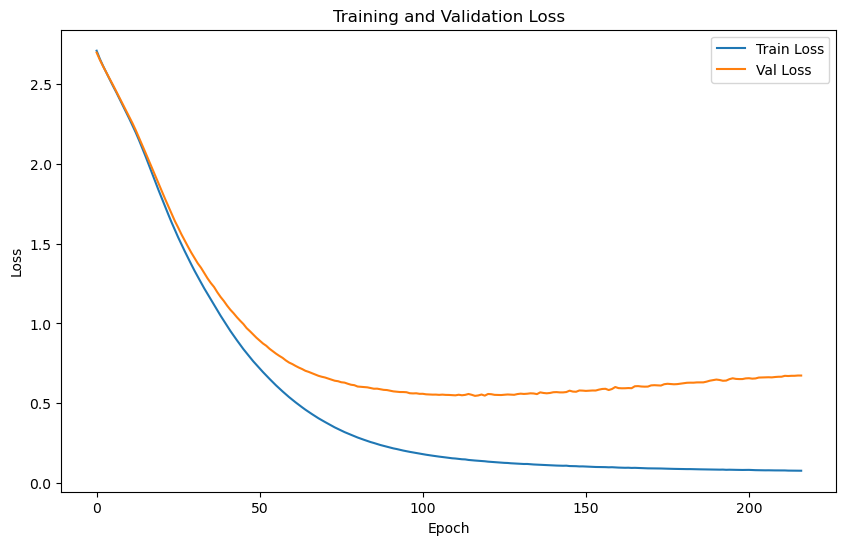

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6896 | Test Accuracy: 81.67%


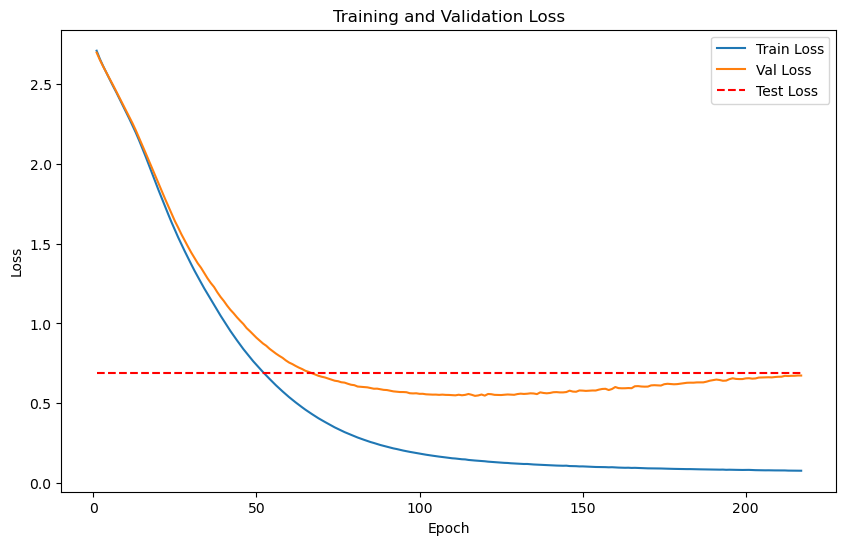

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 640 samples with 64 features each
LOG: Labels shape: (640,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53409 samples with 64 features each
LOG: Labels shape: (53409,)


Train embeddings shape: (640, 64), 
Train labels shape: (640,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53409, 64), 
Test labels shape: (53409,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4621


    Batch [2/2], Train Loss: 0.4644
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3325
    Batch [2/2], Val Loss: 0.3548
Epoch [1/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3437

Validation loss improved from inf to 0.3437. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.4595


    Batch [2/2], Train Loss: 0.4620
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3333
    Batch [2/2], Val Loss: 0.3514
Epoch [2/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.3423

Validation loss improved from 0.3437 to 0.3423. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4566


    Batch [2/2], Train Loss: 0.4603
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3335
    Batch [2/2], Val Loss: 0.3478
Epoch [3/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3406

Validation loss improved from 0.3423 to 0.3406. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4531


    Batch [2/2], Train Loss: 0.4566
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3335
    Batch [2/2], Val Loss: 0.3455
Epoch [4/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3395

Validation loss improved from 0.3406 to 0.3395. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4575


    Batch [2/2], Train Loss: 0.4605
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3332
    Batch [2/2], Val Loss: 0.3424
Epoch [5/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.3378

Validation loss improved from 0.3395 to 0.3378. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4547


    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.3394
Epoch [6/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3365

Validation loss improved from 0.3378 to 0.3365. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4558


    Batch [2/2], Train Loss: 0.4501
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.3377
Epoch [7/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.3362

Validation loss improved from 0.3365 to 0.3362. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.4516


    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.3341
Epoch [8/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.3342

Validation loss improved from 0.3362 to 0.3342. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4448


    Batch [2/2], Train Loss: 0.4468
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3327
    Batch [2/2], Val Loss: 0.3290
Epoch [9/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3309

Validation loss improved from 0.3342 to 0.3309. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4478


    Batch [2/2], Train Loss: 0.4466
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3312
    Batch [2/2], Val Loss: 0.3231
Epoch [10/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3271

Validation loss improved from 0.3309 to 0.3271. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.4450


    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3295
    Batch [2/2], Val Loss: 0.3176
Epoch [11/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3236

Validation loss improved from 0.3271 to 0.3236. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4447


    Batch [2/2], Train Loss: 0.4412
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3278
    Batch [2/2], Val Loss: 0.3123
Epoch [12/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3200

Validation loss improved from 0.3236 to 0.3200. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4445


    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3259
    Batch [2/2], Val Loss: 0.3075
Epoch [13/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3167

Validation loss improved from 0.3200 to 0.3167. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4383


    Batch [2/2], Train Loss: 0.4400
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.3032
Epoch [14/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3136

Validation loss improved from 0.3167 to 0.3136. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.4421


    Batch [2/2], Train Loss: 0.4411
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3224
    Batch [2/2], Val Loss: 0.2992
Epoch [15/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3108

Validation loss improved from 0.3136 to 0.3108. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4345


    Batch [2/2], Train Loss: 0.4394
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3209
    Batch [2/2], Val Loss: 0.2957
Epoch [16/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3083

Validation loss improved from 0.3108 to 0.3083. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4353


    Batch [2/2], Train Loss: 0.4371
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3195
    Batch [2/2], Val Loss: 0.2922
Epoch [17/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3058

Validation loss improved from 0.3083 to 0.3058. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4367


    Batch [2/2], Train Loss: 0.4347
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3180
    Batch [2/2], Val Loss: 0.2893
Epoch [18/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3037

Validation loss improved from 0.3058 to 0.3037. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/2], Train Loss: 0.4343


    Batch [2/2], Train Loss: 0.4330
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.2868
Epoch [19/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3018

Validation loss improved from 0.3037 to 0.3018. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4292


    Batch [2/2], Train Loss: 0.4296
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.2846
Epoch [20/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3000

Validation loss improved from 0.3018 to 0.3000. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4290


    Batch [2/2], Train Loss: 0.4321
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.2823
Epoch [21/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2982

Validation loss improved from 0.3000 to 0.2982. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.4276


    Batch [2/2], Train Loss: 0.4309
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3129
    Batch [2/2], Val Loss: 0.2802
Epoch [22/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2965

Validation loss improved from 0.2982 to 0.2965. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4251


    Batch [2/2], Train Loss: 0.4293
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.2782
Epoch [23/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2950

Validation loss improved from 0.2965 to 0.2950. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4223


    Batch [2/2], Train Loss: 0.4233
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.2760
Epoch [24/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2933

Validation loss improved from 0.2950 to 0.2933. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4281


    Batch [2/2], Train Loss: 0.4217
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3097
    Batch [2/2], Val Loss: 0.2741
Epoch [25/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2919

Validation loss improved from 0.2933 to 0.2919. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.4235


    Batch [2/2], Train Loss: 0.4245
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3086
    Batch [2/2], Val Loss: 0.2725
Epoch [26/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2905

Validation loss improved from 0.2919 to 0.2905. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4255


    Batch [2/2], Train Loss: 0.4221
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3075
    Batch [2/2], Val Loss: 0.2706
Epoch [27/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2891

Validation loss improved from 0.2905 to 0.2891. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4143


    Batch [2/2], Train Loss: 0.4234
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3066
    Batch [2/2], Val Loss: 0.2693
Epoch [28/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2879

Validation loss improved from 0.2891 to 0.2879. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.4125


    Batch [2/2], Train Loss: 0.4272
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.2684
Epoch [29/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2870

Validation loss improved from 0.2879 to 0.2870. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4153


    Batch [2/2], Train Loss: 0.4162
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.2677
Epoch [30/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2862

Validation loss improved from 0.2870 to 0.2862. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.4180


    Batch [2/2], Train Loss: 0.4125
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.2668
Epoch [31/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2853

Validation loss improved from 0.2862 to 0.2853. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4166


    Batch [2/2], Train Loss: 0.4113
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3029
    Batch [2/2], Val Loss: 0.2660
Epoch [32/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2844

Validation loss improved from 0.2853 to 0.2844. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4141


    Batch [2/2], Train Loss: 0.4153
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.2649
Epoch [33/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2834

Validation loss improved from 0.2844 to 0.2834. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.4195


    Batch [2/2], Train Loss: 0.4094
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.2637
Epoch [34/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2823

Validation loss improved from 0.2834 to 0.2823. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4119


    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3000
    Batch [2/2], Val Loss: 0.2627
Epoch [35/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2814

Validation loss improved from 0.2823 to 0.2814. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4045


    Batch [2/2], Train Loss: 0.4049
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2993
    Batch [2/2], Val Loss: 0.2616
Epoch [36/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2805

Validation loss improved from 0.2814 to 0.2805. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4157


    Batch [2/2], Train Loss: 0.4060
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.2606
Epoch [37/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2795

Validation loss improved from 0.2805 to 0.2795. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4013


    Batch [2/2], Train Loss: 0.4022
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2976
    Batch [2/2], Val Loss: 0.2598
Epoch [38/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2787

Validation loss improved from 0.2795 to 0.2787. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4124


    Batch [2/2], Train Loss: 0.4040
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.2584
Epoch [39/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2775

Validation loss improved from 0.2787 to 0.2775. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4032


    Batch [2/2], Train Loss: 0.3961
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2959
    Batch [2/2], Val Loss: 0.2577
Epoch [40/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2768

Validation loss improved from 0.2775 to 0.2768. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4010


    Batch [2/2], Train Loss: 0.4079
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.2566
Epoch [41/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2758

Validation loss improved from 0.2768 to 0.2758. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.3973


    Batch [2/2], Train Loss: 0.4015
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.2555
Epoch [42/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2748

Validation loss improved from 0.2758 to 0.2748. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4035


    Batch [2/2], Train Loss: 0.4041
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.2547
Epoch [43/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2740

Validation loss improved from 0.2748 to 0.2740. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.3944


    Batch [2/2], Train Loss: 0.4022
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.2540
Epoch [44/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2732

Validation loss improved from 0.2740 to 0.2732. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.3990


    Batch [2/2], Train Loss: 0.3972
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2916
    Batch [2/2], Val Loss: 0.2529
Epoch [45/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2722

Validation loss improved from 0.2732 to 0.2722. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.3909
    Batch [2/2], Train Loss: 0.3961
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.2906
    Batch [2/2], Val Loss: 0.2521
Epoch [46/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2714

Validation loss improved from 0.2722 to 0.2714. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.3948


    Batch [2/2], Train Loss: 0.3941
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.2516
Epoch [47/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2707

Validation loss improved from 0.2714 to 0.2707. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.3946


    Batch [2/2], Train Loss: 0.3941
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.2507
Epoch [48/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2699

Validation loss improved from 0.2707 to 0.2699. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.3966


    Batch [2/2], Train Loss: 0.3928
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.2499
Epoch [49/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2691

Validation loss improved from 0.2699 to 0.2691. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.3920


    Batch [2/2], Train Loss: 0.3916
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2875
    Batch [2/2], Val Loss: 0.2488
Epoch [50/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2681

Validation loss improved from 0.2691 to 0.2681. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.3880


    Batch [2/2], Train Loss: 0.3886
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2868
    Batch [2/2], Val Loss: 0.2476
Epoch [51/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2672

Validation loss improved from 0.2681 to 0.2672. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.3952


    Batch [2/2], Train Loss: 0.3875
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2861
    Batch [2/2], Val Loss: 0.2465
Epoch [52/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2663

Validation loss improved from 0.2672 to 0.2663. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.3894
    Batch [2/2], Train Loss: 0.3864
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.2857
    Batch [2/2], Val Loss: 0.2456
Epoch [53/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2657

Validation loss improved from 0.2663 to 0.2657. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3937
    Batch [2/2], Train Loss: 0.3880
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.2852
    Batch [2/2], Val Loss: 0.2447
Epoch [54/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2650

Validation loss improved from 0.2657 to 0.2650. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.3876


    Batch [2/2], Train Loss: 0.3752
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2847
    Batch [2/2], Val Loss: 0.2438
Epoch [55/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2642

Validation loss improved from 0.2650 to 0.2642. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.3850


    Batch [2/2], Train Loss: 0.3879
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2839
    Batch [2/2], Val Loss: 0.2428
Epoch [56/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2634

Validation loss improved from 0.2642 to 0.2634. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.3872


    Batch [2/2], Train Loss: 0.3775
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2831
    Batch [2/2], Val Loss: 0.2422
Epoch [57/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2627

Validation loss improved from 0.2634 to 0.2627. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3812


    Batch [2/2], Train Loss: 0.3757
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2823
    Batch [2/2], Val Loss: 0.2414
Epoch [58/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2618

Validation loss improved from 0.2627 to 0.2618. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.3805


    Batch [2/2], Train Loss: 0.3740
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.2406
Epoch [59/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2610

Validation loss improved from 0.2618 to 0.2610. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3800


    Batch [2/2], Train Loss: 0.3733
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2808
    Batch [2/2], Val Loss: 0.2396
Epoch [60/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2602

Validation loss improved from 0.2610 to 0.2602. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3805


    Batch [2/2], Train Loss: 0.3770
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2800
    Batch [2/2], Val Loss: 0.2379
Epoch [61/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2589

Validation loss improved from 0.2602 to 0.2589. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.3793


    Batch [2/2], Train Loss: 0.3750
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2792
    Batch [2/2], Val Loss: 0.2367
Epoch [62/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2579

Validation loss improved from 0.2589 to 0.2579. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3795


    Batch [2/2], Train Loss: 0.3725
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.2360
Epoch [63/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2573

Validation loss improved from 0.2579 to 0.2573. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3723


    Batch [2/2], Train Loss: 0.3689
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2776
    Batch [2/2], Val Loss: 0.2355
Epoch [64/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2565

Validation loss improved from 0.2573 to 0.2565. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3771
    Batch [2/2], Train Loss: 0.3743
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.2343
Epoch [65/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2556

Validation loss improved from 0.2565 to 0.2556. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3759


    Batch [2/2], Train Loss: 0.3729
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.2338
Epoch [66/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2552

Validation loss improved from 0.2556 to 0.2552. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3738


    Batch [2/2], Train Loss: 0.3756
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.2333
Epoch [67/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2546

Validation loss improved from 0.2552 to 0.2546. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3671


    Batch [2/2], Train Loss: 0.3624
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.2326
Epoch [68/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2540

Validation loss improved from 0.2546 to 0.2540. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.3683


    Batch [2/2], Train Loss: 0.3627
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2745
    Batch [2/2], Val Loss: 0.2314
Epoch [69/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2530

Validation loss improved from 0.2540 to 0.2530. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3691


    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2304
Epoch [70/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2521

Validation loss improved from 0.2530 to 0.2521. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3707


    Batch [2/2], Train Loss: 0.3704
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.2298
Epoch [71/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2515

Validation loss improved from 0.2521 to 0.2515. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3649


    Batch [2/2], Train Loss: 0.3559
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2725
    Batch [2/2], Val Loss: 0.2288
Epoch [72/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2506

Validation loss improved from 0.2515 to 0.2506. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3652


    Batch [2/2], Train Loss: 0.3637
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2717
    Batch [2/2], Val Loss: 0.2276
Epoch [73/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2496

Validation loss improved from 0.2506 to 0.2496. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3577


    Batch [2/2], Train Loss: 0.3655
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.2267
Epoch [74/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2488

Validation loss improved from 0.2496 to 0.2488. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.3614


    Batch [2/2], Train Loss: 0.3609
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2701
    Batch [2/2], Val Loss: 0.2256
Epoch [75/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2478

Validation loss improved from 0.2488 to 0.2478. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3549


    Batch [2/2], Train Loss: 0.3654
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2694
    Batch [2/2], Val Loss: 0.2250
Epoch [76/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2472

Validation loss improved from 0.2478 to 0.2472. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3611


    Batch [2/2], Train Loss: 0.3558
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.2241
Epoch [77/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2464

Validation loss improved from 0.2472 to 0.2464. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3601


    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2681
    Batch [2/2], Val Loss: 0.2231
Epoch [78/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2456

Validation loss improved from 0.2464 to 0.2456. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.3584


    Batch [2/2], Train Loss: 0.3519
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2675
    Batch [2/2], Val Loss: 0.2221
Epoch [79/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2448

Validation loss improved from 0.2456 to 0.2448. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3612


    Batch [2/2], Train Loss: 0.3553
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2670
    Batch [2/2], Val Loss: 0.2218
Epoch [80/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2444

Validation loss improved from 0.2448 to 0.2444. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.3541


    Batch [2/2], Train Loss: 0.3564
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2664
    Batch [2/2], Val Loss: 0.2211
Epoch [81/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.2438

Validation loss improved from 0.2444 to 0.2438. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3522


    Batch [2/2], Train Loss: 0.3496
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.2209
Epoch [82/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2434

Validation loss improved from 0.2438 to 0.2434. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3531


    Batch [2/2], Train Loss: 0.3521
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2651
    Batch [2/2], Val Loss: 0.2198
Epoch [83/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2424

Validation loss improved from 0.2434 to 0.2424. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3551


    Batch [2/2], Train Loss: 0.3479
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.2192
Epoch [84/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2418

Validation loss improved from 0.2424 to 0.2418. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.3516


    Batch [2/2], Train Loss: 0.3539
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2636
    Batch [2/2], Val Loss: 0.2187
Epoch [85/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2412

Validation loss improved from 0.2418 to 0.2412. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3503


    Batch [2/2], Train Loss: 0.3469
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2626
    Batch [2/2], Val Loss: 0.2180
Epoch [86/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2403

Validation loss improved from 0.2412 to 0.2403. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3514


    Batch [2/2], Train Loss: 0.3564
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2618
    Batch [2/2], Val Loss: 0.2169
Epoch [87/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2394

Validation loss improved from 0.2403 to 0.2394. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3469


    Batch [2/2], Train Loss: 0.3468
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2609
    Batch [2/2], Val Loss: 0.2159
Epoch [88/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2384

Validation loss improved from 0.2394 to 0.2384. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3495


    Batch [2/2], Train Loss: 0.3398
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.2149
Epoch [89/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2376

Validation loss improved from 0.2384 to 0.2376. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3509


    Batch [2/2], Train Loss: 0.3470
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2594
    Batch [2/2], Val Loss: 0.2137
Epoch [90/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2365

Validation loss improved from 0.2376 to 0.2365. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3483


    Batch [2/2], Train Loss: 0.3513
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2586
    Batch [2/2], Val Loss: 0.2124
Epoch [91/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2355

Validation loss improved from 0.2365 to 0.2355. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3406


    Batch [2/2], Train Loss: 0.3458
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2581
    Batch [2/2], Val Loss: 0.2117
Epoch [92/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2349

Validation loss improved from 0.2355 to 0.2349. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3436


    Batch [2/2], Train Loss: 0.3485
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2576
    Batch [2/2], Val Loss: 0.2108
Epoch [93/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2342

Validation loss improved from 0.2349 to 0.2342. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3376


    Batch [2/2], Train Loss: 0.3373
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.2104
Epoch [94/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2337

Validation loss improved from 0.2342 to 0.2337. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3449


    Batch [2/2], Train Loss: 0.3404
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2566
    Batch [2/2], Val Loss: 0.2099
Epoch [95/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2333

Validation loss improved from 0.2337 to 0.2333. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3380


    Batch [2/2], Train Loss: 0.3377
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.2093
Epoch [96/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2327

Validation loss improved from 0.2333 to 0.2327. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.3376


    Batch [2/2], Train Loss: 0.3308
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.2091
Epoch [97/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.2324

Validation loss improved from 0.2327 to 0.2324. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3410


    Batch [2/2], Train Loss: 0.3366
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.2084
Epoch [98/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2317

Validation loss improved from 0.2324 to 0.2317. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3367


    Batch [2/2], Train Loss: 0.3328
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2546
    Batch [2/2], Val Loss: 0.2081
Epoch [99/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2314

Validation loss improved from 0.2317 to 0.2314. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.3288


    Batch [2/2], Train Loss: 0.3327
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2540
    Batch [2/2], Val Loss: 0.2075
Epoch [100/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.2308

Validation loss improved from 0.2314 to 0.2308. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3369


    Batch [2/2], Train Loss: 0.3391
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2534
    Batch [2/2], Val Loss: 0.2068
Epoch [101/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2301

Validation loss improved from 0.2308 to 0.2301. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3375


    Batch [2/2], Train Loss: 0.3309
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2528
    Batch [2/2], Val Loss: 0.2066
Epoch [102/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.2297

Validation loss improved from 0.2301 to 0.2297. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3313


    Batch [2/2], Train Loss: 0.3407
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.2056
Epoch [103/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2288

Validation loss improved from 0.2297 to 0.2288. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3341


    Batch [2/2], Train Loss: 0.3260
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.2050
Epoch [104/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.2282

Validation loss improved from 0.2288 to 0.2282. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3213


    Batch [2/2], Train Loss: 0.3379
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2043
Epoch [105/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2274

Validation loss improved from 0.2282 to 0.2274. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3310


    Batch [2/2], Train Loss: 0.3276
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.2036
Epoch [106/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.2268

Validation loss improved from 0.2274 to 0.2268. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3318


    Batch [2/2], Train Loss: 0.3307
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.2030
Epoch [107/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.2261

Validation loss improved from 0.2268 to 0.2261. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3301


    Batch [2/2], Train Loss: 0.3215
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.2021
Epoch [108/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2253

Validation loss improved from 0.2261 to 0.2253. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3255


    Batch [2/2], Train Loss: 0.3267
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.2012
Epoch [109/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2246

Validation loss improved from 0.2253 to 0.2246. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.3357


    Batch [2/2], Train Loss: 0.3266
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2473
    Batch [2/2], Val Loss: 0.2006
Epoch [110/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2240

Validation loss improved from 0.2246 to 0.2240. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3253


    Batch [2/2], Train Loss: 0.3296
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2467
    Batch [2/2], Val Loss: 0.2000
Epoch [111/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2233

Validation loss improved from 0.2240 to 0.2233. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3237


    Batch [2/2], Train Loss: 0.3311
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2459
    Batch [2/2], Val Loss: 0.1993
Epoch [112/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2226

Validation loss improved from 0.2233 to 0.2226. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3342


    Batch [2/2], Train Loss: 0.3203
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2454
    Batch [2/2], Val Loss: 0.1986
Epoch [113/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2220

Validation loss improved from 0.2226 to 0.2220. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/2], Train Loss: 0.3173


    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2449
    Batch [2/2], Val Loss: 0.1983
Epoch [114/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2216

Validation loss improved from 0.2220 to 0.2216. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3263


    Batch [2/2], Train Loss: 0.3199
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2444
    Batch [2/2], Val Loss: 0.1980
Epoch [115/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.2212

Validation loss improved from 0.2216 to 0.2212. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3225


    Batch [2/2], Train Loss: 0.3203
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2438
    Batch [2/2], Val Loss: 0.1975
Epoch [116/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2207

Validation loss improved from 0.2212 to 0.2207. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.3173
    Batch [2/2], Train Loss: 0.3302
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.2431
    Batch [2/2], Val Loss: 0.1971
Epoch [117/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.2201

Validation loss improved from 0.2207 to 0.2201. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3180


    Batch [2/2], Train Loss: 0.3204
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2424
    Batch [2/2], Val Loss: 0.1965
Epoch [118/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2195

Validation loss improved from 0.2201 to 0.2195. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3156


    Batch [2/2], Train Loss: 0.3247
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2416
    Batch [2/2], Val Loss: 0.1960
Epoch [119/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2188

Validation loss improved from 0.2195 to 0.2188. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.3224


    Batch [2/2], Train Loss: 0.3220
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2409
    Batch [2/2], Val Loss: 0.1952
Epoch [120/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2180

Validation loss improved from 0.2188 to 0.2180. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/2], Train Loss: 0.3123


    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2402
    Batch [2/2], Val Loss: 0.1942
Epoch [121/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2172

Validation loss improved from 0.2180 to 0.2172. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3233
    Batch [2/2], Train Loss: 0.3160
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.2397
    Batch [2/2], Val Loss: 0.1935
Epoch [122/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2166

Validation loss improved from 0.2172 to 0.2166. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3155


    Batch [2/2], Train Loss: 0.3156
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2390
    Batch [2/2], Val Loss: 0.1930
Epoch [123/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.2160

Validation loss improved from 0.2166 to 0.2160. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.3113


    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2383
    Batch [2/2], Val Loss: 0.1924
Epoch [124/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2154

Validation loss improved from 0.2160 to 0.2154. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3171


    Batch [2/2], Train Loss: 0.3043
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.1918
Epoch [125/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.2148

Validation loss improved from 0.2154 to 0.2148. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3186


    Batch [2/2], Train Loss: 0.3088
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.1913
Epoch [126/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2142

Validation loss improved from 0.2148 to 0.2142. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.3127


    Batch [2/2], Train Loss: 0.3197
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2366
    Batch [2/2], Val Loss: 0.1907
Epoch [127/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2136

Validation loss improved from 0.2142 to 0.2136. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3124


    Batch [2/2], Train Loss: 0.3185
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2362
    Batch [2/2], Val Loss: 0.1899
Epoch [128/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.2131

Validation loss improved from 0.2136 to 0.2131. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.3093


    Batch [2/2], Train Loss: 0.3092
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.1895
Epoch [129/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.2127

Validation loss improved from 0.2131 to 0.2127. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3163


    Batch [2/2], Train Loss: 0.3086
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2353
    Batch [2/2], Val Loss: 0.1887
Epoch [130/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.2120

Validation loss improved from 0.2127 to 0.2120. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.3078


    Batch [2/2], Train Loss: 0.3074
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2348
    Batch [2/2], Val Loss: 0.1881
Epoch [131/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.2115

Validation loss improved from 0.2120 to 0.2115. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3128


    Batch [2/2], Train Loss: 0.3110
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2344
    Batch [2/2], Val Loss: 0.1876
Epoch [132/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.2110

Validation loss improved from 0.2115 to 0.2110. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3173


    Batch [2/2], Train Loss: 0.3128
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2340
    Batch [2/2], Val Loss: 0.1869
Epoch [133/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.2104

Validation loss improved from 0.2110 to 0.2104. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3106


    Batch [2/2], Train Loss: 0.3016
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2336
    Batch [2/2], Val Loss: 0.1867
Epoch [134/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2101

Validation loss improved from 0.2104 to 0.2101. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3082


    Batch [2/2], Train Loss: 0.3018
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2330
    Batch [2/2], Val Loss: 0.1863
Epoch [135/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.2097

Validation loss improved from 0.2101 to 0.2097. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3084


    Batch [2/2], Train Loss: 0.3046
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2325
    Batch [2/2], Val Loss: 0.1858
Epoch [136/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2091

Validation loss improved from 0.2097 to 0.2091. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3022


    Batch [2/2], Train Loss: 0.3044
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2318
    Batch [2/2], Val Loss: 0.1850
Epoch [137/2000], Avg Train Loss: 0.3033, Avg Val Loss: 0.2084

Validation loss improved from 0.2091 to 0.2084. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3127


    Batch [2/2], Train Loss: 0.3010
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2313
    Batch [2/2], Val Loss: 0.1845
Epoch [138/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2079

Validation loss improved from 0.2084 to 0.2079. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.2982


    Batch [2/2], Train Loss: 0.2954
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.1841
Epoch [139/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.2075

Validation loss improved from 0.2079 to 0.2075. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.3049


    Batch [2/2], Train Loss: 0.3056
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2302
    Batch [2/2], Val Loss: 0.1837
Epoch [140/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2070

Validation loss improved from 0.2075 to 0.2070. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.2981


    Batch [2/2], Train Loss: 0.3038
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.1831
Epoch [141/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.2063

Validation loss improved from 0.2070 to 0.2063. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3020


    Batch [2/2], Train Loss: 0.3026
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2288
    Batch [2/2], Val Loss: 0.1827
Epoch [142/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2057

Validation loss improved from 0.2063 to 0.2057. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.2993


    Batch [2/2], Train Loss: 0.3076
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.1823
Epoch [143/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.2051

Validation loss improved from 0.2057 to 0.2051. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3036


    Batch [2/2], Train Loss: 0.3007
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.1819
Epoch [144/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.2045

Validation loss improved from 0.2051 to 0.2045. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.2984


    Batch [2/2], Train Loss: 0.2973
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.1816
Epoch [145/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2041

Validation loss improved from 0.2045 to 0.2041. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/2], Train Loss: 0.3042


    Batch [2/2], Train Loss: 0.2995
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2260
    Batch [2/2], Val Loss: 0.1817
Epoch [146/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.2039

Validation loss improved from 0.2041 to 0.2039. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.2983


    Batch [2/2], Train Loss: 0.2950
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.1816
Epoch [147/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.2035

Validation loss improved from 0.2039 to 0.2035. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.2966


    Batch [2/2], Train Loss: 0.2983
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.1814
Epoch [148/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2032

Validation loss improved from 0.2035 to 0.2032. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.2919


    Batch [2/2], Train Loss: 0.2865
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2246
    Batch [2/2], Val Loss: 0.1816
Epoch [149/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2031

Validation loss improved from 0.2032 to 0.2031. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.2986


    Batch [2/2], Train Loss: 0.2950
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.1816
Epoch [150/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.2029

Validation loss improved from 0.2031 to 0.2029. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.2986


    Batch [2/2], Train Loss: 0.2905
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2237
    Batch [2/2], Val Loss: 0.1816
Epoch [151/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.2026

Validation loss improved from 0.2029 to 0.2026. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.3051


    Batch [2/2], Train Loss: 0.2963
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2233
    Batch [2/2], Val Loss: 0.1815
Epoch [152/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.2024

Validation loss improved from 0.2026 to 0.2024. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.2947


    Batch [2/2], Train Loss: 0.2954
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2230
    Batch [2/2], Val Loss: 0.1814
Epoch [153/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.2022

Validation loss improved from 0.2024 to 0.2022. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.2883


    Batch [2/2], Train Loss: 0.2907
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2227
    Batch [2/2], Val Loss: 0.1810
Epoch [154/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2018

Validation loss improved from 0.2022 to 0.2018. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.2856


    Batch [2/2], Train Loss: 0.2936
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2222
    Batch [2/2], Val Loss: 0.1807
Epoch [155/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2014

Validation loss improved from 0.2018 to 0.2014. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.2809


    Batch [2/2], Train Loss: 0.2900
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1804
Epoch [156/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.2011

Validation loss improved from 0.2014 to 0.2011. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.2857


    Batch [2/2], Train Loss: 0.2853
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2215
    Batch [2/2], Val Loss: 0.1801
Epoch [157/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.2008

Validation loss improved from 0.2011 to 0.2008. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.2884


    Batch [2/2], Train Loss: 0.2959
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2213
    Batch [2/2], Val Loss: 0.1796
Epoch [158/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.2004

Validation loss improved from 0.2008 to 0.2004. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.2883


    Batch [2/2], Train Loss: 0.2966
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.1794
Epoch [159/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.2002

Validation loss improved from 0.2004 to 0.2002. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.2912


    Batch [2/2], Train Loss: 0.2813
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2208
    Batch [2/2], Val Loss: 0.1792
Epoch [160/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2000

Validation loss improved from 0.2002 to 0.2000. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.2982


    Batch [2/2], Train Loss: 0.2914
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.1794
Epoch [161/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2000

Validation loss improved from 0.2000 to 0.2000. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.2821


    Batch [2/2], Train Loss: 0.2824
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2204
    Batch [2/2], Val Loss: 0.1794
Epoch [162/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.1999

Validation loss improved from 0.2000 to 0.1999. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.2902


    Batch [2/2], Train Loss: 0.2824
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.1790
Epoch [163/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.1995

Validation loss improved from 0.1999 to 0.1995. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.2819


    Batch [2/2], Train Loss: 0.2874
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.1787
Epoch [164/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.1991

Validation loss improved from 0.1995 to 0.1991. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.2836


    Batch [2/2], Train Loss: 0.2796
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2191
    Batch [2/2], Val Loss: 0.1779
Epoch [165/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.1985

Validation loss improved from 0.1991 to 0.1985. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.2815


    Batch [2/2], Train Loss: 0.2851
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1781
Epoch [166/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.1985

Validation loss improved from 0.1985 to 0.1985. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.2885


    Batch [2/2], Train Loss: 0.2820
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1773
Epoch [167/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.1978

Validation loss improved from 0.1985 to 0.1978. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.2844


    Batch [2/2], Train Loss: 0.2762
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1768
Epoch [168/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.1973

Validation loss improved from 0.1978 to 0.1973. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.2828


    Batch [2/2], Train Loss: 0.2781
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.1759
Epoch [169/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.1965

Validation loss improved from 0.1973 to 0.1965. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.2832
    Batch [2/2], Train Loss: 0.2797
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1752
Epoch [170/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.1957

Validation loss improved from 0.1965 to 0.1957. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.2833


    Batch [2/2], Train Loss: 0.2760
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2155
    Batch [2/2], Val Loss: 0.1751
Epoch [171/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.1953

Validation loss improved from 0.1957 to 0.1953. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.2892


    Batch [2/2], Train Loss: 0.2800
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2147
    Batch [2/2], Val Loss: 0.1743
Epoch [172/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.1945

Validation loss improved from 0.1953 to 0.1945. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.2849


    Batch [2/2], Train Loss: 0.2934
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2143
    Batch [2/2], Val Loss: 0.1740
Epoch [173/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.1941

Validation loss improved from 0.1945 to 0.1941. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.2844


    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1739
Epoch [174/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.1939

Validation loss improved from 0.1941 to 0.1939. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.2838


    Batch [2/2], Train Loss: 0.2726
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.1741
Epoch [175/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.1938

Validation loss improved from 0.1939 to 0.1938. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.2778


    Batch [2/2], Train Loss: 0.2737
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.1741
Epoch [176/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.1937

Validation loss improved from 0.1938 to 0.1937. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2763


    Batch [2/2], Train Loss: 0.2851
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.1738
Epoch [177/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.1934

Validation loss improved from 0.1937 to 0.1934. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.2761


    Batch [2/2], Train Loss: 0.2771
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2128
    Batch [2/2], Val Loss: 0.1731
Epoch [178/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.1929

Validation loss improved from 0.1934 to 0.1929. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.2696


    Batch [2/2], Train Loss: 0.2755
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2125
    Batch [2/2], Val Loss: 0.1727
Epoch [179/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.1926

Validation loss improved from 0.1929 to 0.1926. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.2679


    Batch [2/2], Train Loss: 0.2768
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2122
    Batch [2/2], Val Loss: 0.1721
Epoch [180/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.1922

Validation loss improved from 0.1926 to 0.1922. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2786


    Batch [2/2], Train Loss: 0.2783
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1714
Epoch [181/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.1917

Validation loss improved from 0.1922 to 0.1917. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.2776


    Batch [2/2], Train Loss: 0.2790
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2115
    Batch [2/2], Val Loss: 0.1711
Epoch [182/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.1913

Validation loss improved from 0.1917 to 0.1913. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.2721


    Batch [2/2], Train Loss: 0.2717
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1713
Epoch [183/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.1911

Validation loss improved from 0.1913 to 0.1911. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.2754


    Batch [2/2], Train Loss: 0.2758
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.1716
Epoch [184/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.1911

Validation loss improved from 0.1911 to 0.1911. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2713


    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2101
    Batch [2/2], Val Loss: 0.1712
Epoch [185/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.1906

Validation loss improved from 0.1911 to 0.1906. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.2693


    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2097
    Batch [2/2], Val Loss: 0.1708
Epoch [186/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.1902

Validation loss improved from 0.1906 to 0.1902. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2744


    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1703
Epoch [187/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.1898

Validation loss improved from 0.1902 to 0.1898. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.2777


    Batch [2/2], Train Loss: 0.2765
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1706
Epoch [188/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.1899

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.2722


    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1706
Epoch [189/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.1898

Validation loss improved from 0.1898 to 0.1898. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.2656


    Batch [2/2], Train Loss: 0.2786
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2088
    Batch [2/2], Val Loss: 0.1706
Epoch [190/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.1897

Validation loss improved from 0.1898 to 0.1897. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2769


    Batch [2/2], Train Loss: 0.2779
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2085
    Batch [2/2], Val Loss: 0.1707
Epoch [191/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.1896

Validation loss improved from 0.1897 to 0.1896. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.2677


    Batch [2/2], Train Loss: 0.2690
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2081
    Batch [2/2], Val Loss: 0.1706
Epoch [192/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.1894

Validation loss improved from 0.1896 to 0.1894. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2688


    Batch [2/2], Train Loss: 0.2664
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2078
    Batch [2/2], Val Loss: 0.1703
Epoch [193/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.1890

Validation loss improved from 0.1894 to 0.1890. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.2717


    Batch [2/2], Train Loss: 0.2756
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.1696
Epoch [194/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.1885

Validation loss improved from 0.1890 to 0.1885. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.2644


    Batch [2/2], Train Loss: 0.2618
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2072
    Batch [2/2], Val Loss: 0.1692
Epoch [195/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.1882

Validation loss improved from 0.1885 to 0.1882. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.2762


    Batch [2/2], Train Loss: 0.2734
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2069
    Batch [2/2], Val Loss: 0.1687
Epoch [196/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.1878

Validation loss improved from 0.1882 to 0.1878. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2669


    Batch [2/2], Train Loss: 0.2689
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2066
    Batch [2/2], Val Loss: 0.1677
Epoch [197/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.1872

Validation loss improved from 0.1878 to 0.1872. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2644


    Batch [2/2], Train Loss: 0.2564
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2062
    Batch [2/2], Val Loss: 0.1669
Epoch [198/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.1866

Validation loss improved from 0.1872 to 0.1866. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2614


    Batch [2/2], Train Loss: 0.2643
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2060
    Batch [2/2], Val Loss: 0.1667
Epoch [199/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.1863

Validation loss improved from 0.1866 to 0.1863. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.2738


    Batch [2/2], Train Loss: 0.2726
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2057
    Batch [2/2], Val Loss: 0.1661
Epoch [200/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.1859

Validation loss improved from 0.1863 to 0.1859. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2701


    Batch [2/2], Train Loss: 0.2695
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2057
    Batch [2/2], Val Loss: 0.1654
Epoch [201/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.1855

Validation loss improved from 0.1859 to 0.1855. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2714


    Batch [2/2], Train Loss: 0.2623
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2055
    Batch [2/2], Val Loss: 0.1650
Epoch [202/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.1853

Validation loss improved from 0.1855 to 0.1853. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2570


    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2052
    Batch [2/2], Val Loss: 0.1650
Epoch [203/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.1851

Validation loss improved from 0.1853 to 0.1851. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.2585


    Batch [2/2], Train Loss: 0.2602
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2049
    Batch [2/2], Val Loss: 0.1649
Epoch [204/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.1849

Validation loss improved from 0.1851 to 0.1849. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.2696


    Batch [2/2], Train Loss: 0.2688
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2044
    Batch [2/2], Val Loss: 0.1648
Epoch [205/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.1846

Validation loss improved from 0.1849 to 0.1846. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2632


    Batch [2/2], Train Loss: 0.2644
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2040
    Batch [2/2], Val Loss: 0.1647
Epoch [206/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.1844

Validation loss improved from 0.1846 to 0.1844. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.2629


    Batch [2/2], Train Loss: 0.2568
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2038
    Batch [2/2], Val Loss: 0.1642
Epoch [207/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.1840

Validation loss improved from 0.1844 to 0.1840. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2678


    Batch [2/2], Train Loss: 0.2598
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.1636
Epoch [208/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.1836

Validation loss improved from 0.1840 to 0.1836. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.2653


    Batch [2/2], Train Loss: 0.2541
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.1631
Epoch [209/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.1833

Validation loss improved from 0.1836 to 0.1833. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2538


    Batch [2/2], Train Loss: 0.2665
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.1628
Epoch [210/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.1831

Validation loss improved from 0.1833 to 0.1831. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2619


    Batch [2/2], Train Loss: 0.2618
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2034
    Batch [2/2], Val Loss: 0.1626
Epoch [211/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.1830

Validation loss improved from 0.1831 to 0.1830. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.2648


    Batch [2/2], Train Loss: 0.2603
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2032
    Batch [2/2], Val Loss: 0.1623
Epoch [212/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.1827

Validation loss improved from 0.1830 to 0.1827. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.2690


    Batch [2/2], Train Loss: 0.2628
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2028
    Batch [2/2], Val Loss: 0.1619
Epoch [213/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.1824

Validation loss improved from 0.1827 to 0.1824. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2682


    Batch [2/2], Train Loss: 0.2584
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2026
    Batch [2/2], Val Loss: 0.1615
Epoch [214/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.1820

Validation loss improved from 0.1824 to 0.1820. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.2572


    Batch [2/2], Train Loss: 0.2507
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2025
    Batch [2/2], Val Loss: 0.1615
Epoch [215/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1820

Validation loss improved from 0.1820 to 0.1820. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.2604


    Batch [2/2], Train Loss: 0.2512
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2024
    Batch [2/2], Val Loss: 0.1613
Epoch [216/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.1818

Validation loss improved from 0.1820 to 0.1818. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2667


    Batch [2/2], Train Loss: 0.2587
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2019
    Batch [2/2], Val Loss: 0.1609
Epoch [217/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.1814

Validation loss improved from 0.1818 to 0.1814. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2653


    Batch [2/2], Train Loss: 0.2632
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2015
    Batch [2/2], Val Loss: 0.1610
Epoch [218/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.1812

Validation loss improved from 0.1814 to 0.1812. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.2513


    Batch [2/2], Train Loss: 0.2640
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2011
    Batch [2/2], Val Loss: 0.1606
Epoch [219/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1808

Validation loss improved from 0.1812 to 0.1808. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2516


    Batch [2/2], Train Loss: 0.2601
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2008
    Batch [2/2], Val Loss: 0.1605
Epoch [220/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.1807

Validation loss improved from 0.1808 to 0.1807. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2584


    Batch [2/2], Train Loss: 0.2587
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2006
    Batch [2/2], Val Loss: 0.1596
Epoch [221/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1801

Validation loss improved from 0.1807 to 0.1801. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2617
    Batch [2/2], Train Loss: 0.2613
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.2005
    Batch [2/2], Val Loss: 0.1594
Epoch [222/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.1799

Validation loss improved from 0.1801 to 0.1799. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.2515


    Batch [2/2], Train Loss: 0.2528
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2003
    Batch [2/2], Val Loss: 0.1591
Epoch [223/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1797

Validation loss improved from 0.1799 to 0.1797. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.2605


    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2000
    Batch [2/2], Val Loss: 0.1583
Epoch [224/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.1792

Validation loss improved from 0.1797 to 0.1792. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2544


    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.1998
    Batch [2/2], Val Loss: 0.1577
Epoch [225/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1788

Validation loss improved from 0.1792 to 0.1788. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.2577


    Batch [2/2], Train Loss: 0.2573
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.1996
    Batch [2/2], Val Loss: 0.1571
Epoch [226/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1783

Validation loss improved from 0.1788 to 0.1783. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2479


    Batch [2/2], Train Loss: 0.2590
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.1994
    Batch [2/2], Val Loss: 0.1572
Epoch [227/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.1783

Validation loss improved from 0.1783 to 0.1783. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2547


    Batch [2/2], Train Loss: 0.2602
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.1991
    Batch [2/2], Val Loss: 0.1569
Epoch [228/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1780

Validation loss improved from 0.1783 to 0.1780. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2499


    Batch [2/2], Train Loss: 0.2502
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.1988
    Batch [2/2], Val Loss: 0.1565
Epoch [229/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.1777

Validation loss improved from 0.1780 to 0.1777. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2549


    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.1988
    Batch [2/2], Val Loss: 0.1567
Epoch [230/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.1777

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2504


    Batch [2/2], Train Loss: 0.2557
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.1564
Epoch [231/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1775

Validation loss improved from 0.1777 to 0.1775. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2503


    Batch [2/2], Train Loss: 0.2471
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.1985
    Batch [2/2], Val Loss: 0.1561
Epoch [232/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.1773

Validation loss improved from 0.1775 to 0.1773. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2528


    Batch [2/2], Train Loss: 0.2524
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.1557
Epoch [233/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1771

Validation loss improved from 0.1773 to 0.1771. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2535


    Batch [2/2], Train Loss: 0.2511
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.1981
    Batch [2/2], Val Loss: 0.1557
Epoch [234/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.1769

Validation loss improved from 0.1771 to 0.1769. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2460


    Batch [2/2], Train Loss: 0.2452
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.1978
    Batch [2/2], Val Loss: 0.1555
Epoch [235/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.1767

Validation loss improved from 0.1769 to 0.1767. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2557


    Batch [2/2], Train Loss: 0.2522
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.1976
    Batch [2/2], Val Loss: 0.1553
Epoch [236/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.1764

Validation loss improved from 0.1767 to 0.1764. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2469


    Batch [2/2], Train Loss: 0.2466
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.1974
    Batch [2/2], Val Loss: 0.1546
Epoch [237/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.1760

Validation loss improved from 0.1764 to 0.1760. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2556


    Batch [2/2], Train Loss: 0.2504
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.1973
    Batch [2/2], Val Loss: 0.1548
Epoch [238/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1761

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2585


    Batch [2/2], Train Loss: 0.2507
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.1546
Epoch [239/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.1759

Validation loss improved from 0.1760 to 0.1759. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.2495


    Batch [2/2], Train Loss: 0.2505
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.1969
    Batch [2/2], Val Loss: 0.1540
Epoch [240/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1755

Validation loss improved from 0.1759 to 0.1755. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2554


    Batch [2/2], Train Loss: 0.2493
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.1970
    Batch [2/2], Val Loss: 0.1543
Epoch [241/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2418


    Batch [2/2], Train Loss: 0.2507
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.1970
    Batch [2/2], Val Loss: 0.1543
Epoch [242/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.1756

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.2424
    Batch [2/2], Train Loss: 0.2405
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.1967
    Batch [2/2], Val Loss: 0.1548
Epoch [243/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2498


    Batch [2/2], Train Loss: 0.2472
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.1964
    Batch [2/2], Val Loss: 0.1553
Epoch [244/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.1758

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2454


    Batch [2/2], Train Loss: 0.2495
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.1961
    Batch [2/2], Val Loss: 0.1558
Epoch [245/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2533


    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.1959
    Batch [2/2], Val Loss: 0.1560
Epoch [246/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2448


    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.1958
    Batch [2/2], Val Loss: 0.1559
Epoch [247/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1759

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.2413


    Batch [2/2], Train Loss: 0.2526
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.1957
    Batch [2/2], Val Loss: 0.1557
Epoch [248/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1757

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2472


    Batch [2/2], Train Loss: 0.2477
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.1955
    Batch [2/2], Val Loss: 0.1548
Epoch [249/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.1751

Validation loss improved from 0.1755 to 0.1751. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2454


    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.1954
    Batch [2/2], Val Loss: 0.1550
Epoch [250/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.1752

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2409
    Batch [2/2], Train Loss: 0.2473
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.1953
    Batch [2/2], Val Loss: 0.1547
Epoch [251/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.1750

Validation loss improved from 0.1751 to 0.1750. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2408


    Batch [2/2], Train Loss: 0.2471
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1542
Epoch [252/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.1746

Validation loss improved from 0.1750 to 0.1746. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2381


    Batch [2/2], Train Loss: 0.2443
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.1538
Epoch [253/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1743

Validation loss improved from 0.1746 to 0.1743. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2490


    Batch [2/2], Train Loss: 0.2431
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.1948
    Batch [2/2], Val Loss: 0.1537
Epoch [254/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.1742

Validation loss improved from 0.1743 to 0.1742. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2424


    Batch [2/2], Train Loss: 0.2420
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1533
Epoch [255/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1740

Validation loss improved from 0.1742 to 0.1740. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2446
    Batch [2/2], Train Loss: 0.2409


LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.1530
Epoch [256/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.1738

Validation loss improved from 0.1740 to 0.1738. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2406


    Batch [2/2], Train Loss: 0.2446
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1527
Epoch [257/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.1736

Validation loss improved from 0.1738 to 0.1736. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2481


    Batch [2/2], Train Loss: 0.2434
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1524
Epoch [258/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.1735

Validation loss improved from 0.1736 to 0.1735. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2356


    Batch [2/2], Train Loss: 0.2407
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.1516
Epoch [259/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.1730

Validation loss improved from 0.1735 to 0.1730. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2387


    Batch [2/2], Train Loss: 0.2364
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1517
Epoch [260/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.1731

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.2443


    Batch [2/2], Train Loss: 0.2406
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1519
Epoch [261/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.1732

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2406


    Batch [2/2], Train Loss: 0.2358
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1514
Epoch [262/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.1730

Validation loss improved from 0.1730 to 0.1730. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2413


    Batch [2/2], Train Loss: 0.2352
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.1943
    Batch [2/2], Val Loss: 0.1516
Epoch [263/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.1730

Validation loss improved from 0.1730 to 0.1730. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2347


    Batch [2/2], Train Loss: 0.2404
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.1942
    Batch [2/2], Val Loss: 0.1516
Epoch [264/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.1729

Validation loss improved from 0.1730 to 0.1729. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.2393


    Batch [2/2], Train Loss: 0.2417
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1513
Epoch [265/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.1726

Validation loss improved from 0.1729 to 0.1726. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2362


    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.1936
    Batch [2/2], Val Loss: 0.1515
Epoch [266/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.1725

Validation loss improved from 0.1726 to 0.1725. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2330


    Batch [2/2], Train Loss: 0.2375
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1517
Epoch [267/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1724

Validation loss improved from 0.1725 to 0.1724. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.2352


    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.1927
    Batch [2/2], Val Loss: 0.1518
Epoch [268/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.1723

Validation loss improved from 0.1724 to 0.1723. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.2398


    Batch [2/2], Train Loss: 0.2422
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1515
Epoch [269/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.1719

Validation loss improved from 0.1723 to 0.1719. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2255


    Batch [2/2], Train Loss: 0.2397
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1515
Epoch [270/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1718

Validation loss improved from 0.1719 to 0.1718. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2377


    Batch [2/2], Train Loss: 0.2357
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.1512
Epoch [271/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1716

Validation loss improved from 0.1718 to 0.1716. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2330


    Batch [2/2], Train Loss: 0.2378
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.1917
    Batch [2/2], Val Loss: 0.1508
Epoch [272/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1712

Validation loss improved from 0.1716 to 0.1712. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.2471


    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.1917
    Batch [2/2], Val Loss: 0.1504
Epoch [273/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1710

Validation loss improved from 0.1712 to 0.1710. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2358


    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.1918
    Batch [2/2], Val Loss: 0.1500
Epoch [274/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.1709

Validation loss improved from 0.1710 to 0.1709. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2356


    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.1918
    Batch [2/2], Val Loss: 0.1493
Epoch [275/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1706

Validation loss improved from 0.1709 to 0.1706. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.2385


    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.1492
Epoch [276/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1706

Validation loss improved from 0.1706 to 0.1706. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.2280


    Batch [2/2], Train Loss: 0.2407
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.1918
    Batch [2/2], Val Loss: 0.1489
Epoch [277/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.1703

Validation loss improved from 0.1706 to 0.1703. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2465


    Batch [2/2], Train Loss: 0.2310
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.1915
    Batch [2/2], Val Loss: 0.1490
Epoch [278/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1702

Validation loss improved from 0.1703 to 0.1702. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.2282


    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.1911
    Batch [2/2], Val Loss: 0.1486
Epoch [279/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1698

Validation loss improved from 0.1702 to 0.1698. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.2333


    Batch [2/2], Train Loss: 0.2298
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1484
Epoch [280/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1697

Validation loss improved from 0.1698 to 0.1697. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2341


    Batch [2/2], Train Loss: 0.2319
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1483
Epoch [281/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1696

Validation loss improved from 0.1697 to 0.1696. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2384


    Batch [2/2], Train Loss: 0.2357
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.1910
    Batch [2/2], Val Loss: 0.1482
Epoch [282/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.1696

Validation loss improved from 0.1696 to 0.1696. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2308


    Batch [2/2], Train Loss: 0.2253
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1480
Epoch [283/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.1695

Validation loss improved from 0.1696 to 0.1695. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.2423


    Batch [2/2], Train Loss: 0.2323
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1478
Epoch [284/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.1694

Validation loss improved from 0.1695 to 0.1694. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2307


    Batch [2/2], Train Loss: 0.2311
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1477
Epoch [285/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1693

Validation loss improved from 0.1694 to 0.1693. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2275


    Batch [2/2], Train Loss: 0.2353
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.1480
Epoch [286/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.1693

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.2241


    Batch [2/2], Train Loss: 0.2248
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.1906
    Batch [2/2], Val Loss: 0.1478
Epoch [287/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.1692

Validation loss improved from 0.1693 to 0.1692. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2314


    Batch [2/2], Train Loss: 0.2263
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.1902
    Batch [2/2], Val Loss: 0.1472
Epoch [288/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1687

Validation loss improved from 0.1692 to 0.1687. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2349


    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.1900
    Batch [2/2], Val Loss: 0.1469
Epoch [289/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1685

Validation loss improved from 0.1687 to 0.1685. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2313


    Batch [2/2], Train Loss: 0.2392
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.1465
Epoch [290/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1681

Validation loss improved from 0.1685 to 0.1681. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2249


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1461
Epoch [291/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.1679

Validation loss improved from 0.1681 to 0.1679. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2312


    Batch [2/2], Train Loss: 0.2284
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1461
Epoch [292/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1678

Validation loss improved from 0.1679 to 0.1678. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2320


    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1455
Epoch [293/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.1675

Validation loss improved from 0.1678 to 0.1675. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.2348


    Batch [2/2], Train Loss: 0.2410
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1452
Epoch [294/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.1673

Validation loss improved from 0.1675 to 0.1673. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2265


    Batch [2/2], Train Loss: 0.2327
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1453
Epoch [295/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.1674

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.2357


    Batch [2/2], Train Loss: 0.2260
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1448
Epoch [296/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1672

Validation loss improved from 0.1673 to 0.1672. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2259


    Batch [2/2], Train Loss: 0.2347
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1445
Epoch [297/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1670

Validation loss improved from 0.1672 to 0.1670. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2178


    Batch [2/2], Train Loss: 0.2338
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.1445
Epoch [298/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.1669

Validation loss improved from 0.1670 to 0.1669. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.2218


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.1892
    Batch [2/2], Val Loss: 0.1444
Epoch [299/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.1668

Validation loss improved from 0.1669 to 0.1668. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2376


    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.1442
Epoch [300/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1666

Validation loss improved from 0.1668 to 0.1666. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.2253


    Batch [2/2], Train Loss: 0.2242
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.1890
    Batch [2/2], Val Loss: 0.1446
Epoch [301/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.2395


    Batch [2/2], Train Loss: 0.2270
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1448
Epoch [302/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2322


    Batch [2/2], Train Loss: 0.2206
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.1449
Epoch [303/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2340


    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.1447
Epoch [304/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.1665

Validation loss improved from 0.1666 to 0.1665. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.2237


    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.1444
Epoch [305/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.1664

Validation loss improved from 0.1665 to 0.1664. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.2239


    Batch [2/2], Train Loss: 0.2251
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.1445
Epoch [306/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2206


    Batch [2/2], Train Loss: 0.2233
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.1886
    Batch [2/2], Val Loss: 0.1437
Epoch [307/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1661

Validation loss improved from 0.1664 to 0.1661. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2243


    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.1886
    Batch [2/2], Val Loss: 0.1436
Epoch [308/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.1661

Validation loss improved from 0.1661 to 0.1661. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.2242


    Batch [2/2], Train Loss: 0.2194
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.1435
Epoch [309/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1661

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.2313


    Batch [2/2], Train Loss: 0.2188
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.1431
Epoch [310/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.1659

Validation loss improved from 0.1661 to 0.1659. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.2212


    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.1427
Epoch [311/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.1656

Validation loss improved from 0.1659 to 0.1656. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2240


    Batch [2/2], Train Loss: 0.2281
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.1429
Epoch [312/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.1657

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2287
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.1883
    Batch [2/2], Val Loss: 0.1429
Epoch [313/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.2193


    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.1881
    Batch [2/2], Val Loss: 0.1430
Epoch [314/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1656

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1427
Epoch [315/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.1653

Validation loss improved from 0.1656 to 0.1653. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2271


    Batch [2/2], Train Loss: 0.2166
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.1427
Epoch [316/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1652

Validation loss improved from 0.1653 to 0.1652. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.2288


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.1427
Epoch [317/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1652

Validation loss improved from 0.1652 to 0.1652. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.2311


    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.1423
Epoch [318/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.1649

Validation loss improved from 0.1652 to 0.1649. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2216


    Batch [2/2], Train Loss: 0.2286
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.1420
Epoch [319/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1647

Validation loss improved from 0.1649 to 0.1647. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.2240


    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1417
Epoch [320/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1647

Validation loss improved from 0.1647 to 0.1647. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.1874
    Batch [2/2], Val Loss: 0.1412
Epoch [321/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1643

Validation loss improved from 0.1647 to 0.1643. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2228


    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.1410
Epoch [322/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1641

Validation loss improved from 0.1643 to 0.1641. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1403
Epoch [323/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1637

Validation loss improved from 0.1641 to 0.1637. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2273


    Batch [2/2], Train Loss: 0.2277
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.1870
    Batch [2/2], Val Loss: 0.1399
Epoch [324/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1634

Validation loss improved from 0.1637 to 0.1634. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.2229


    Batch [2/2], Train Loss: 0.2096
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.1868
    Batch [2/2], Val Loss: 0.1395
Epoch [325/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1631

Validation loss improved from 0.1634 to 0.1631. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.2189


    Batch [2/2], Train Loss: 0.2192
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1387
Epoch [326/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.1627

Validation loss improved from 0.1631 to 0.1627. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.2180


    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1381
Epoch [327/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.1623

Validation loss improved from 0.1627 to 0.1623. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2252


    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1377
Epoch [328/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.1621

Validation loss improved from 0.1623 to 0.1621. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2204


    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1376
Epoch [329/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1621

Validation loss improved from 0.1621 to 0.1621. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.2146


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.1377
Epoch [330/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2221


    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1376
Epoch [331/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2140


    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1376
Epoch [332/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.1620

Validation loss improved from 0.1621 to 0.1620. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2227


    Batch [2/2], Train Loss: 0.2145
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1378
Epoch [333/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training


    Batch [1/2], Train Loss: 0.2236


    Batch [2/2], Train Loss: 0.2124
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1379
Epoch [334/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2112


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1383
Epoch [335/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2119


    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1381
Epoch [336/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.1619

Validation loss improved from 0.1620 to 0.1619. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.2241


    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1379
Epoch [337/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1617

Validation loss improved from 0.1619 to 0.1617. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.2205


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1855
    Batch [2/2], Val Loss: 0.1375
Epoch [338/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1615

Validation loss improved from 0.1617 to 0.1615. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2211


    Batch [2/2], Train Loss: 0.2142
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1855
    Batch [2/2], Val Loss: 0.1375
Epoch [339/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.1615

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2143


    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.1374
Epoch [340/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1614

Validation loss improved from 0.1615 to 0.1614. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2216


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1375
Epoch [341/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1616

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.2130


    Batch [2/2], Train Loss: 0.2194
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1377
Epoch [342/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1617

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2163


    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1382
Epoch [343/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1377
Epoch [344/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.1615

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [345/2000] - Training


    Batch [1/2], Train Loss: 0.2172


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1372
Epoch [345/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1612

Validation loss improved from 0.1614 to 0.1612. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2116


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1368
Epoch [346/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1610

Validation loss improved from 0.1612 to 0.1610. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2256


    Batch [2/2], Train Loss: 0.2177
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1358
Epoch [347/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.1604

Validation loss improved from 0.1610 to 0.1604. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2108


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1351
Epoch [348/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1600

Validation loss improved from 0.1604 to 0.1600. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2147


    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1350
Epoch [349/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1599

Validation loss improved from 0.1600 to 0.1599. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2194


    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1355
Epoch [350/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.2069


    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1355
Epoch [351/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.2164
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1357
Epoch [352/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2111
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1359
Epoch [353/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1602

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2159


    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1359
Epoch [354/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2181


    Batch [2/2], Train Loss: 0.2041
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1359
Epoch [355/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1356
Epoch [356/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1599

Validation loss improved from 0.1599 to 0.1599. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2060


    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.1352
Epoch [357/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.1596

Validation loss improved from 0.1599 to 0.1596. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.2176
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.1347
Epoch [358/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1594

Validation loss improved from 0.1596 to 0.1594. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2037


    Batch [2/2], Train Loss: 0.2074
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.1342
Epoch [359/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1591

Validation loss improved from 0.1594 to 0.1591. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.2151


    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1339
Epoch [360/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1590

Validation loss improved from 0.1591 to 0.1590. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2208


    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1838
    Batch [2/2], Val Loss: 0.1331
Epoch [361/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.1584

Validation loss improved from 0.1590 to 0.1584. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.2124


    Batch [2/2], Train Loss: 0.2035
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.1325
Epoch [362/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1581

Validation loss improved from 0.1584 to 0.1581. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2083


    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.1324
Epoch [363/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1579

Validation loss improved from 0.1581 to 0.1579. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.2160


    Batch [2/2], Train Loss: 0.2103
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.1323
Epoch [364/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1577

Validation loss improved from 0.1579 to 0.1577. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2141


    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1827
    Batch [2/2], Val Loss: 0.1328
Epoch [365/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.2051


    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1825
    Batch [2/2], Val Loss: 0.1329
Epoch [366/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2077


    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1327
Epoch [367/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1575

Validation loss improved from 0.1577 to 0.1575. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.1330
Epoch [368/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [369/2000] - Training


    Batch [1/2], Train Loss: 0.2066


    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1329
Epoch [369/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1576

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.2097


    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1328
Epoch [370/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1575

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2009


    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1328
Epoch [371/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1575

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.2181


    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.1324
Epoch [372/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1573

Validation loss improved from 0.1575 to 0.1573. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.2116


    Batch [2/2], Train Loss: 0.2036
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1323
Epoch [373/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1573

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.2018


    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.1322
Epoch [374/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1573

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2072


    Batch [2/2], Train Loss: 0.2035
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1318
Epoch [375/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1570

Validation loss improved from 0.1573 to 0.1570. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2122


    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1318
Epoch [376/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1570

Validation loss improved from 0.1570 to 0.1570. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.2021
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1320
Epoch [377/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2110


    Batch [2/2], Train Loss: 0.1990
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.1320
Epoch [378/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.1570

Validation loss improved from 0.1570 to 0.1570. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2081
    Batch [2/2], Train Loss: 0.2155
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1319
Epoch [379/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1569

Validation loss improved from 0.1570 to 0.1569. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.2084


    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1315
Epoch [380/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1567

Validation loss improved from 0.1569 to 0.1567. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.2060


    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1313
Epoch [381/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.1566

Validation loss improved from 0.1567 to 0.1566. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.1972


    Batch [2/2], Train Loss: 0.2067
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1314
Epoch [382/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.1567

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2104
    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1315
Epoch [383/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.2060


    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1319
Epoch [384/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.1998


    Batch [2/2], Train Loss: 0.2020
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1318
Epoch [385/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.2121


    Batch [2/2], Train Loss: 0.2049
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1315
Epoch [386/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1566

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2112


    Batch [2/2], Train Loss: 0.2010
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1309
Epoch [387/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1563

Validation loss improved from 0.1566 to 0.1563. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.1977
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1299
Epoch [388/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1560

Validation loss improved from 0.1563 to 0.1560. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2063


    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1295
Epoch [389/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1559

Validation loss improved from 0.1560 to 0.1559. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2001


    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1290
Epoch [390/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.1557

Validation loss improved from 0.1559 to 0.1557. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.2006


    Batch [2/2], Train Loss: 0.1977
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.1288
Epoch [391/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.1556

Validation loss improved from 0.1557 to 0.1556. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2012


    Batch [2/2], Train Loss: 0.2034
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.1286
Epoch [392/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1555

Validation loss improved from 0.1556 to 0.1555. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2056


    Batch [2/2], Train Loss: 0.1999
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.1281
Epoch [393/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.1552

Validation loss improved from 0.1555 to 0.1552. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2099


    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.1281
Epoch [394/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1552

Validation loss improved from 0.1552 to 0.1552. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.2043


    Batch [2/2], Train Loss: 0.2016
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.1283
Epoch [395/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.1552

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2014


    Batch [2/2], Train Loss: 0.1967
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1819
    Batch [2/2], Val Loss: 0.1283
Epoch [396/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1551

Validation loss improved from 0.1552 to 0.1551. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2045


    Batch [2/2], Train Loss: 0.1973
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1282
Epoch [397/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.1550

Validation loss improved from 0.1551 to 0.1550. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.1981


    Batch [2/2], Train Loss: 0.1984
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1277
Epoch [398/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1547

Validation loss improved from 0.1550 to 0.1547. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.2029


    Batch [2/2], Train Loss: 0.1920
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.1273
Epoch [399/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.1546

Validation loss improved from 0.1547 to 0.1546. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2009


    Batch [2/2], Train Loss: 0.2021
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.1271
Epoch [400/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1544

Validation loss improved from 0.1546 to 0.1544. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.1996


    Batch [2/2], Train Loss: 0.2006
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.1269
Epoch [401/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.1542

Validation loss improved from 0.1544 to 0.1542. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2013


    Batch [2/2], Train Loss: 0.2023
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.1270
Epoch [402/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1543

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.2050


    Batch [2/2], Train Loss: 0.2004
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1268
Epoch [403/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.1539

Validation loss improved from 0.1542 to 0.1539. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.2141


    Batch [2/2], Train Loss: 0.2053
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.1267
Epoch [404/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1538

Validation loss improved from 0.1539 to 0.1538. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.1957


    Batch [2/2], Train Loss: 0.2025
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1267
Epoch [405/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1536

Validation loss improved from 0.1538 to 0.1536. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.1997


    Batch [2/2], Train Loss: 0.2059
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1803
    Batch [2/2], Val Loss: 0.1268
Epoch [406/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.1536

Validation loss improved from 0.1536 to 0.1536. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.2008


    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1802
    Batch [2/2], Val Loss: 0.1272
Epoch [407/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.1970


    Batch [2/2], Train Loss: 0.2006
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1801
    Batch [2/2], Val Loss: 0.1273
Epoch [408/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.1967


    Batch [2/2], Train Loss: 0.2071
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1803
    Batch [2/2], Val Loss: 0.1276
Epoch [409/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.1539

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2005


    Batch [2/2], Train Loss: 0.2019
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.1274
Epoch [410/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.1539

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.1987


    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1271
Epoch [411/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1539

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2011


    Batch [2/2], Train Loss: 0.2091
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1270
Epoch [412/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.1972


    Batch [2/2], Train Loss: 0.1926
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.1273
Epoch [413/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.1922


    Batch [2/2], Train Loss: 0.2060
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.1275
Epoch [414/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.1543

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2024


    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.1273
Epoch [415/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.2055


    Batch [2/2], Train Loss: 0.1992
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1272
Epoch [416/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1539

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.2042


    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1269
Epoch [417/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1538

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2051


    Batch [2/2], Train Loss: 0.1978
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1807
    Batch [2/2], Val Loss: 0.1271
Epoch [418/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.1539

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.1990


    Batch [2/2], Train Loss: 0.1925
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.1270
Epoch [419/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1538

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.1965


    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1804
    Batch [2/2], Val Loss: 0.1267
Epoch [420/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1536

Validation loss improved from 0.1536 to 0.1536. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.1865


    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.1799
    Batch [2/2], Val Loss: 0.1262
Epoch [421/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1531

Validation loss improved from 0.1536 to 0.1531. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.1941


    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1796
    Batch [2/2], Val Loss: 0.1257
Epoch [422/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1527

Validation loss improved from 0.1531 to 0.1527. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.1965


    Batch [2/2], Train Loss: 0.1999
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1796
    Batch [2/2], Val Loss: 0.1253
Epoch [423/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.1524

Validation loss improved from 0.1527 to 0.1524. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.1979


    Batch [2/2], Train Loss: 0.1988
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1796
    Batch [2/2], Val Loss: 0.1251
Epoch [424/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.1523

Validation loss improved from 0.1524 to 0.1523. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.1935


    Batch [2/2], Train Loss: 0.1982
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1797
    Batch [2/2], Val Loss: 0.1249
Epoch [425/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.1523

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.1971


    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1796
    Batch [2/2], Val Loss: 0.1249
Epoch [426/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.1522

Validation loss improved from 0.1523 to 0.1522. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.1884


    Batch [2/2], Train Loss: 0.1842
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1794
    Batch [2/2], Val Loss: 0.1248
Epoch [427/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1521

Validation loss improved from 0.1522 to 0.1521. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1959
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1791
    Batch [2/2], Val Loss: 0.1251
Epoch [428/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1521

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.1869


    Batch [2/2], Train Loss: 0.1950
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1787
    Batch [2/2], Val Loss: 0.1251
Epoch [429/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1519

Validation loss improved from 0.1521 to 0.1519. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.1969


    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1786
    Batch [2/2], Val Loss: 0.1250
Epoch [430/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1518

Validation loss improved from 0.1519 to 0.1518. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.1875


    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.1244
Epoch [431/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1514

Validation loss improved from 0.1518 to 0.1514. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.1934


    Batch [2/2], Train Loss: 0.1972
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1785
    Batch [2/2], Val Loss: 0.1244
Epoch [432/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1514

Validation loss improved from 0.1514 to 0.1514. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.1889


    Batch [2/2], Train Loss: 0.1948
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.1240
Epoch [433/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.1511

Validation loss improved from 0.1514 to 0.1511. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.1882


    Batch [2/2], Train Loss: 0.1887
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1781
    Batch [2/2], Val Loss: 0.1240
Epoch [434/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.1511

Validation loss improved from 0.1511 to 0.1511. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.1980


    Batch [2/2], Train Loss: 0.1936
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1779
    Batch [2/2], Val Loss: 0.1240
Epoch [435/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.1509

Validation loss improved from 0.1511 to 0.1509. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.1933


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1780
    Batch [2/2], Val Loss: 0.1242
Epoch [436/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.1872


    Batch [2/2], Train Loss: 0.1875
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1780
    Batch [2/2], Val Loss: 0.1240
Epoch [437/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1510

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.1922


    Batch [2/2], Train Loss: 0.1985
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.1236
Epoch [438/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.1509

Validation loss improved from 0.1509 to 0.1509. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.1940


    Batch [2/2], Train Loss: 0.1935
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.1238
Epoch [439/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.1896


    Batch [2/2], Train Loss: 0.1958
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.1235
Epoch [440/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.1847


    Batch [2/2], Train Loss: 0.1903
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1785
    Batch [2/2], Val Loss: 0.1234
Epoch [441/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.1920


    Batch [2/2], Train Loss: 0.1913
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1783
    Batch [2/2], Val Loss: 0.1232
Epoch [442/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1507

Validation loss improved from 0.1509 to 0.1507. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.1870


    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1783
    Batch [2/2], Val Loss: 0.1233
Epoch [443/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.1981


    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1785
    Batch [2/2], Val Loss: 0.1230
Epoch [444/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1508

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.1847


    Batch [2/2], Train Loss: 0.1901
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1786
    Batch [2/2], Val Loss: 0.1234
Epoch [445/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.1510

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.1912


    Batch [2/2], Train Loss: 0.1904
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.1234
Epoch [446/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1877
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.1232
Epoch [447/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1507

Validation loss improved from 0.1507 to 0.1507. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.1862


    Batch [2/2], Train Loss: 0.1929
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1779
    Batch [2/2], Val Loss: 0.1231
Epoch [448/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1505

Validation loss improved from 0.1507 to 0.1505. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.1854


    Batch [2/2], Train Loss: 0.1909
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.1231
Epoch [449/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1504

Validation loss improved from 0.1505 to 0.1504. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.1779


    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1776
    Batch [2/2], Val Loss: 0.1232
Epoch [450/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1504

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.1931


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1775
    Batch [2/2], Val Loss: 0.1231
Epoch [451/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1503

Validation loss improved from 0.1504 to 0.1503. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.1905


    Batch [2/2], Train Loss: 0.1833
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.1232
Epoch [452/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.1876


    Batch [2/2], Train Loss: 0.1832
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1778
    Batch [2/2], Val Loss: 0.1232
Epoch [453/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.1962


    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1778
    Batch [2/2], Val Loss: 0.1232
Epoch [454/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.1505

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.1928


    Batch [2/2], Train Loss: 0.1867
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1776
    Batch [2/2], Val Loss: 0.1229
Epoch [455/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.1502

Validation loss improved from 0.1503 to 0.1502. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.1936


    Batch [2/2], Train Loss: 0.1876
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1775
    Batch [2/2], Val Loss: 0.1225
Epoch [456/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.1500

Validation loss improved from 0.1502 to 0.1500. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.1798


    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1774
    Batch [2/2], Val Loss: 0.1223
Epoch [457/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.1499

Validation loss improved from 0.1500 to 0.1499. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.1950


    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.1217
Epoch [458/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1495

Validation loss improved from 0.1499 to 0.1495. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.1888


    Batch [2/2], Train Loss: 0.1854
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1770
    Batch [2/2], Val Loss: 0.1210
Epoch [459/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1490

Validation loss improved from 0.1495 to 0.1490. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.1857


    Batch [2/2], Train Loss: 0.1961
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1769
    Batch [2/2], Val Loss: 0.1204
Epoch [460/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.1486

Validation loss improved from 0.1490 to 0.1486. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.1833


    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1770
    Batch [2/2], Val Loss: 0.1205
Epoch [461/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.1487

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training


    Batch [1/2], Train Loss: 0.1830


    Batch [2/2], Train Loss: 0.1916
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1769
    Batch [2/2], Val Loss: 0.1208
Epoch [462/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.1488

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.1923


    Batch [2/2], Train Loss: 0.1898
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1768
    Batch [2/2], Val Loss: 0.1209
Epoch [463/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1792
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1766
    Batch [2/2], Val Loss: 0.1212
Epoch [464/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1489

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.1862


    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1764
    Batch [2/2], Val Loss: 0.1208
Epoch [465/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.1486

Validation loss improved from 0.1486 to 0.1486. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1926
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1763
    Batch [2/2], Val Loss: 0.1205
Epoch [466/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1484

Validation loss improved from 0.1486 to 0.1484. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.1886


    Batch [2/2], Train Loss: 0.1931
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1761
    Batch [2/2], Val Loss: 0.1205
Epoch [467/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.1483

Validation loss improved from 0.1484 to 0.1483. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.1938


    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1760
    Batch [2/2], Val Loss: 0.1202
Epoch [468/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1481

Validation loss improved from 0.1483 to 0.1481. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.1850


    Batch [2/2], Train Loss: 0.1818
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1757
    Batch [2/2], Val Loss: 0.1197
Epoch [469/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.1477

Validation loss improved from 0.1481 to 0.1477. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/2], Train Loss: 0.1960


    Batch [2/2], Train Loss: 0.1824
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1756
    Batch [2/2], Val Loss: 0.1198
Epoch [470/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1477

Validation loss improved from 0.1477 to 0.1477. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.1853


    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1752
    Batch [2/2], Val Loss: 0.1200
Epoch [471/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.1476

Validation loss improved from 0.1477 to 0.1476. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.1828


    Batch [2/2], Train Loss: 0.1801
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1749
    Batch [2/2], Val Loss: 0.1200
Epoch [472/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.1475

Validation loss improved from 0.1476 to 0.1475. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.1883


    Batch [2/2], Train Loss: 0.1828
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.1209
Epoch [473/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.1478

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.1941


    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1744
    Batch [2/2], Val Loss: 0.1215
Epoch [474/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.1479

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.1844


    Batch [2/2], Train Loss: 0.1846
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1742
    Batch [2/2], Val Loss: 0.1216
Epoch [475/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.1479

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.1811


    Batch [2/2], Train Loss: 0.1859
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1741
    Batch [2/2], Val Loss: 0.1218
Epoch [476/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.1479

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.1816


    Batch [2/2], Train Loss: 0.1920
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.1216
Epoch [477/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.1478

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.1813


    Batch [2/2], Train Loss: 0.1859
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1741
    Batch [2/2], Val Loss: 0.1215
Epoch [478/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1478

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.1839


    Batch [2/2], Train Loss: 0.1794
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1741
    Batch [2/2], Val Loss: 0.1212
Epoch [479/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.1477

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.1849


    Batch [2/2], Train Loss: 0.1822
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.1207
Epoch [480/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1474

Validation loss improved from 0.1475 to 0.1474. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.1872


    Batch [2/2], Train Loss: 0.1866
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.1202
Epoch [481/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1471

Validation loss improved from 0.1474 to 0.1471. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.1851


    Batch [2/2], Train Loss: 0.1909
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1741
    Batch [2/2], Val Loss: 0.1199
Epoch [482/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1470

Validation loss improved from 0.1471 to 0.1470. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1853


    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.1201
Epoch [483/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1470

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.1876


    Batch [2/2], Train Loss: 0.1769
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.1202
Epoch [484/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1471

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.1867


    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1741
    Batch [2/2], Val Loss: 0.1204
Epoch [485/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1473

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.1761


    Batch [2/2], Train Loss: 0.1871
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1742
    Batch [2/2], Val Loss: 0.1200
Epoch [486/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.1471

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1741
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.1197
Epoch [487/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1471

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.1855


    Batch [2/2], Train Loss: 0.1883
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.1195
Epoch [488/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.1471

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1847


    Batch [2/2], Train Loss: 0.1906
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.1193
Epoch [489/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.1470

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.1770


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1744
    Batch [2/2], Val Loss: 0.1189
Epoch [490/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1467

Validation loss improved from 0.1470 to 0.1467. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.1850


    Batch [2/2], Train Loss: 0.1787
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.1190
Epoch [491/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.1753


    Batch [2/2], Train Loss: 0.1831
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1743
    Batch [2/2], Val Loss: 0.1191
Epoch [492/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [493/2000] - Training


    Batch [1/2], Train Loss: 0.1805


    Batch [2/2], Train Loss: 0.1813
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1741
    Batch [2/2], Val Loss: 0.1197
Epoch [493/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.1469

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.1779


    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1739
    Batch [2/2], Val Loss: 0.1197
Epoch [494/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1834
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1739
    Batch [2/2], Val Loss: 0.1200
Epoch [495/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1469

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.1756


    Batch [2/2], Train Loss: 0.1821
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1738
    Batch [2/2], Val Loss: 0.1197
Epoch [496/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [497/2000] - Training


    Batch [1/2], Train Loss: 0.1795


    Batch [2/2], Train Loss: 0.1776
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1739
    Batch [2/2], Val Loss: 0.1196
Epoch [497/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.1772


    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1742
    Batch [2/2], Val Loss: 0.1197
Epoch [498/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1469

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1836
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.1196
Epoch [499/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1470

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.1850


    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1744
    Batch [2/2], Val Loss: 0.1193
Epoch [500/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.1469

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.1792


    Batch [2/2], Train Loss: 0.1773
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1744
    Batch [2/2], Val Loss: 0.1191
Epoch [501/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1847


    Batch [2/2], Train Loss: 0.1798
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.1195
Epoch [502/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.1470

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.1864


    Batch [2/2], Train Loss: 0.1824
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1743
    Batch [2/2], Val Loss: 0.1193
Epoch [503/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [504/2000] - Training


    Batch [1/2], Train Loss: 0.1767


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.1197
Epoch [504/2000], Avg Train Loss: 0.1791, Avg Val Loss: 0.1469

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1774


    Batch [2/2], Train Loss: 0.1800
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1738
    Batch [2/2], Val Loss: 0.1199
Epoch [505/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.1772


    Batch [2/2], Train Loss: 0.1789
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1734
    Batch [2/2], Val Loss: 0.1201
Epoch [506/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.1797


    Batch [2/2], Train Loss: 0.1794
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1732
    Batch [2/2], Val Loss: 0.1202
Epoch [507/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.1757


    Batch [2/2], Train Loss: 0.1763
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.1203
Epoch [508/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1898


    Batch [2/2], Train Loss: 0.1738
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1730
    Batch [2/2], Val Loss: 0.1203
Epoch [509/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [510/2000] - Training


    Batch [1/2], Train Loss: 0.1779


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.1201
Epoch [510/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.1466

Validation loss improved from 0.1467 to 0.1466. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/2], Train Loss: 0.1774


    Batch [2/2], Train Loss: 0.1787
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1733
    Batch [2/2], Val Loss: 0.1200
Epoch [511/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.1792


    Batch [2/2], Train Loss: 0.1813
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1736
    Batch [2/2], Val Loss: 0.1195
Epoch [512/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1466

Validation loss improved from 0.1466 to 0.1466. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1764


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1736
    Batch [2/2], Val Loss: 0.1190
Epoch [513/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1463

Validation loss improved from 0.1466 to 0.1463. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.1746


    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1737
    Batch [2/2], Val Loss: 0.1185
Epoch [514/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1461

Validation loss improved from 0.1463 to 0.1461. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/2], Train Loss: 0.1847


    Batch [2/2], Train Loss: 0.1813
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1737
    Batch [2/2], Val Loss: 0.1182
Epoch [515/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.1459

Validation loss improved from 0.1461 to 0.1459. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.1861


    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1735
    Batch [2/2], Val Loss: 0.1182
Epoch [516/2000], Avg Train Loss: 0.1833, Avg Val Loss: 0.1459

Validation loss improved from 0.1459 to 0.1459. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.1729


    Batch [2/2], Train Loss: 0.1743
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1735
    Batch [2/2], Val Loss: 0.1181
Epoch [517/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1458

Validation loss improved from 0.1459 to 0.1458. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.1797


    Batch [2/2], Train Loss: 0.1708
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1734
    Batch [2/2], Val Loss: 0.1177
Epoch [518/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.1456

Validation loss improved from 0.1458 to 0.1456. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/2], Train Loss: 0.1704


    Batch [2/2], Train Loss: 0.1825
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1732
    Batch [2/2], Val Loss: 0.1175
Epoch [519/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1453

Validation loss improved from 0.1456 to 0.1453. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/2], Train Loss: 0.1765


    Batch [2/2], Train Loss: 0.1777
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1733
    Batch [2/2], Val Loss: 0.1173
Epoch [520/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1453

Validation loss improved from 0.1453 to 0.1453. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.1705


    Batch [2/2], Train Loss: 0.1753
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1733
    Batch [2/2], Val Loss: 0.1169
Epoch [521/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.1451

Validation loss improved from 0.1453 to 0.1451. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.1731


    Batch [2/2], Train Loss: 0.1841
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1732
    Batch [2/2], Val Loss: 0.1166
Epoch [522/2000], Avg Train Loss: 0.1786, Avg Val Loss: 0.1449

Validation loss improved from 0.1451 to 0.1449. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.1703


    Batch [2/2], Train Loss: 0.1753
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1730
    Batch [2/2], Val Loss: 0.1164
Epoch [523/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.1447

Validation loss improved from 0.1449 to 0.1447. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.1766


    Batch [2/2], Train Loss: 0.1788
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.1158
Epoch [524/2000], Avg Train Loss: 0.1777, Avg Val Loss: 0.1445

Validation loss improved from 0.1447 to 0.1445. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.1857


    Batch [2/2], Train Loss: 0.1703
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.1155
Epoch [525/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1443

Validation loss improved from 0.1445 to 0.1443. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.1761


    Batch [2/2], Train Loss: 0.1768
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1728
    Batch [2/2], Val Loss: 0.1150
Epoch [526/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1439

Validation loss improved from 0.1443 to 0.1439. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.1826


    Batch [2/2], Train Loss: 0.1671
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1727
    Batch [2/2], Val Loss: 0.1146
Epoch [527/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1436

Validation loss improved from 0.1439 to 0.1436. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/2], Train Loss: 0.1778


    Batch [2/2], Train Loss: 0.1708
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1723
    Batch [2/2], Val Loss: 0.1145
Epoch [528/2000], Avg Train Loss: 0.1743, Avg Val Loss: 0.1434

Validation loss improved from 0.1436 to 0.1434. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.1789


    Batch [2/2], Train Loss: 0.1776
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1719
    Batch [2/2], Val Loss: 0.1148
Epoch [529/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1433

Validation loss improved from 0.1434 to 0.1433. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.1793


    Batch [2/2], Train Loss: 0.1787
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1714
    Batch [2/2], Val Loss: 0.1145
Epoch [530/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1430

Validation loss improved from 0.1433 to 0.1430. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.1807


    Batch [2/2], Train Loss: 0.1759
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1711
    Batch [2/2], Val Loss: 0.1145
Epoch [531/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.1428

Validation loss improved from 0.1430 to 0.1428. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/2], Train Loss: 0.1717


    Batch [2/2], Train Loss: 0.1712
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1710
    Batch [2/2], Val Loss: 0.1144
Epoch [532/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.1427

Validation loss improved from 0.1428 to 0.1427. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.1722


    Batch [2/2], Train Loss: 0.1724
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1710
    Batch [2/2], Val Loss: 0.1144
Epoch [533/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1427

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [534/2000] - Training


    Batch [1/2], Train Loss: 0.1708


    Batch [2/2], Train Loss: 0.1790
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1708
    Batch [2/2], Val Loss: 0.1145
Epoch [534/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1426

Validation loss improved from 0.1427 to 0.1426. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.1792


    Batch [2/2], Train Loss: 0.1673
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.1147
Epoch [535/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1427

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.1769


    Batch [2/2], Train Loss: 0.1755
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.1149
Epoch [536/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1426

Validation loss improved from 0.1426 to 0.1426. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/2], Train Loss: 0.1736


    Batch [2/2], Train Loss: 0.1658
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.1154
Epoch [537/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.1428

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.1703


    Batch [2/2], Train Loss: 0.1660
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.1159
Epoch [538/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1431

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.1708


    Batch [2/2], Train Loss: 0.1763
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1705
    Batch [2/2], Val Loss: 0.1162
Epoch [539/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1433

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.1724


    Batch [2/2], Train Loss: 0.1774
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1705
    Batch [2/2], Val Loss: 0.1161
Epoch [540/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1433

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.1739


    Batch [2/2], Train Loss: 0.1742
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.1156
Epoch [541/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.1430

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.1695


    Batch [2/2], Train Loss: 0.1818
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.1154
Epoch [542/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1428

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.1748


    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.1156
Epoch [543/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1431

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [544/2000] - Training


    Batch [1/2], Train Loss: 0.1785


    Batch [2/2], Train Loss: 0.1771
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1709
    Batch [2/2], Val Loss: 0.1155
Epoch [544/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1432

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.1697


    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.1154
Epoch [545/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.1431

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.1757


    Batch [2/2], Train Loss: 0.1773
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1708
    Batch [2/2], Val Loss: 0.1160
Epoch [546/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.1434

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1783


    Batch [2/2], Train Loss: 0.1713
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1708
    Batch [2/2], Val Loss: 0.1166
Epoch [547/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.1437

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.1727


    Batch [2/2], Train Loss: 0.1668
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1705
    Batch [2/2], Val Loss: 0.1168
Epoch [548/2000], Avg Train Loss: 0.1698, Avg Val Loss: 0.1437

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.1658


    Batch [2/2], Train Loss: 0.1760
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.1164
Epoch [549/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.1434

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.1731


    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1158
Epoch [550/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.1429

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.1682


    Batch [2/2], Train Loss: 0.1693
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1156
Epoch [551/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.1428

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.1803


    Batch [2/2], Train Loss: 0.1706
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.1149
Epoch [552/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1425

Validation loss improved from 0.1426 to 0.1425. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/2], Train Loss: 0.1692


    Batch [2/2], Train Loss: 0.1738
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1141
Epoch [553/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.1420

Validation loss improved from 0.1425 to 0.1420. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/2], Train Loss: 0.1744


    Batch [2/2], Train Loss: 0.1733
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.1132
Epoch [554/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.1417

Validation loss improved from 0.1420 to 0.1417. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.1715


    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1702
    Batch [2/2], Val Loss: 0.1132
Epoch [555/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.1780


    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1702
    Batch [2/2], Val Loss: 0.1131
Epoch [556/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1417

Validation loss improved from 0.1417 to 0.1417. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.1604


    Batch [2/2], Train Loss: 0.1649
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1131
Epoch [557/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.1416

Validation loss improved from 0.1417 to 0.1416. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.1136
Epoch [558/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [559/2000] - Training


    Batch [1/2], Train Loss: 0.1721


    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1697
    Batch [2/2], Val Loss: 0.1140
Epoch [559/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1762


    Batch [2/2], Train Loss: 0.1696
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1697
    Batch [2/2], Val Loss: 0.1140
Epoch [560/2000], Avg Train Loss: 0.1729, Avg Val Loss: 0.1419

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [561/2000] - Training


    Batch [1/2], Train Loss: 0.1720


    Batch [2/2], Train Loss: 0.1694
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1696
    Batch [2/2], Val Loss: 0.1139
Epoch [561/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.1418

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.1700


    Batch [2/2], Train Loss: 0.1744
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1695
    Batch [2/2], Val Loss: 0.1136
Epoch [562/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1416

Validation loss improved from 0.1416 to 0.1416. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.1679


    Batch [2/2], Train Loss: 0.1790
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.1134
Epoch [563/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.1414

Validation loss improved from 0.1416 to 0.1414. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.1755


    Batch [2/2], Train Loss: 0.1599
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1133
Epoch [564/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1413

Validation loss improved from 0.1414 to 0.1413. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/2], Train Loss: 0.1755


    Batch [2/2], Train Loss: 0.1635
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1130
Epoch [565/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.1411

Validation loss improved from 0.1413 to 0.1411. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.1594


    Batch [2/2], Train Loss: 0.1715
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1695
    Batch [2/2], Val Loss: 0.1129
Epoch [566/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1412

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.1682


    Batch [2/2], Train Loss: 0.1608
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.1128
Epoch [567/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1413

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [568/2000] - Training


    Batch [1/2], Train Loss: 0.1725


    Batch [2/2], Train Loss: 0.1610
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1699
    Batch [2/2], Val Loss: 0.1121
Epoch [568/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.1410

Validation loss improved from 0.1411 to 0.1410. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.1616


    Batch [2/2], Train Loss: 0.1715
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1700
    Batch [2/2], Val Loss: 0.1120
Epoch [569/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1410

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.1716


    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1697
    Batch [2/2], Val Loss: 0.1120
Epoch [570/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1408

Validation loss improved from 0.1410 to 0.1408. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.1766


    Batch [2/2], Train Loss: 0.1668
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.1121
Epoch [571/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [572/2000] - Training


    Batch [1/2], Train Loss: 0.1656


    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.1115
Epoch [572/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.1404

Validation loss improved from 0.1408 to 0.1404. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.1788


    Batch [2/2], Train Loss: 0.1685
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1697
    Batch [2/2], Val Loss: 0.1122
Epoch [573/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [574/2000] - Training


    Batch [1/2], Train Loss: 0.1681


    Batch [2/2], Train Loss: 0.1695
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.1125
Epoch [574/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.1410

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.1792


    Batch [2/2], Train Loss: 0.1747
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1130
Epoch [575/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.1412

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.1637


    Batch [2/2], Train Loss: 0.1596
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1692
    Batch [2/2], Val Loss: 0.1135
Epoch [576/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1414

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [577/2000] - Training


    Batch [1/2], Train Loss: 0.1671


    Batch [2/2], Train Loss: 0.1603
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1138
Epoch [577/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1693
    Batch [2/2], Val Loss: 0.1141
Epoch [578/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.1417

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [579/2000] - Training


    Batch [1/2], Train Loss: 0.1670


    Batch [2/2], Train Loss: 0.1608
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1690
    Batch [2/2], Val Loss: 0.1143
Epoch [579/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [580/2000] - Training


    Batch [1/2], Train Loss: 0.1710


    Batch [2/2], Train Loss: 0.1668
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1686
    Batch [2/2], Val Loss: 0.1144
Epoch [580/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [581/2000] - Training


    Batch [1/2], Train Loss: 0.1672


    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1686
    Batch [2/2], Val Loss: 0.1145
Epoch [581/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.1415

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 0.1680


    Batch [2/2], Train Loss: 0.1714
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1684
    Batch [2/2], Val Loss: 0.1141
Epoch [582/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.1412

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.1688


    Batch [2/2], Train Loss: 0.1678
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1681
    Batch [2/2], Val Loss: 0.1141
Epoch [583/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.1411

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [584/2000] - Training


    Batch [1/2], Train Loss: 0.1712


    Batch [2/2], Train Loss: 0.1586
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.1140
Epoch [584/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.1410

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [585/2000] - Training


    Batch [1/2], Train Loss: 0.1666


    Batch [2/2], Train Loss: 0.1590
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.1140
Epoch [585/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1410

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [586/2000] - Training


    Batch [1/2], Train Loss: 0.1636


    Batch [2/2], Train Loss: 0.1648
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1679
    Batch [2/2], Val Loss: 0.1136
Epoch [586/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.1756


    Batch [2/2], Train Loss: 0.1665
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.1137
Epoch [587/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [588/2000] - Training


    Batch [1/2], Train Loss: 0.1689


    Batch [2/2], Train Loss: 0.1645
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1685
    Batch [2/2], Val Loss: 0.1142
Epoch [588/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.1413

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.1634


    Batch [2/2], Train Loss: 0.1606
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1686
    Batch [2/2], Val Loss: 0.1145
Epoch [589/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1416

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [590/2000] - Training


    Batch [1/2], Train Loss: 0.1652


    Batch [2/2], Train Loss: 0.1669
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1686
    Batch [2/2], Val Loss: 0.1143
Epoch [590/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1414

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [591/2000] - Training


    Batch [1/2], Train Loss: 0.1695


    Batch [2/2], Train Loss: 0.1687
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1683
    Batch [2/2], Val Loss: 0.1145
Epoch [591/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.1414

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [592/2000] - Training


    Batch [1/2], Train Loss: 0.1641


    Batch [2/2], Train Loss: 0.1642
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1678
    Batch [2/2], Val Loss: 0.1144
Epoch [592/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.1411

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 0.1596


    Batch [2/2], Train Loss: 0.1592
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1677
    Batch [2/2], Val Loss: 0.1141
Epoch [593/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.1640


    Batch [2/2], Train Loss: 0.1639
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.1142
Epoch [594/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [595/2000] - Training


    Batch [1/2], Train Loss: 0.1623


    Batch [2/2], Train Loss: 0.1685
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.1141
Epoch [595/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [596/2000] - Training


    Batch [1/2], Train Loss: 0.1730


    Batch [2/2], Train Loss: 0.1587
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.1140
Epoch [596/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.1407

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [597/2000] - Training


    Batch [1/2], Train Loss: 0.1609


    Batch [2/2], Train Loss: 0.1557
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1677
    Batch [2/2], Val Loss: 0.1139
Epoch [597/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.1705


    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1677
    Batch [2/2], Val Loss: 0.1141
Epoch [598/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [599/2000] - Training


    Batch [1/2], Train Loss: 0.1645


    Batch [2/2], Train Loss: 0.1676
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1678
    Batch [2/2], Val Loss: 0.1141
Epoch [599/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1410

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [600/2000] - Training


    Batch [1/2], Train Loss: 0.1688


    Batch [2/2], Train Loss: 0.1658
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1679
    Batch [2/2], Val Loss: 0.1143
Epoch [600/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.1411

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [601/2000] - Training


    Batch [1/2], Train Loss: 0.1681


    Batch [2/2], Train Loss: 0.1740
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1676
    Batch [2/2], Val Loss: 0.1142
Epoch [601/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.1409

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [602/2000] - Training


    Batch [1/2], Train Loss: 0.1656


    Batch [2/2], Train Loss: 0.1691
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.1140
Epoch [602/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.1407

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [603/2000] - Training


    Batch [1/2], Train Loss: 0.1663


    Batch [2/2], Train Loss: 0.1623
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1140
Epoch [603/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1407

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [604/2000] - Training


    Batch [1/2], Train Loss: 0.1644


    Batch [2/2], Train Loss: 0.1643
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1141
Epoch [604/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1407

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [605/2000] - Training


    Batch [1/2], Train Loss: 0.1644


    Batch [2/2], Train Loss: 0.1582
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1674
    Batch [2/2], Val Loss: 0.1142
Epoch [605/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.1408

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [606/2000] - Training


    Batch [1/2], Train Loss: 0.1592


    Batch [2/2], Train Loss: 0.1570
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1140
Epoch [606/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.1407

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [607/2000] - Training


    Batch [1/2], Train Loss: 0.1587


    Batch [2/2], Train Loss: 0.1638
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1137
Epoch [607/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.1403

Validation loss improved from 0.1404 to 0.1403. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 0.1614


    Batch [2/2], Train Loss: 0.1653
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1139
Epoch [608/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.1404

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training


    Batch [1/2], Train Loss: 0.1572


    Batch [2/2], Train Loss: 0.1560
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1137
Epoch [609/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.1402

Validation loss improved from 0.1403 to 0.1402. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/2], Train Loss: 0.1648


    Batch [2/2], Train Loss: 0.1632
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.1136
Epoch [610/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1400

Validation loss improved from 0.1402 to 0.1400. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/2], Train Loss: 0.1608


    Batch [2/2], Train Loss: 0.1565
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1132
Epoch [611/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1398

Validation loss improved from 0.1400 to 0.1398. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.1679


    Batch [2/2], Train Loss: 0.1546
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1130
Epoch [612/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.1396

Validation loss improved from 0.1398 to 0.1396. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/2], Train Loss: 0.1565


    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1130
Epoch [613/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.1396

Validation loss improved from 0.1396 to 0.1396. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/2], Train Loss: 0.1561


    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1134
Epoch [614/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [615/2000] - Training


    Batch [1/2], Train Loss: 0.1664


    Batch [2/2], Train Loss: 0.1584
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1131
Epoch [615/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [616/2000] - Training


    Batch [1/2], Train Loss: 0.1655


    Batch [2/2], Train Loss: 0.1640
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1131
Epoch [616/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [617/2000] - Training


    Batch [1/2], Train Loss: 0.1568


    Batch [2/2], Train Loss: 0.1649
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.1130
Epoch [617/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [618/2000] - Training


    Batch [1/2], Train Loss: 0.1628


    Batch [2/2], Train Loss: 0.1702
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1129
Epoch [618/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [619/2000] - Training


    Batch [1/2], Train Loss: 0.1569


    Batch [2/2], Train Loss: 0.1654
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1130
Epoch [619/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [620/2000] - Training


    Batch [1/2], Train Loss: 0.1590


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1131
Epoch [620/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [621/2000] - Training


    Batch [1/2], Train Loss: 0.1638


    Batch [2/2], Train Loss: 0.1564
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1129
Epoch [621/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [622/2000] - Training


    Batch [1/2], Train Loss: 0.1576


    Batch [2/2], Train Loss: 0.1643
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1127
Epoch [622/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1393

Validation loss improved from 0.1396 to 0.1393. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.1599


    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1126
Epoch [623/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [624/2000] - Training


    Batch [1/2], Train Loss: 0.1596


    Batch [2/2], Train Loss: 0.1587
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1126
Epoch [624/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [625/2000] - Training


    Batch [1/2], Train Loss: 0.1639


    Batch [2/2], Train Loss: 0.1682
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1124
Epoch [625/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1392

Validation loss improved from 0.1393 to 0.1392. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/2], Train Loss: 0.1648


    Batch [2/2], Train Loss: 0.1554
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1126
Epoch [626/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.1651


    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.1126
Epoch [627/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 0.1633


    Batch [2/2], Train Loss: 0.1611
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.1128
Epoch [628/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [629/2000] - Training


    Batch [1/2], Train Loss: 0.1659


    Batch [2/2], Train Loss: 0.1606
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1128
Epoch [629/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [630/2000] - Training


    Batch [1/2], Train Loss: 0.1690


    Batch [2/2], Train Loss: 0.1600
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1124
Epoch [630/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.1600


    Batch [2/2], Train Loss: 0.1611
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1123
Epoch [631/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [632/2000] - Training


    Batch [1/2], Train Loss: 0.1664


    Batch [2/2], Train Loss: 0.1652
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1121
Epoch [632/2000], Avg Train Loss: 0.1658, Avg Val Loss: 0.1391

Validation loss improved from 0.1392 to 0.1391. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/2], Train Loss: 0.1680


    Batch [2/2], Train Loss: 0.1611
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.1121
Epoch [633/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1391

Validation loss improved from 0.1391 to 0.1391. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/2], Train Loss: 0.1628


    Batch [2/2], Train Loss: 0.1645
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1659
    Batch [2/2], Val Loss: 0.1119
Epoch [634/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1389

Validation loss improved from 0.1391 to 0.1389. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/2], Train Loss: 0.1628


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1659
    Batch [2/2], Val Loss: 0.1117
Epoch [635/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1388

Validation loss improved from 0.1389 to 0.1388. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/2], Train Loss: 0.1624


    Batch [2/2], Train Loss: 0.1668
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1124
Epoch [636/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [637/2000] - Training


    Batch [1/2], Train Loss: 0.1577


    Batch [2/2], Train Loss: 0.1619
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1125
Epoch [637/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [638/2000] - Training


    Batch [1/2], Train Loss: 0.1631


    Batch [2/2], Train Loss: 0.1616
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1128
Epoch [638/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [639/2000] - Training


    Batch [1/2], Train Loss: 0.1716


    Batch [2/2], Train Loss: 0.1602
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1125
Epoch [639/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [640/2000] - Training


    Batch [1/2], Train Loss: 0.1615


    Batch [2/2], Train Loss: 0.1543
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1125
Epoch [640/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [641/2000] - Training


    Batch [1/2], Train Loss: 0.1622


    Batch [2/2], Train Loss: 0.1611
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1124
Epoch [641/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [642/2000] - Training


    Batch [1/2], Train Loss: 0.1621


    Batch [2/2], Train Loss: 0.1647
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.1123
Epoch [642/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [643/2000] - Training


    Batch [1/2], Train Loss: 0.1654


    Batch [2/2], Train Loss: 0.1619
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1122
Epoch [643/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1392

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [644/2000] - Training


    Batch [1/2], Train Loss: 0.1602


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1121
Epoch [644/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.1391

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [645/2000] - Training


    Batch [1/2], Train Loss: 0.1614


    Batch [2/2], Train Loss: 0.1664
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1119
Epoch [645/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.1389

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [646/2000] - Training


    Batch [1/2], Train Loss: 0.1659


    Batch [2/2], Train Loss: 0.1727
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.1121
Epoch [646/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.1390

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [647/2000] - Training


    Batch [1/2], Train Loss: 0.1666


    Batch [2/2], Train Loss: 0.1501
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1122
Epoch [647/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.1392

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [648/2000] - Training


    Batch [1/2], Train Loss: 0.1591


    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1122
Epoch [648/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1392

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.1621


    Batch [2/2], Train Loss: 0.1686
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.1121
Epoch [649/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1392

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [650/2000] - Training


    Batch [1/2], Train Loss: 0.1594


    Batch [2/2], Train Loss: 0.1553
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.1120
Epoch [650/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.1391

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [651/2000] - Training


    Batch [1/2], Train Loss: 0.1583


    Batch [2/2], Train Loss: 0.1634
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1122
Epoch [651/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [652/2000] - Training


    Batch [1/2], Train Loss: 0.1645


    Batch [2/2], Train Loss: 0.1659
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1122
Epoch [652/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.1558


    Batch [2/2], Train Loss: 0.1665
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1122
Epoch [653/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [654/2000] - Training


    Batch [1/2], Train Loss: 0.1603


    Batch [2/2], Train Loss: 0.1642
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1126
Epoch [654/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [655/2000] - Training


    Batch [1/2], Train Loss: 0.1548


    Batch [2/2], Train Loss: 0.1572
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1127
Epoch [655/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [656/2000] - Training


    Batch [1/2], Train Loss: 0.1569


    Batch [2/2], Train Loss: 0.1521
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1128
Epoch [656/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 0.1612


    Batch [2/2], Train Loss: 0.1640
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1674
    Batch [2/2], Val Loss: 0.1129
Epoch [657/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1401

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [658/2000] - Training


    Batch [1/2], Train Loss: 0.1697


    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.1130
Epoch [658/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.1403

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [659/2000] - Training


    Batch [1/2], Train Loss: 0.1680


    Batch [2/2], Train Loss: 0.1645
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1676
    Batch [2/2], Val Loss: 0.1130
Epoch [659/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.1403

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [660/2000] - Training


    Batch [1/2], Train Loss: 0.1646


    Batch [2/2], Train Loss: 0.1629
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.1131
Epoch [660/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1403

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.1601


    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1129
Epoch [661/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.1401

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [662/2000] - Training


    Batch [1/2], Train Loss: 0.1585


    Batch [2/2], Train Loss: 0.1620
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1129
Epoch [662/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [663/2000] - Training


    Batch [1/2], Train Loss: 0.1679


    Batch [2/2], Train Loss: 0.1651
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1128
Epoch [663/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [664/2000] - Training


    Batch [1/2], Train Loss: 0.1547


    Batch [2/2], Train Loss: 0.1632
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1128
Epoch [664/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [665/2000] - Training


    Batch [1/2], Train Loss: 0.1528


    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1128
Epoch [665/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.1588


    Batch [2/2], Train Loss: 0.1554
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1129
Epoch [666/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [667/2000] - Training


    Batch [1/2], Train Loss: 0.1686


    Batch [2/2], Train Loss: 0.1692
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1674
    Batch [2/2], Val Loss: 0.1129
Epoch [667/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.1402

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [668/2000] - Training


    Batch [1/2], Train Loss: 0.1617


    Batch [2/2], Train Loss: 0.1630
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1130
Epoch [668/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.1401

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [669/2000] - Training


    Batch [1/2], Train Loss: 0.1571


    Batch [2/2], Train Loss: 0.1651
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1129
Epoch [669/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.1642


    Batch [2/2], Train Loss: 0.1596
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1129
Epoch [670/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.1401

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [671/2000] - Training


    Batch [1/2], Train Loss: 0.1571


    Batch [2/2], Train Loss: 0.1571
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1124
Epoch [671/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [672/2000] - Training


    Batch [1/2], Train Loss: 0.1631


    Batch [2/2], Train Loss: 0.1679
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1122
Epoch [672/2000], Avg Train Loss: 0.1655, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [673/2000] - Training


    Batch [1/2], Train Loss: 0.1689


    Batch [2/2], Train Loss: 0.1669
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1122
Epoch [673/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.1594


    Batch [2/2], Train Loss: 0.1715
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1122
Epoch [674/2000], Avg Train Loss: 0.1655, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [675/2000] - Training


    Batch [1/2], Train Loss: 0.1545


    Batch [2/2], Train Loss: 0.1611
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1124
Epoch [675/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [676/2000] - Training


    Batch [1/2], Train Loss: 0.1677


    Batch [2/2], Train Loss: 0.1584
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1123
Epoch [676/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [677/2000] - Training


    Batch [1/2], Train Loss: 0.1700


    Batch [2/2], Train Loss: 0.1644
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1126
Epoch [677/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 0.1587


    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1121
Epoch [678/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [679/2000] - Training


    Batch [1/2], Train Loss: 0.1503


    Batch [2/2], Train Loss: 0.1566
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1123
Epoch [679/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [680/2000] - Training


    Batch [1/2], Train Loss: 0.1618


    Batch [2/2], Train Loss: 0.1579
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1124
Epoch [680/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [681/2000] - Training


    Batch [1/2], Train Loss: 0.1616


    Batch [2/2], Train Loss: 0.1606
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1123
Epoch [681/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [682/2000] - Training


    Batch [1/2], Train Loss: 0.1580


    Batch [2/2], Train Loss: 0.1713
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.1122
Epoch [682/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.1393

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [683/2000] - Training


    Batch [1/2], Train Loss: 0.1625


    Batch [2/2], Train Loss: 0.1528
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1124
Epoch [683/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [684/2000] - Training


    Batch [1/2], Train Loss: 0.1693


    Batch [2/2], Train Loss: 0.1671
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1126
Epoch [684/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [685/2000] - Training


    Batch [1/2], Train Loss: 0.1675


    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1128
Epoch [685/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [686/2000] - Training


    Batch [1/2], Train Loss: 0.1639


    Batch [2/2], Train Loss: 0.1637
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1126
Epoch [686/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [687/2000] - Training


    Batch [1/2], Train Loss: 0.1677


    Batch [2/2], Train Loss: 0.1599
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1127
Epoch [687/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [688/2000] - Training


    Batch [1/2], Train Loss: 0.1664


    Batch [2/2], Train Loss: 0.1628
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1126
Epoch [688/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [689/2000] - Training


    Batch [1/2], Train Loss: 0.1600


    Batch [2/2], Train Loss: 0.1556
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1125
Epoch [689/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [690/2000] - Training


    Batch [1/2], Train Loss: 0.1614


    Batch [2/2], Train Loss: 0.1512
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1127
Epoch [690/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [691/2000] - Training


    Batch [1/2], Train Loss: 0.1672


    Batch [2/2], Train Loss: 0.1555
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1127
Epoch [691/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [692/2000] - Training


    Batch [1/2], Train Loss: 0.1632


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1129
Epoch [692/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [693/2000] - Training


    Batch [1/2], Train Loss: 0.1539


    Batch [2/2], Train Loss: 0.1647
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1125
Epoch [693/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [694/2000] - Training


    Batch [1/2], Train Loss: 0.1664


    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1126
Epoch [694/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [695/2000] - Training


    Batch [1/2], Train Loss: 0.1644


    Batch [2/2], Train Loss: 0.1572
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1123
Epoch [695/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [696/2000] - Training


    Batch [1/2], Train Loss: 0.1661


    Batch [2/2], Train Loss: 0.1580
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1127
Epoch [696/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [697/2000] - Training


    Batch [1/2], Train Loss: 0.1530


    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1128
Epoch [697/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [698/2000] - Training


    Batch [1/2], Train Loss: 0.1657


    Batch [2/2], Train Loss: 0.1666
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1125
Epoch [698/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [699/2000] - Training


    Batch [1/2], Train Loss: 0.1704


    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1121
Epoch [699/2000], Avg Train Loss: 0.1681, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [700/2000] - Training


    Batch [1/2], Train Loss: 0.1529


    Batch [2/2], Train Loss: 0.1574
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1121
Epoch [700/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [701/2000] - Training


    Batch [1/2], Train Loss: 0.1671


    Batch [2/2], Train Loss: 0.1620
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1121
Epoch [701/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [702/2000] - Training


    Batch [1/2], Train Loss: 0.1636


    Batch [2/2], Train Loss: 0.1655
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1123
Epoch [702/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [703/2000] - Training


    Batch [1/2], Train Loss: 0.1547


    Batch [2/2], Train Loss: 0.1596
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.1123
Epoch [703/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [704/2000] - Training


    Batch [1/2], Train Loss: 0.1737


    Batch [2/2], Train Loss: 0.1619
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1666
    Batch [2/2], Val Loss: 0.1125
Epoch [704/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [705/2000] - Training


    Batch [1/2], Train Loss: 0.1604


    Batch [2/2], Train Loss: 0.1601
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1127
Epoch [705/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [706/2000] - Training


    Batch [1/2], Train Loss: 0.1571


    Batch [2/2], Train Loss: 0.1648
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1126
Epoch [706/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [707/2000] - Training


    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1663
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1125
Epoch [707/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [708/2000] - Training


    Batch [1/2], Train Loss: 0.1617


    Batch [2/2], Train Loss: 0.1653
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1122
Epoch [708/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1395

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [709/2000] - Training


    Batch [1/2], Train Loss: 0.1626


    Batch [2/2], Train Loss: 0.1643
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1123
Epoch [709/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1396

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [710/2000] - Training


    Batch [1/2], Train Loss: 0.1681


    Batch [2/2], Train Loss: 0.1720
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1125
Epoch [710/2000], Avg Train Loss: 0.1701, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [711/2000] - Training


    Batch [1/2], Train Loss: 0.1658


    Batch [2/2], Train Loss: 0.1602
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1127
Epoch [711/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [712/2000] - Training


    Batch [1/2], Train Loss: 0.1550


    Batch [2/2], Train Loss: 0.1602
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1129
Epoch [712/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [713/2000] - Training


    Batch [1/2], Train Loss: 0.1602


    Batch [2/2], Train Loss: 0.1617
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1128
Epoch [713/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [714/2000] - Training


    Batch [1/2], Train Loss: 0.1588


    Batch [2/2], Train Loss: 0.1653
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1129
Epoch [714/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [715/2000] - Training


    Batch [1/2], Train Loss: 0.1671


    Batch [2/2], Train Loss: 0.1634
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1125
Epoch [715/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [716/2000] - Training


    Batch [1/2], Train Loss: 0.1593


    Batch [2/2], Train Loss: 0.1627
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.1122
Epoch [716/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.1394

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [717/2000] - Training


    Batch [1/2], Train Loss: 0.1663


    Batch [2/2], Train Loss: 0.1697
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1125
Epoch [717/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.1397

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [718/2000] - Training


    Batch [1/2], Train Loss: 0.1530


    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1128
Epoch [718/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [719/2000] - Training


    Batch [1/2], Train Loss: 0.1631


    Batch [2/2], Train Loss: 0.1682
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1674
    Batch [2/2], Val Loss: 0.1130
Epoch [719/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.1402

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [720/2000] - Training


    Batch [1/2], Train Loss: 0.1622


    Batch [2/2], Train Loss: 0.1598
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1676
    Batch [2/2], Val Loss: 0.1130
Epoch [720/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.1403

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [721/2000] - Training


    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1698
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1128
Epoch [721/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [722/2000] - Training


    Batch [1/2], Train Loss: 0.1660


    Batch [2/2], Train Loss: 0.1601
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1128
Epoch [722/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [723/2000] - Training


    Batch [1/2], Train Loss: 0.1638


    Batch [2/2], Train Loss: 0.1693
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1128
Epoch [723/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [724/2000] - Training


    Batch [1/2], Train Loss: 0.1617


    Batch [2/2], Train Loss: 0.1591
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1128
Epoch [724/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [725/2000] - Training


    Batch [1/2], Train Loss: 0.1673


    Batch [2/2], Train Loss: 0.1592
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.1130
Epoch [725/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [726/2000] - Training


    Batch [1/2], Train Loss: 0.1562


    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1128
Epoch [726/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [727/2000] - Training


    Batch [1/2], Train Loss: 0.1630


    Batch [2/2], Train Loss: 0.1623
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.1128
Epoch [727/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1399

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [728/2000] - Training


    Batch [1/2], Train Loss: 0.1581


    Batch [2/2], Train Loss: 0.1562
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1668
    Batch [2/2], Val Loss: 0.1127
Epoch [728/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [729/2000] - Training


    Batch [1/2], Train Loss: 0.1514


    Batch [2/2], Train Loss: 0.1652
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1130
Epoch [729/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.1401

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [730/2000] - Training


    Batch [1/2], Train Loss: 0.1570


    Batch [2/2], Train Loss: 0.1542
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1130
Epoch [730/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.1401

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [731/2000] - Training


    Batch [1/2], Train Loss: 0.1626


    Batch [2/2], Train Loss: 0.1712
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1129
Epoch [731/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.1401

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [732/2000] - Training


    Batch [1/2], Train Loss: 0.1633


    Batch [2/2], Train Loss: 0.1640
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1128
Epoch [732/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [733/2000] - Training


    Batch [1/2], Train Loss: 0.1645


    Batch [2/2], Train Loss: 0.1554
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1672
    Batch [2/2], Val Loss: 0.1128
Epoch [733/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [734/2000] - Training


    Batch [1/2], Train Loss: 0.1626


    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.1125
Epoch [734/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.1398

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [735/2000] - Training


    Batch [1/2], Train Loss: 0.1615


    Batch [2/2], Train Loss: 0.1599
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.1127
Epoch [735/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.1400

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 735!!
No improvement for 100 epochs


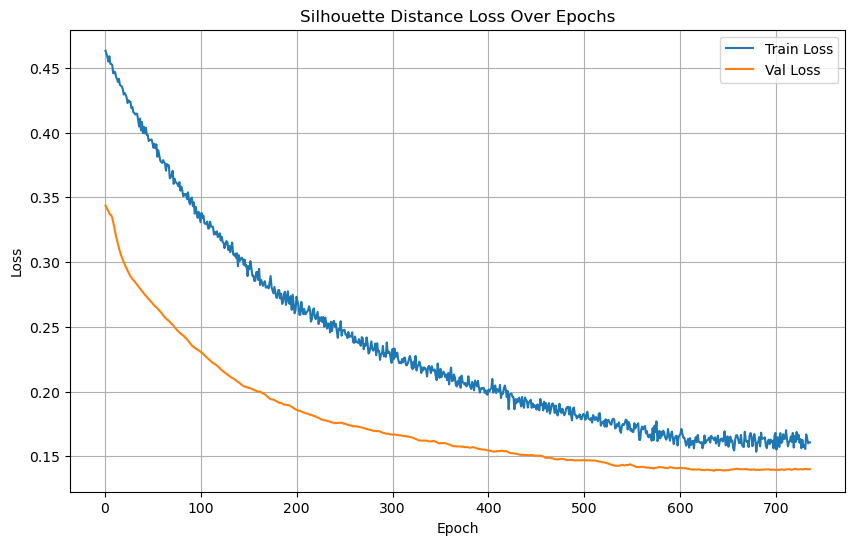

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/835], Loss: 0.0414
Test Batch [20/835], Loss: 0.1156
Test Batch [30/835], Loss: 0.1345
Test Batch [40/835], Loss: 0.5000
Test Batch [50/835], Loss: 0.5000
Test Batch [60/835], Loss: 0.0958
Test Batch [70/835], Loss: 0.5000


Test Batch [80/835], Loss: 0.1176
Test Batch [90/835], Loss: 0.0860
Test Batch [100/835], Loss: 0.1972
Test Batch [110/835], Loss: 0.1063
Test Batch [120/835], Loss: 0.0914
Test Batch [130/835], Loss: 0.1196
Test Batch [140/835], Loss: 0.1396
Test Batch [150/835], Loss: 0.1136


Test Batch [160/835], Loss: 0.0616
Test Batch [170/835], Loss: 0.1018
Test Batch [180/835], Loss: 0.1522
Test Batch [190/835], Loss: 0.1021
Test Batch [200/835], Loss: 0.0734


Test Batch [210/835], Loss: 0.0545
Test Batch [220/835], Loss: 0.0615
Test Batch [230/835], Loss: 0.0565
Test Batch [240/835], Loss: 0.0858


Test Batch [250/835], Loss: 0.0827
Test Batch [260/835], Loss: 0.1748
Test Batch [270/835], Loss: 0.1100
Test Batch [280/835], Loss: 0.1069


Test Batch [290/835], Loss: 0.1703
Test Batch [300/835], Loss: 0.1033
Test Batch [310/835], Loss: 0.1306
Test Batch [320/835], Loss: 0.1577
Test Batch [330/835], Loss: 0.1516


Test Batch [340/835], Loss: 0.5000
Test Batch [350/835], Loss: 0.5000
Test Batch [360/835], Loss: 0.5000
Test Batch [370/835], Loss: 0.5000
Test Batch [380/835], Loss: 0.5000
Test Batch [390/835], Loss: 0.5000
Test Batch [400/835], Loss: 0.5000
Test Batch [410/835], Loss: 0.5000
Test Batch [420/835], Loss: 0.1165
Test Batch [430/835], Loss: 0.0892
Test Batch [440/835], Loss: 0.0766


Test Batch [450/835], Loss: 0.1532
Test Batch [460/835], Loss: 0.1086
Test Batch [470/835], Loss: 0.1034
Test Batch [480/835], Loss: 0.5000
Test Batch [490/835], Loss: 0.5000
Test Batch [500/835], Loss: 0.0470
Test Batch [510/835], Loss: 0.0499


Test Batch [520/835], Loss: 0.1124
Test Batch [530/835], Loss: 0.0511
Test Batch [540/835], Loss: 0.0513
Test Batch [550/835], Loss: 0.0708
Test Batch [560/835], Loss: 0.0524


Test Batch [570/835], Loss: 0.0589
Test Batch [580/835], Loss: 0.1118
Test Batch [590/835], Loss: 0.0618
Test Batch [600/835], Loss: 0.1433
Test Batch [610/835], Loss: 0.1730
Test Batch [620/835], Loss: 0.2242


Test Batch [630/835], Loss: 0.1645
Test Batch [640/835], Loss: 0.1237
Test Batch [650/835], Loss: 0.0941
Test Batch [660/835], Loss: 0.1280
Test Batch [670/835], Loss: 0.3580


Test Batch [680/835], Loss: 0.0976
Test Batch [690/835], Loss: 0.0670
Test Batch [700/835], Loss: 0.3852
Test Batch [710/835], Loss: 0.1520
Test Batch [720/835], Loss: 0.3224


Test Batch [730/835], Loss: 0.3530
Test Batch [740/835], Loss: 0.5000
Test Batch [750/835], Loss: 0.0547
Test Batch [760/835], Loss: 0.1379
Test Batch [770/835], Loss: 0.1792
Test Batch [780/835], Loss: 0.5000


Test Batch [790/835], Loss: 0.1117
Test Batch [800/835], Loss: 0.1617
Test Batch [810/835], Loss: 0.5000
Test Batch [820/835], Loss: 0.1191
Test Batch [830/835], Loss: 0.5000

Test Loss: 0.1901


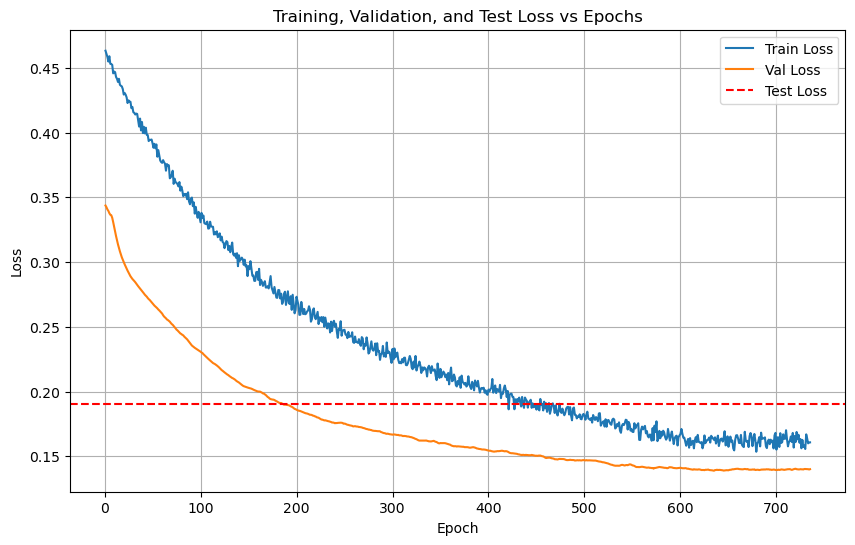

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/835 for test dataset.
  Processed batch 20/835 for test dataset.


  Processed batch 30/835 for test dataset.
  Processed batch 40/835 for test dataset.
  Processed batch 50/835 for test dataset.


  Processed batch 60/835 for test dataset.
  Processed batch 70/835 for test dataset.
  Processed batch 80/835 for test dataset.


  Processed batch 90/835 for test dataset.
  Processed batch 100/835 for test dataset.
  Processed batch 110/835 for test dataset.


  Processed batch 120/835 for test dataset.
  Processed batch 130/835 for test dataset.
  Processed batch 140/835 for test dataset.


  Processed batch 150/835 for test dataset.
  Processed batch 160/835 for test dataset.
  Processed batch 170/835 for test dataset.


  Processed batch 180/835 for test dataset.
  Processed batch 190/835 for test dataset.
  Processed batch 200/835 for test dataset.
  Processed batch 210/835 for test dataset.


  Processed batch 220/835 for test dataset.
  Processed batch 230/835 for test dataset.
  Processed batch 240/835 for test dataset.
  Processed batch 250/835 for test dataset.


  Processed batch 260/835 for test dataset.
  Processed batch 270/835 for test dataset.
  Processed batch 280/835 for test dataset.


  Processed batch 290/835 for test dataset.
  Processed batch 300/835 for test dataset.
  Processed batch 310/835 for test dataset.


  Processed batch 320/835 for test dataset.
  Processed batch 330/835 for test dataset.
  Processed batch 340/835 for test dataset.


  Processed batch 350/835 for test dataset.
  Processed batch 360/835 for test dataset.
  Processed batch 370/835 for test dataset.


  Processed batch 380/835 for test dataset.
  Processed batch 390/835 for test dataset.
  Processed batch 400/835 for test dataset.


  Processed batch 410/835 for test dataset.
  Processed batch 420/835 for test dataset.
  Processed batch 430/835 for test dataset.


  Processed batch 440/835 for test dataset.
  Processed batch 450/835 for test dataset.
  Processed batch 460/835 for test dataset.


  Processed batch 470/835 for test dataset.
  Processed batch 480/835 for test dataset.
  Processed batch 490/835 for test dataset.
  Processed batch 500/835 for test dataset.


  Processed batch 510/835 for test dataset.
  Processed batch 520/835 for test dataset.
  Processed batch 530/835 for test dataset.
  Processed batch 540/835 for test dataset.


  Processed batch 550/835 for test dataset.
  Processed batch 560/835 for test dataset.
  Processed batch 570/835 for test dataset.


  Processed batch 580/835 for test dataset.
  Processed batch 590/835 for test dataset.
  Processed batch 600/835 for test dataset.
  Processed batch 610/835 for test dataset.


  Processed batch 620/835 for test dataset.
  Processed batch 630/835 for test dataset.
  Processed batch 640/835 for test dataset.


  Processed batch 650/835 for test dataset.
  Processed batch 660/835 for test dataset.
  Processed batch 670/835 for test dataset.


  Processed batch 680/835 for test dataset.
  Processed batch 690/835 for test dataset.
  Processed batch 700/835 for test dataset.


  Processed batch 710/835 for test dataset.
  Processed batch 720/835 for test dataset.
  Processed batch 730/835 for test dataset.
  Processed batch 740/835 for test dataset.


  Processed batch 750/835 for test dataset.
  Processed batch 760/835 for test dataset.
  Processed batch 770/835 for test dataset.
  Processed batch 780/835 for test dataset.


  Processed batch 790/835 for test dataset.
  Processed batch 800/835 for test dataset.
  Processed batch 810/835 for test dataset.
  Processed batch 820/835 for test dataset.


  Processed batch 830/835 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.71      1.00      0.83         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.40      0.57         5
           8       0.83      1.00      0.91         5
           9       0.80      0.80      0.80         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (640, 128)
Train labels shape: (640,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53409, 128)
Test labels shape: (53409,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0007  |  Val Loss: 2.9027
Validation loss improved from inf to 2.9027.
[Epoch 2/1000] Train Loss: 2.8518  |  Val Loss: 2.7740
Validation loss improved from 2.9027 to 2.7740.
[Epoch 3/1000] Train Loss: 2.7242  |  Val Loss: 2.6601
Validation loss improved from 2.7740 to 2.6601.
[Epoch 4/1000] Train Loss: 2.6097  |  Val Loss: 2.5608
Validation loss improved from 2.6601 to 2.5608.
[Epoch 5/1000] Train Loss: 2.5116  |  Val Loss: 2.4778
Validation loss improved from 2.5608 to 2.4778.
[Epoch 6/1000] Train Loss: 2.4285  |  Val Loss: 2.4027
Validation loss improved from 2.4778 to 2.4027.
[Epoch 7/1000] Train Loss: 2.3528  |  Val Loss: 2.3375
Validation loss improved from 2.4027 to 2.3375.


[Epoch 8/1000] Train Loss: 2.2887  |  Val Loss: 2.2816
Validation loss improved from 2.3375 to 2.2816.
[Epoch 9/1000] Train Loss: 2.2286  |  Val Loss: 2.2328
Validation loss improved from 2.2816 to 2.2328.
[Epoch 10/1000] Train Loss: 2.1778  |  Val Loss: 2.1868
Validation loss improved from 2.2328 to 2.1868.


[Epoch 11/1000] Train Loss: 2.1290  |  Val Loss: 2.1450
Validation loss improved from 2.1868 to 2.1450.
[Epoch 12/1000] Train Loss: 2.0833  |  Val Loss: 2.1041
Validation loss improved from 2.1450 to 2.1041.
[Epoch 13/1000] Train Loss: 2.0381  |  Val Loss: 2.0643
Validation loss improved from 2.1041 to 2.0643.
[Epoch 14/1000] Train Loss: 1.9943  |  Val Loss: 2.0255
Validation loss improved from 2.0643 to 2.0255.
[Epoch 15/1000] Train Loss: 1.9507  |  Val Loss: 1.9869
Validation loss improved from 2.0255 to 1.9869.
[Epoch 16/1000] Train Loss: 1.9076  |  Val Loss: 1.9482
Validation loss improved from 1.9869 to 1.9482.
[Epoch 17/1000] Train Loss: 1.8634  |  Val Loss: 1.9088
Validation loss improved from 1.9482 to 1.9088.


[Epoch 18/1000] Train Loss: 1.8181  |  Val Loss: 1.8705
Validation loss improved from 1.9088 to 1.8705.
[Epoch 19/1000] Train Loss: 1.7748  |  Val Loss: 1.8330
Validation loss improved from 1.8705 to 1.8330.
[Epoch 20/1000] Train Loss: 1.7318  |  Val Loss: 1.7975
Validation loss improved from 1.8330 to 1.7975.
[Epoch 21/1000] Train Loss: 1.6911  |  Val Loss: 1.7613
Validation loss improved from 1.7975 to 1.7613.


[Epoch 22/1000] Train Loss: 1.6498  |  Val Loss: 1.7255
Validation loss improved from 1.7613 to 1.7255.
[Epoch 23/1000] Train Loss: 1.6098  |  Val Loss: 1.6895
Validation loss improved from 1.7255 to 1.6895.
[Epoch 24/1000] Train Loss: 1.5696  |  Val Loss: 1.6540
Validation loss improved from 1.6895 to 1.6540.
[Epoch 25/1000] Train Loss: 1.5296  |  Val Loss: 1.6195
Validation loss improved from 1.6540 to 1.6195.
[Epoch 26/1000] Train Loss: 1.4913  |  Val Loss: 1.5849
Validation loss improved from 1.6195 to 1.5849.
[Epoch 27/1000] Train Loss: 1.4522  |  Val Loss: 1.5525
Validation loss improved from 1.5849 to 1.5525.
[Epoch 28/1000] Train Loss: 1.4143  |  Val Loss: 1.5218
Validation loss improved from 1.5525 to 1.5218.


[Epoch 29/1000] Train Loss: 1.3764  |  Val Loss: 1.4919
Validation loss improved from 1.5218 to 1.4919.
[Epoch 30/1000] Train Loss: 1.3380  |  Val Loss: 1.4621
Validation loss improved from 1.4919 to 1.4621.
[Epoch 31/1000] Train Loss: 1.3008  |  Val Loss: 1.4343
Validation loss improved from 1.4621 to 1.4343.
[Epoch 32/1000] Train Loss: 1.2642  |  Val Loss: 1.4080
Validation loss improved from 1.4343 to 1.4080.


[Epoch 33/1000] Train Loss: 1.2284  |  Val Loss: 1.3825
Validation loss improved from 1.4080 to 1.3825.
[Epoch 34/1000] Train Loss: 1.1934  |  Val Loss: 1.3583
Validation loss improved from 1.3825 to 1.3583.
[Epoch 35/1000] Train Loss: 1.1591  |  Val Loss: 1.3345
Validation loss improved from 1.3583 to 1.3345.
[Epoch 36/1000] Train Loss: 1.1260  |  Val Loss: 1.3122
Validation loss improved from 1.3345 to 1.3122.
[Epoch 37/1000] Train Loss: 1.0935  |  Val Loss: 1.2877
Validation loss improved from 1.3122 to 1.2877.
[Epoch 38/1000] Train Loss: 1.0610  |  Val Loss: 1.2645
Validation loss improved from 1.2877 to 1.2645.
[Epoch 39/1000] Train Loss: 1.0300  |  Val Loss: 1.2435
Validation loss improved from 1.2645 to 1.2435.


[Epoch 40/1000] Train Loss: 0.9996  |  Val Loss: 1.2214
Validation loss improved from 1.2435 to 1.2214.
[Epoch 41/1000] Train Loss: 0.9694  |  Val Loss: 1.2012
Validation loss improved from 1.2214 to 1.2012.
[Epoch 42/1000] Train Loss: 0.9401  |  Val Loss: 1.1837
Validation loss improved from 1.2012 to 1.1837.
[Epoch 43/1000] Train Loss: 0.9121  |  Val Loss: 1.1632
Validation loss improved from 1.1837 to 1.1632.


[Epoch 44/1000] Train Loss: 0.8841  |  Val Loss: 1.1437
Validation loss improved from 1.1632 to 1.1437.
[Epoch 45/1000] Train Loss: 0.8567  |  Val Loss: 1.1257
Validation loss improved from 1.1437 to 1.1257.
[Epoch 46/1000] Train Loss: 0.8298  |  Val Loss: 1.1077
Validation loss improved from 1.1257 to 1.1077.
[Epoch 47/1000] Train Loss: 0.8034  |  Val Loss: 1.0927
Validation loss improved from 1.1077 to 1.0927.
[Epoch 48/1000] Train Loss: 0.7773  |  Val Loss: 1.0716
Validation loss improved from 1.0927 to 1.0716.
[Epoch 49/1000] Train Loss: 0.7521  |  Val Loss: 1.0553
Validation loss improved from 1.0716 to 1.0553.


[Epoch 50/1000] Train Loss: 0.7279  |  Val Loss: 1.0361
Validation loss improved from 1.0553 to 1.0361.
[Epoch 51/1000] Train Loss: 0.7036  |  Val Loss: 1.0239
Validation loss improved from 1.0361 to 1.0239.
[Epoch 52/1000] Train Loss: 0.6806  |  Val Loss: 1.0058
Validation loss improved from 1.0239 to 1.0058.
[Epoch 53/1000] Train Loss: 0.6575  |  Val Loss: 0.9910
Validation loss improved from 1.0058 to 0.9910.


[Epoch 54/1000] Train Loss: 0.6357  |  Val Loss: 0.9726
Validation loss improved from 0.9910 to 0.9726.
[Epoch 55/1000] Train Loss: 0.6136  |  Val Loss: 0.9572
Validation loss improved from 0.9726 to 0.9572.
[Epoch 56/1000] Train Loss: 0.5928  |  Val Loss: 0.9448
Validation loss improved from 0.9572 to 0.9448.
[Epoch 57/1000] Train Loss: 0.5727  |  Val Loss: 0.9280
Validation loss improved from 0.9448 to 0.9280.
[Epoch 58/1000] Train Loss: 0.5528  |  Val Loss: 0.9184
Validation loss improved from 0.9280 to 0.9184.
[Epoch 59/1000] Train Loss: 0.5338  |  Val Loss: 0.9060
Validation loss improved from 0.9184 to 0.9060.


[Epoch 60/1000] Train Loss: 0.5152  |  Val Loss: 0.8972
Validation loss improved from 0.9060 to 0.8972.
[Epoch 61/1000] Train Loss: 0.4978  |  Val Loss: 0.8850
Validation loss improved from 0.8972 to 0.8850.
[Epoch 62/1000] Train Loss: 0.4805  |  Val Loss: 0.8767
Validation loss improved from 0.8850 to 0.8767.
[Epoch 63/1000] Train Loss: 0.4648  |  Val Loss: 0.8677
Validation loss improved from 0.8767 to 0.8677.
[Epoch 64/1000] Train Loss: 0.4488  |  Val Loss: 0.8587
Validation loss improved from 0.8677 to 0.8587.
[Epoch 65/1000] Train Loss: 0.4338  |  Val Loss: 0.8504
Validation loss improved from 0.8587 to 0.8504.


[Epoch 66/1000] Train Loss: 0.4198  |  Val Loss: 0.8416
Validation loss improved from 0.8504 to 0.8416.
[Epoch 67/1000] Train Loss: 0.4063  |  Val Loss: 0.8368
Validation loss improved from 0.8416 to 0.8368.
[Epoch 68/1000] Train Loss: 0.3930  |  Val Loss: 0.8300
Validation loss improved from 0.8368 to 0.8300.
[Epoch 69/1000] Train Loss: 0.3803  |  Val Loss: 0.8220
Validation loss improved from 0.8300 to 0.8220.


[Epoch 70/1000] Train Loss: 0.3687  |  Val Loss: 0.8139
Validation loss improved from 0.8220 to 0.8139.
[Epoch 71/1000] Train Loss: 0.3567  |  Val Loss: 0.8103
Validation loss improved from 0.8139 to 0.8103.
[Epoch 72/1000] Train Loss: 0.3452  |  Val Loss: 0.8035
Validation loss improved from 0.8103 to 0.8035.
[Epoch 73/1000] Train Loss: 0.3340  |  Val Loss: 0.7985
Validation loss improved from 0.8035 to 0.7985.
[Epoch 74/1000] Train Loss: 0.3235  |  Val Loss: 0.7922
Validation loss improved from 0.7985 to 0.7922.
[Epoch 75/1000] Train Loss: 0.3128  |  Val Loss: 0.7882
Validation loss improved from 0.7922 to 0.7882.


[Epoch 76/1000] Train Loss: 0.3030  |  Val Loss: 0.7841
Validation loss improved from 0.7882 to 0.7841.
[Epoch 77/1000] Train Loss: 0.2932  |  Val Loss: 0.7786
Validation loss improved from 0.7841 to 0.7786.
[Epoch 78/1000] Train Loss: 0.2839  |  Val Loss: 0.7719
Validation loss improved from 0.7786 to 0.7719.
[Epoch 79/1000] Train Loss: 0.2751  |  Val Loss: 0.7698
Validation loss improved from 0.7719 to 0.7698.


[Epoch 80/1000] Train Loss: 0.2669  |  Val Loss: 0.7640
Validation loss improved from 0.7698 to 0.7640.
[Epoch 81/1000] Train Loss: 0.2577  |  Val Loss: 0.7637
Validation loss improved from 0.7640 to 0.7637.
[Epoch 82/1000] Train Loss: 0.2497  |  Val Loss: 0.7580
Validation loss improved from 0.7637 to 0.7580.
[Epoch 83/1000] Train Loss: 0.2416  |  Val Loss: 0.7538
Validation loss improved from 0.7580 to 0.7538.
[Epoch 84/1000] Train Loss: 0.2340  |  Val Loss: 0.7517
Validation loss improved from 0.7538 to 0.7517.
[Epoch 85/1000] Train Loss: 0.2264  |  Val Loss: 0.7493
Validation loss improved from 0.7517 to 0.7493.


[Epoch 86/1000] Train Loss: 0.2198  |  Val Loss: 0.7493
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 87/1000] Train Loss: 0.2128  |  Val Loss: 0.7479
Validation loss improved from 0.7493 to 0.7479.
[Epoch 88/1000] Train Loss: 0.2063  |  Val Loss: 0.7440
Validation loss improved from 0.7479 to 0.7440.
[Epoch 89/1000] Train Loss: 0.2000  |  Val Loss: 0.7442
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 90/1000] Train Loss: 0.1936  |  Val Loss: 0.7424
Validation loss improved from 0.7440 to 0.7424.
[Epoch 91/1000] Train Loss: 0.1874  |  Val Loss: 0.7419
Validation loss improved from 0.7424 to 0.7419.
[Epoch 92/1000] Train Loss: 0.1824  |  Val Loss: 0.7378
Validation loss improved from 0.7419 to 0.7378.
[Epoch 93/1000] Train Loss: 0.1763  |  Val Loss: 0.7391
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 0.1710  |  Val Loss: 0.7384
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 95/1000] Train Loss: 0.1660  |  Val Loss: 0.7361
Validation loss improved from 0.7378 to 0.7361.


[Epoch 96/1000] Train Loss: 0.1610  |  Val Loss: 0.7360
Validation loss improved from 0.7361 to 0.7360.
[Epoch 97/1000] Train Loss: 0.1564  |  Val Loss: 0.7360
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 0.1518  |  Val Loss: 0.7363
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 99/1000] Train Loss: 0.1471  |  Val Loss: 0.7327
Validation loss improved from 0.7360 to 0.7327.
[Epoch 100/1000] Train Loss: 0.1433  |  Val Loss: 0.7296
Validation loss improved from 0.7327 to 0.7296.
[Epoch 101/1000] Train Loss: 0.1391  |  Val Loss: 0.7335
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.1351  |  Val Loss: 0.7347
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 0.1314  |  Val Loss: 0.7327
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train Loss: 0.1280  |  Val Loss: 0.7316
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 105/1000] Train Loss: 0.1245  |  Val Loss: 0.7300
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 106/1000] Train Loss: 0.1214  |  Val Loss: 0.7321
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 107/1000] Train Loss: 0.1185  |  Val Loss: 0.7350
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 108/1000] Train Loss: 0.1153  |  Val Loss: 0.7317
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 109/1000] Train Loss: 0.1121  |  Val Loss: 0.7301
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 110/1000] Train Loss: 0.1092  |  Val Loss: 0.7324
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 111/1000] Train Loss: 0.1065  |  Val Loss: 0.7343
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 112/1000] Train Loss: 0.1042  |  Val Loss: 0.7321
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 113/1000] Train Loss: 0.1014  |  Val Loss: 0.7342
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 114/1000] Train Loss: 0.0995  |  Val Loss: 0.7342
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 115/1000] Train Loss: 0.0973  |  Val Loss: 0.7388
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 116/1000] Train Loss: 0.0947  |  Val Loss: 0.7353
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 117/1000] Train Loss: 0.0925  |  Val Loss: 0.7373
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 118/1000] Train Loss: 0.0904  |  Val Loss: 0.7366
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 119/1000] Train Loss: 0.0884  |  Val Loss: 0.7383
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 120/1000] Train Loss: 0.0866  |  Val Loss: 0.7387
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 121/1000] Train Loss: 0.0847  |  Val Loss: 0.7388
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 122/1000] Train Loss: 0.0829  |  Val Loss: 0.7403
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 123/1000] Train Loss: 0.0816  |  Val Loss: 0.7459
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 124/1000] Train Loss: 0.0799  |  Val Loss: 0.7405
!! Validation loss did NOT improve !! Patience: 24/100


[Epoch 125/1000] Train Loss: 0.0784  |  Val Loss: 0.7468
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 126/1000] Train Loss: 0.0765  |  Val Loss: 0.7457
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 127/1000] Train Loss: 0.0751  |  Val Loss: 0.7468
!! Validation loss did NOT improve !! Patience: 27/100


[Epoch 128/1000] Train Loss: 0.0748  |  Val Loss: 0.7419
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 129/1000] Train Loss: 0.0722  |  Val Loss: 0.7498
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 130/1000] Train Loss: 0.0712  |  Val Loss: 0.7550
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 131/1000] Train Loss: 0.0697  |  Val Loss: 0.7524
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 132/1000] Train Loss: 0.0685  |  Val Loss: 0.7511
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 133/1000] Train Loss: 0.0672  |  Val Loss: 0.7517
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 134/1000] Train Loss: 0.0663  |  Val Loss: 0.7575
!! Validation loss did NOT improve !! Patience: 34/100


[Epoch 135/1000] Train Loss: 0.0653  |  Val Loss: 0.7549
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 136/1000] Train Loss: 0.0641  |  Val Loss: 0.7567
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 137/1000] Train Loss: 0.0633  |  Val Loss: 0.7624
!! Validation loss did NOT improve !! Patience: 37/100


[Epoch 138/1000] Train Loss: 0.0623  |  Val Loss: 0.7582
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 139/1000] Train Loss: 0.0610  |  Val Loss: 0.7624
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 140/1000] Train Loss: 0.0600  |  Val Loss: 0.7607
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 141/1000] Train Loss: 0.0590  |  Val Loss: 0.7622
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 142/1000] Train Loss: 0.0585  |  Val Loss: 0.7626
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 143/1000] Train Loss: 0.0574  |  Val Loss: 0.7655
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 144/1000] Train Loss: 0.0568  |  Val Loss: 0.7691
!! Validation loss did NOT improve !! Patience: 44/100


[Epoch 145/1000] Train Loss: 0.0558  |  Val Loss: 0.7643
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 146/1000] Train Loss: 0.0550  |  Val Loss: 0.7662
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 147/1000] Train Loss: 0.0542  |  Val Loss: 0.7664
!! Validation loss did NOT improve !! Patience: 47/100


[Epoch 148/1000] Train Loss: 0.0536  |  Val Loss: 0.7702
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 149/1000] Train Loss: 0.0530  |  Val Loss: 0.7708
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 150/1000] Train Loss: 0.0520  |  Val Loss: 0.7732
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 151/1000] Train Loss: 0.0515  |  Val Loss: 0.7747
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 152/1000] Train Loss: 0.0507  |  Val Loss: 0.7738
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 153/1000] Train Loss: 0.0502  |  Val Loss: 0.7729
!! Validation loss did NOT improve !! Patience: 53/100


[Epoch 154/1000] Train Loss: 0.0496  |  Val Loss: 0.7764
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 155/1000] Train Loss: 0.0490  |  Val Loss: 0.7792
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 156/1000] Train Loss: 0.0483  |  Val Loss: 0.7812
!! Validation loss did NOT improve !! Patience: 56/100


[Epoch 157/1000] Train Loss: 0.0479  |  Val Loss: 0.7813
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 158/1000] Train Loss: 0.0476  |  Val Loss: 0.7813
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 159/1000] Train Loss: 0.0470  |  Val Loss: 0.7876
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 160/1000] Train Loss: 0.0467  |  Val Loss: 0.7856
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 161/1000] Train Loss: 0.0457  |  Val Loss: 0.7882
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 162/1000] Train Loss: 0.0456  |  Val Loss: 0.7888
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 163/1000] Train Loss: 0.0449  |  Val Loss: 0.7942
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 164/1000] Train Loss: 0.0442  |  Val Loss: 0.7928
!! Validation loss did NOT improve !! Patience: 64/100


[Epoch 165/1000] Train Loss: 0.0440  |  Val Loss: 0.7943
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 166/1000] Train Loss: 0.0435  |  Val Loss: 0.7928
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 167/1000] Train Loss: 0.0432  |  Val Loss: 0.7954
!! Validation loss did NOT improve !! Patience: 67/100


[Epoch 168/1000] Train Loss: 0.0431  |  Val Loss: 0.7984
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 169/1000] Train Loss: 0.0424  |  Val Loss: 0.7976
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 170/1000] Train Loss: 0.0418  |  Val Loss: 0.8008
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 171/1000] Train Loss: 0.0419  |  Val Loss: 0.8063
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 172/1000] Train Loss: 0.0411  |  Val Loss: 0.8007
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 173/1000] Train Loss: 0.0407  |  Val Loss: 0.8034
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 174/1000] Train Loss: 0.0404  |  Val Loss: 0.8044
!! Validation loss did NOT improve !! Patience: 74/100


[Epoch 175/1000] Train Loss: 0.0403  |  Val Loss: 0.8109
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 176/1000] Train Loss: 0.0400  |  Val Loss: 0.8095
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 177/1000] Train Loss: 0.0393  |  Val Loss: 0.8101
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 178/1000] Train Loss: 0.0389  |  Val Loss: 0.8124
!! Validation loss did NOT improve !! Patience: 78/100


[Epoch 179/1000] Train Loss: 0.0385  |  Val Loss: 0.8128
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 180/1000] Train Loss: 0.0388  |  Val Loss: 0.8109
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 181/1000] Train Loss: 0.0382  |  Val Loss: 0.8178
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 182/1000] Train Loss: 0.0380  |  Val Loss: 0.8173
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 183/1000] Train Loss: 0.0374  |  Val Loss: 0.8184
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 184/1000] Train Loss: 0.0373  |  Val Loss: 0.8196
!! Validation loss did NOT improve !! Patience: 84/100


[Epoch 185/1000] Train Loss: 0.0367  |  Val Loss: 0.8199
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 186/1000] Train Loss: 0.0367  |  Val Loss: 0.8188
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 187/1000] Train Loss: 0.0363  |  Val Loss: 0.8216
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 188/1000] Train Loss: 0.0360  |  Val Loss: 0.8238
!! Validation loss did NOT improve !! Patience: 88/100


[Epoch 189/1000] Train Loss: 0.0358  |  Val Loss: 0.8303
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 190/1000] Train Loss: 0.0355  |  Val Loss: 0.8281
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 191/1000] Train Loss: 0.0353  |  Val Loss: 0.8272
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 192/1000] Train Loss: 0.0350  |  Val Loss: 0.8303
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 193/1000] Train Loss: 0.0348  |  Val Loss: 0.8319
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 194/1000] Train Loss: 0.0346  |  Val Loss: 0.8308
!! Validation loss did NOT improve !! Patience: 94/100


[Epoch 195/1000] Train Loss: 0.0346  |  Val Loss: 0.8362
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 196/1000] Train Loss: 0.0340  |  Val Loss: 0.8354
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 197/1000] Train Loss: 0.0340  |  Val Loss: 0.8335
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 198/1000] Train Loss: 0.0339  |  Val Loss: 0.8389
!! Validation loss did NOT improve !! Patience: 98/100


[Epoch 199/1000] Train Loss: 0.0334  |  Val Loss: 0.8396
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 200/1000] Train Loss: 0.0334  |  Val Loss: 0.8387
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 200 !!
No improvement for 100 epochs.


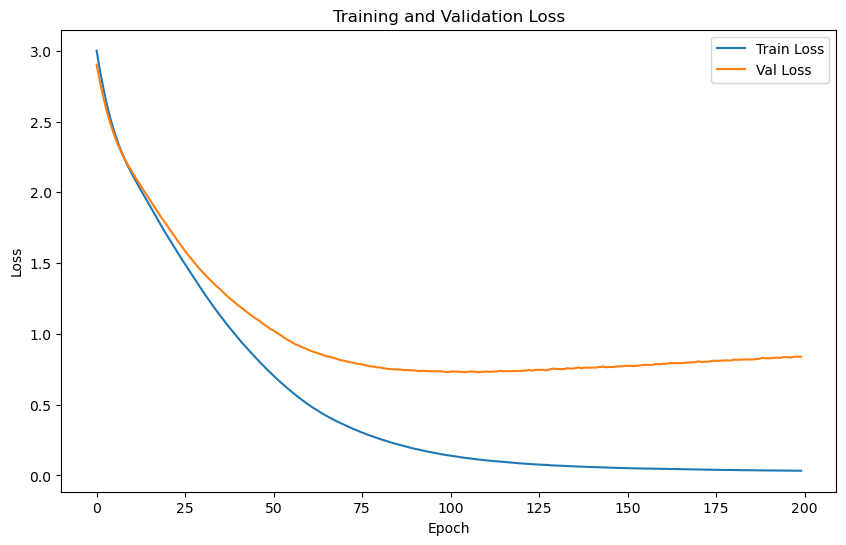

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.8015 | Test Accuracy: 83.28%


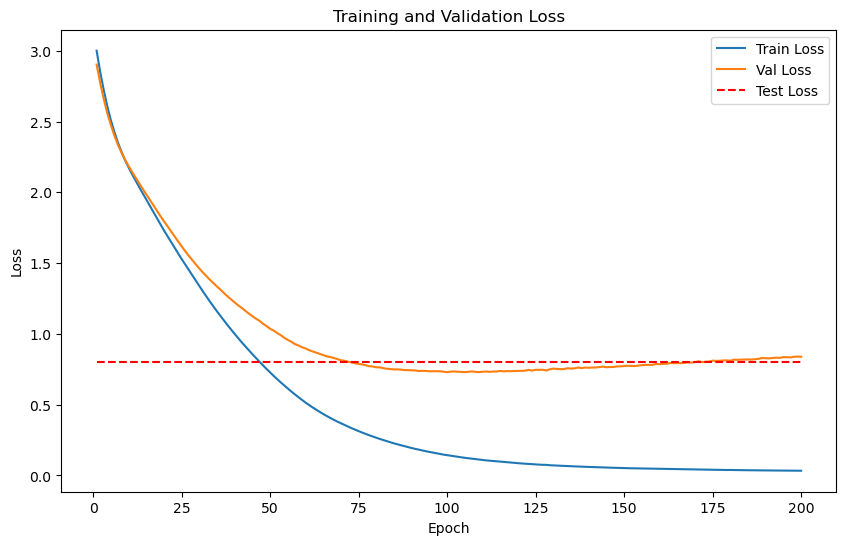

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


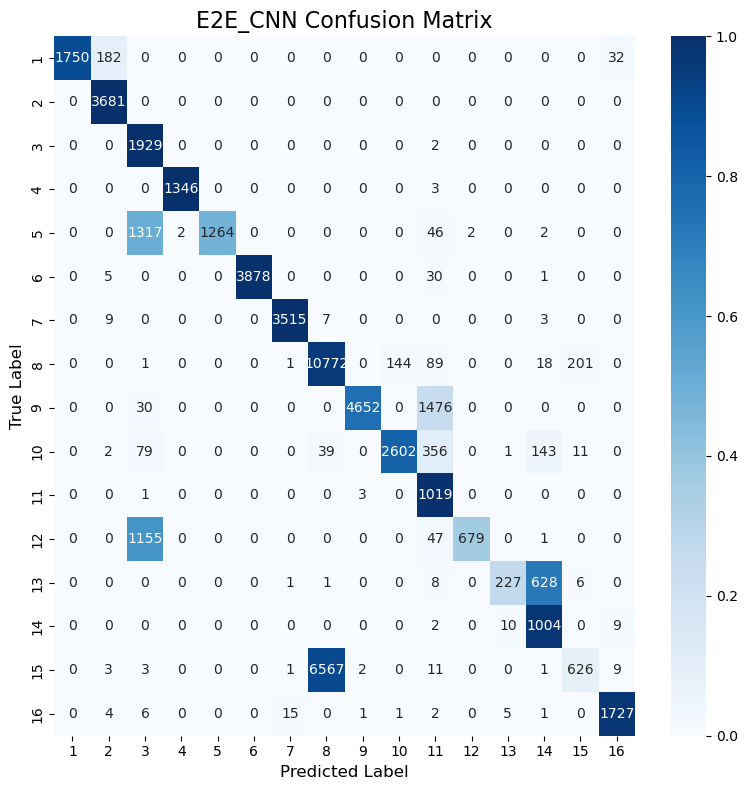

Classification Accuracy: 76.15%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


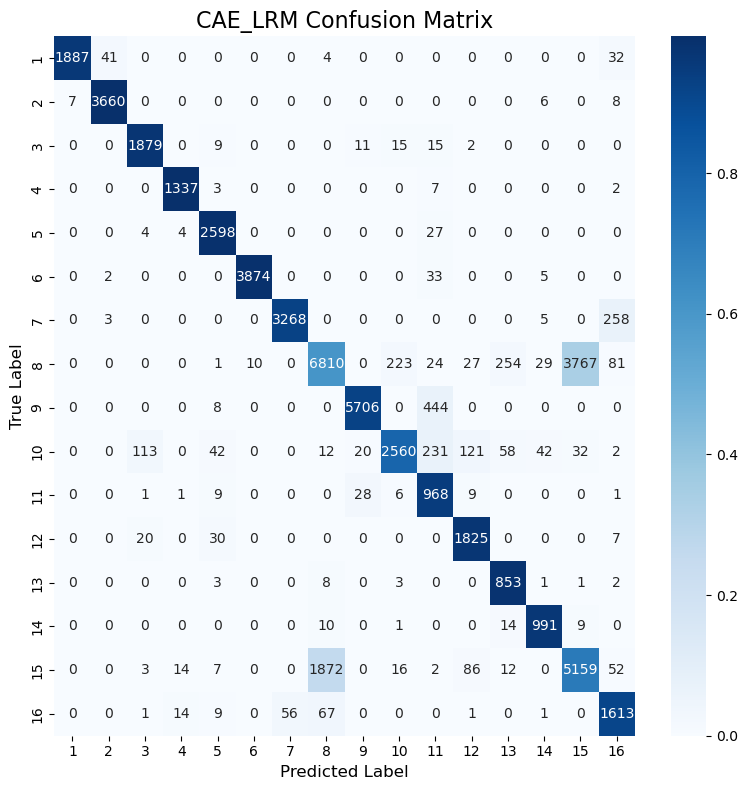

Classification Accuracy: 84.23%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


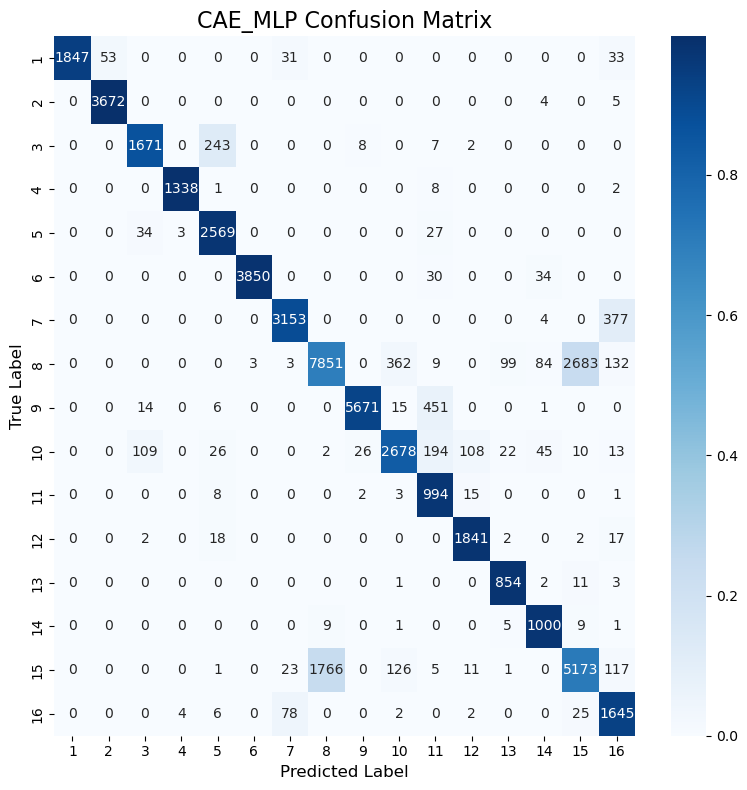

Classification Accuracy: 85.77%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


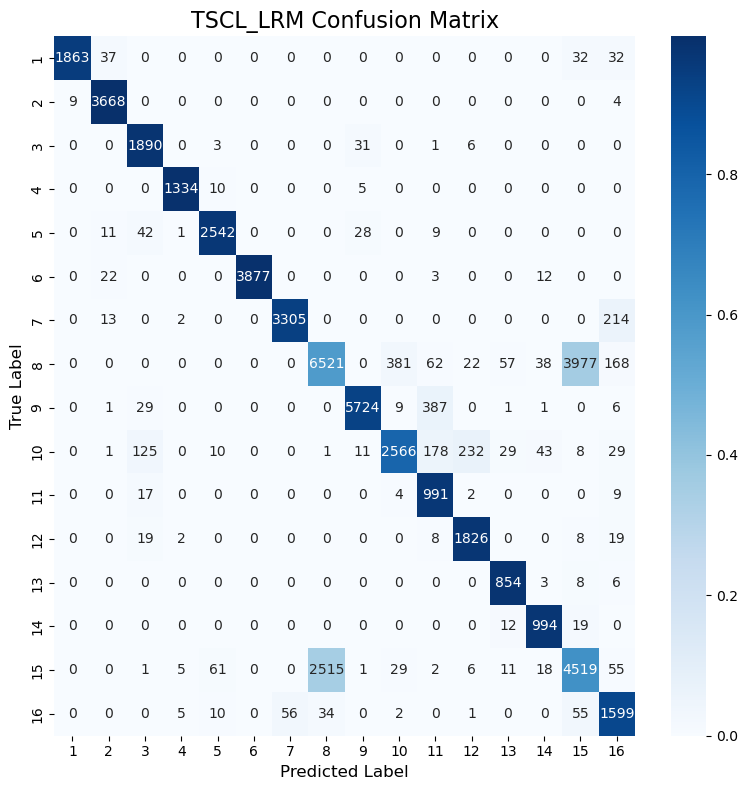

Classification Accuracy: 82.52%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


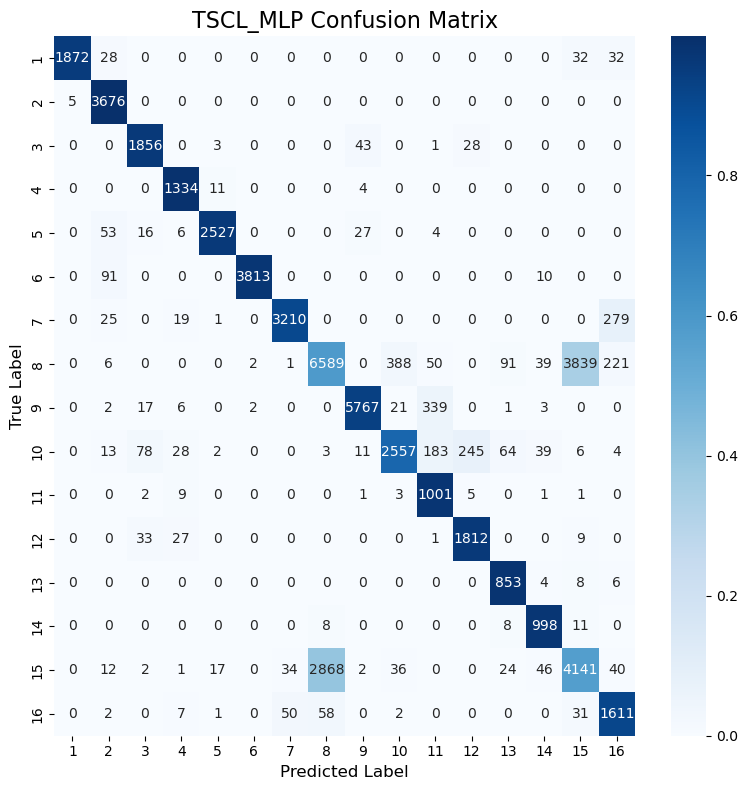

Classification Accuracy: 81.67%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


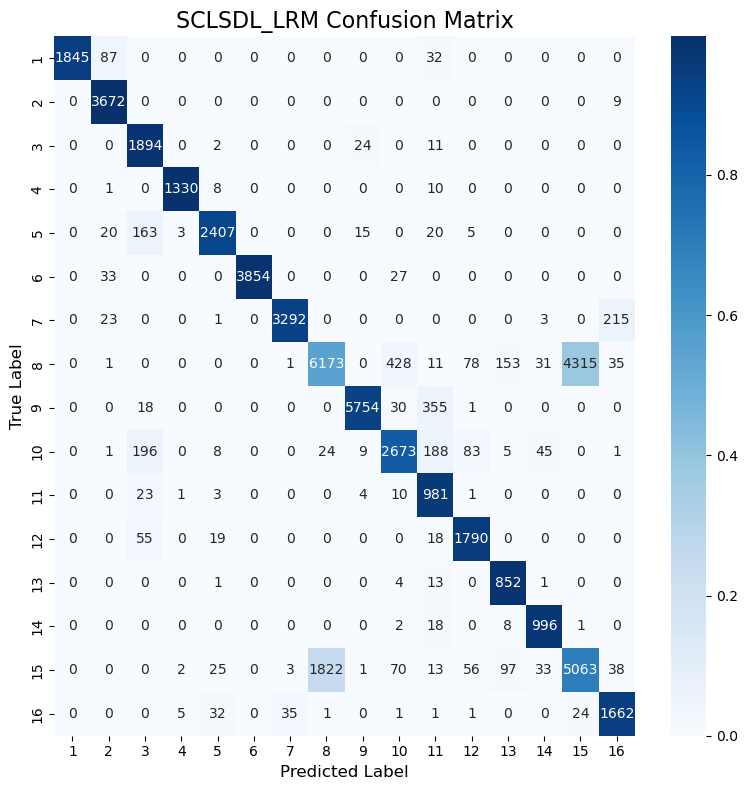

Classification Accuracy: 82.83%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


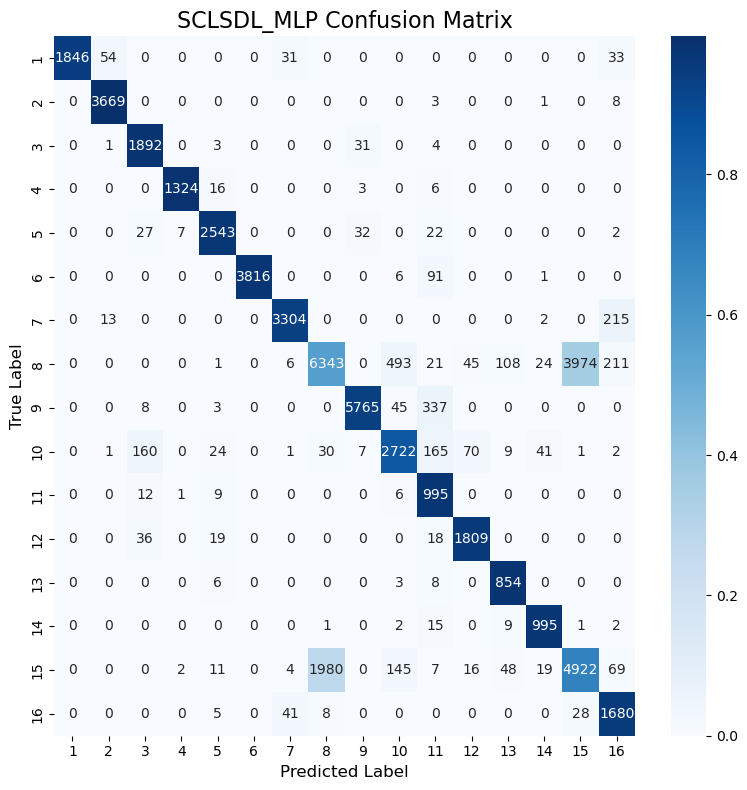

Classification Accuracy: 83.28%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          76.15
1    LRM (CAE)          84.23
2    MLP (CAE)          85.77
3     TSCL LRM          82.52
4     TSCL MLP          81.67
5  SCL_SDL LRM          82.83
6  SCL_SDL MLP          83.28

In Desc. Order (Test Accu)
         Model  Test_Accuracy
2    MLP (CAE)          85.77
1    LRM (CAE)          84.23
6  SCL_SDL MLP          83.28
5  SCL_SDL LRM          82.83
3     TSCL LRM          82.52
4     TSCL MLP          81.67
0      E2E CNN          76.15
